# Preprocessing of Raw Data using VAE + GAT

This preprocessing step is important to delete noise, standarize data and guarantee a quality analysis for the single cell RNA sequencing.

#### Import Libraries and data

In [530]:
!pip install tensorflow==2.10 tqdm

In [531]:
# pip install scanpy anndata scrublet matplotlib seaborn numpy pandas scipy scikit-learn
!pip install scrublet os
!pip install mygene
import mygene
import scanpy as sc
import anndata as ad
import scrublet as scr
import numpy as np
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as plt
import seaborn as sns
# from sklearn.decomposition import PCA
from IPython.core.display import display, HTML
import os, json, sys, re
# from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score


ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os


C:\Users\henry\AppData\Local\Temp\ipykernel_9688\3761028485.py:14: DeprecationWarning:

Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display



In [532]:
import warnings
# Suppress the specific FutureWarning and UserWarning
warnings.filterwarnings('ignore', category=FutureWarning, 
                       message="The default value of 'ignore' for the `na_action` parameter")
warnings.filterwarnings('ignore', category=UserWarning, 
                       message="No data for colormapping provided via 'c'")

# Suppress specific warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="numpy")
warnings.filterwarnings("ignore", category=FutureWarning, module="pandas")
warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered in log2")

#### Data Load

In [533]:
data_path = "C:/Users/henry/Desktop/python/jbook_rna/datos/Single-cell RNASeq data from Mouse Brain"
data_path2 = "C:/Users/henry/Desktop/python/jbook_rna/datos/Theory - Intro to single-cell RNAseq Images"

In [534]:
glioblastoma_norm_file = os.path.join(data_path, "glioblastoma_normalized.h5ad")
glioblastoma_raw_file = os.path.join(data_path, "glioblastoma_raw.h5ad")
pbmc3k_file = os.path.join(data_path, "pbmc3k.h5ad")

adata_glioblastoma_norm = sc.read_h5ad(glioblastoma_norm_file)
adata_glioblastoma_raw = sc.read_h5ad(glioblastoma_raw_file)
adata_pbmc3k = sc.read_h5ad(pbmc3k_file)

c:\Users\henry\miniconda3\envs\ml_venv\lib\site-packages\anndata\compat\__init__.py:311: FutureWarning:

Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.

c:\Users\henry\miniconda3\envs\ml_venv\lib\site-packages\anndata\compat\__init__.py:311: FutureWarning:

Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.



## **Quality Control (QC)**

### Quality control metrics

We use **three key QC metrics**:  

| **Metric**                      | **Issue Detected**                                     | **Filtering Rule** |
|----------------------------------|------------------------------------------------------|----------------------|
| **Total UMI Counts**             | Low = Empty droplets, debris<br>High = Possible doublets | Keep cells with a **moderate range** of UMI counts |
| **Number of Genes per Cell**     | Low = Dead/low-quality cells<br>High = Doublets     | Set **lower/upper cutoffs** based on distribution |
| **Mitochondrial Gene Percentage** | High = Cell stress, apoptosis                      | Remove cells with **too high mito RNA%** |

```{admonition} Quality Control (QC) Metrics in scRNA-seq
1️⃣ **Number of Cells Expressing Each Gene (`gene_counts`)**
- Measures how **widely expressed** each gene is across cells.  
- Genes expressed in **very few cells** may be **technical noise**.  
- Helps decide **which genes to keep** in downstream analysis. 

2️⃣ **Number of Detected Genes per Cell (`n_genes_by_cell`)**
- Indicates the **complexity** of RNA content in each cell.  
- **Low values** suggest dead cells or empty droplets.  
- **High values** may indicate doublets (two cells captured together).

3️⃣ **Total UMI Counts per Cell (`total_UMI_counts`)**
- Represents the **sequencing depth** per cell.  
- **Low counts** suggest poor RNA capture or damaged cells.  
- **High counts** can indicate doublets or highly active cells.

🔍 ***These metrics help identify low-quality cells before filtering.***
```

In [535]:
print(adata_glioblastoma_raw)

AnnData object with n_obs × n_vars = 1853 × 7683
    obs: 'disease_state', 'plate_id', 'tissue', 'patient_id', 'cell_type', 'neoplastic_state', 'diagnosis'


In [536]:
print(f'The data contains the following cells and gene count: \nNumber of cells: {adata_glioblastoma_raw.n_obs}')
print(f'Number of genes: {adata_glioblastoma_raw.n_vars}')

The data contains the following cells and gene count: 
Number of cells: 1853
Number of genes: 7683


In [537]:
sc.pp.calculate_qc_metrics(
    adata_glioblastoma_raw,
    percent_top=[50, 100, 200],   # For top highly variable genes
    inplace=True
)

adata_glioblastoma_raw.obs['total_counts'] = adata_glioblastoma_raw.X.sum(axis=1).astype(int)

gene level metrics

In [538]:
print("\nMétricas por gen (adata.var):")
print(adata_glioblastoma_raw.var.columns.tolist())


Métricas por gen (adata.var):
['n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts']


In [539]:
adata_glioblastoma_raw.var[['n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts']].head()  # Show first 5 genes


,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
index,,,,,,
ENSG00000000005,2,0.033459,0.032912,99.892067,62.000000,4.143135
ENSG00000001561,245,17.581758,2.922180,86.778198,32579.000000,10.391454
ENSG00000001629,715,29.176739,3.407071,61.413923,54064.496094,10.897951
ENSG00000002587,1268,22.115810,3.140517,31.570426,40980.597656,10.620878
ENSG00000002933,548,45.389587,3.837075,70.426336,84106.906250,11.339856


cell level metrics

In [540]:
print("Métricas por célula (adata.obs):")
print(adata_glioblastoma_raw.obs.columns.tolist())  

Métricas por célula (adata.obs):
['disease_state', 'plate_id', 'tissue', 'patient_id', 'cell_type', 'neoplastic_state', 'diagnosis', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes']


In [541]:
adata_glioblastoma_raw.obs[['disease_state', 'plate_id', 'tissue', 'patient_id', 'cell_type', 'neoplastic_state', 'diagnosis', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes']].head(20) 

,disease_state,plate_id,tissue,patient_id,cell_type,neoplastic_state,diagnosis,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes
index,,,,,,,,,,,,,,
GSM2243439,diagnosis: glioblastoma,plate id: 1001000173,tissue: Tumor,patient id: BT_S2,cell type: Neoplastic,neoplastic: Neoplastic,Neoplastic,1341,7.201916,159262,11.978314,65.554424,76.898016,89.034835
GSM2243444,diagnosis: glioblastoma,plate id: 1001000173,tissue: Tumor,patient id: BT_S2,cell type: Neoplastic,neoplastic: Neoplastic,Neoplastic,1456,7.284135,326321,12.695642,77.530281,83.443820,90.526005
GSM2243445,diagnosis: glioblastoma,plate id: 1001000173,tissue: Tumor,patient id: BT_S2,cell type: Neoplastic,neoplastic: Neoplastic,Neoplastic,1849,7.522941,196996,12.190948,50.919931,59.767944,70.261123
GSM2243447,diagnosis: glioblastoma,plate id: 1001000173,tissue: Tumor,patient id: BT_S2,cell type: Neoplastic,neoplastic: Neoplastic,Neoplastic,100,4.615121,90933,11.417895,99.950874,100.000009,100.000009
GSM2243452,diagnosis: glioblastoma,plate id: 1001000173,tissue: Tumor,patient id: BT_S2,cell type: Neoplastic,neoplastic: Neoplastic,Neoplastic,1788,7.489412,208278,12.246636,45.863893,56.620505,68.793036
GSM2243455,diagnosis: glioblastoma,plate id: 1001000173,tissue: Tumor,patient id: BT_S2,cell type: Oligodendrocyte,neoplastic: Regular,Oligodendrocyte,2377,7.774015,288928,12.573939,53.801413,62.445690,72.430413
GSM2243456,diagnosis: glioblastoma,plate id: 1001000173,tissue: Tumor,patient id: BT_S2,cell type: Neoplastic,neoplastic: Neoplastic,Neoplastic,1193,7.085064,115108,11.653637,55.652462,67.174401,80.651702
GSM2243457,diagnosis: glioblastoma,plate id: 1001000173,tissue: Tumor,patient id: BT_S2,cell type: Neoplastic,neoplastic: Neoplastic,Neoplastic,1823,7.508787,231921,12.354157,52.372863,62.087060,72.827387
GSM2243459,diagnosis: glioblastoma,plate id: 1001000173,tissue: Tumor,patient id: BT_S2,cell type: Neoplastic,neoplastic: Neoplastic,Neoplastic,1832,7.513709,363668,12.804001,41.660192,51.572769,64.153790


Summary statistics

plots

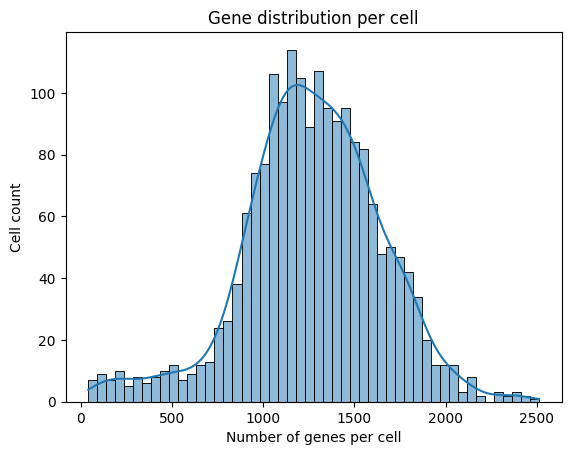

In [542]:
# Plot histogram of number of genes per cell
sns.histplot(adata_glioblastoma_raw.obs['n_genes_by_counts'], bins=50, kde=True)
plt.xlabel('Number of genes per cell')
plt.ylabel('Cell count')
plt.title('Gene distribution per cell')
plt.show()

### 🧬 Unique Molecular Identifiers (UMIs)

```{admonition} What is a UMI?
A **Unique Molecular Identifier (UMI)** is a short **random barcode** added to RNA molecules before sequencing.  
UMIs help correct for **PCR amplification bias** and improve the accuracy of gene expression quantification in single-cell RNA sequencing (**scRNA-seq**).
```

####  Why Are UMIs Important?
1️⃣ **Reduce PCR Bias** → Prevents artificially inflated gene expression caused by PCR duplicates.  
2️⃣ **Improve Quantification** → Counts only **unique UMIs**, not sequencing reads, for accurate expression levels.  
3️⃣ **Remove Technical Noise** → Helps correct sequencing errors and distinguish true biological signals.  

####  How Are UMIs Used in scRNA-seq?
- **Low UMI counts** → Suggests low RNA content, dead cells, or empty droplets.  
- **High UMI counts** → Could indicate doublets (two cells captured together).  
- **UMI filtering** ensures that only high-quality data is used in downstream analysis.  

 **UMIs improve scRNA-seq accuracy by eliminating technical biases.** 


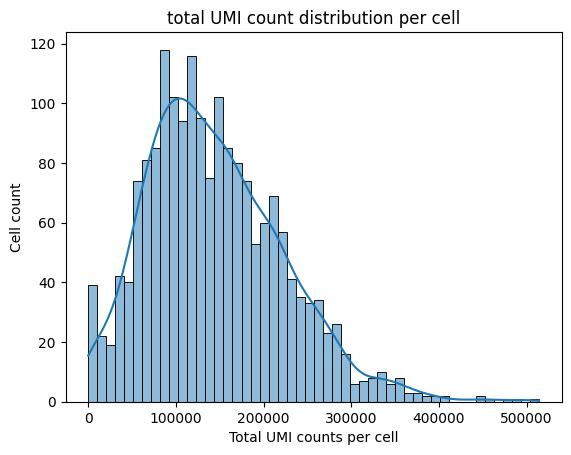

In [543]:
# Plot histogram of total UMI counts per cell
sns.histplot(adata_glioblastoma_raw.obs['total_counts'], bins = 50, kde=True)
plt.xlabel('Total UMI counts per cell')
plt.ylabel('Cell count')
plt.title('total UMI count distribution per cell')
plt.show()

Violin

c:\Users\henry\miniconda3\envs\ml_venv\lib\site-packages\scanpy\plotting\_anndata.py:843: FutureWarning:



The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.



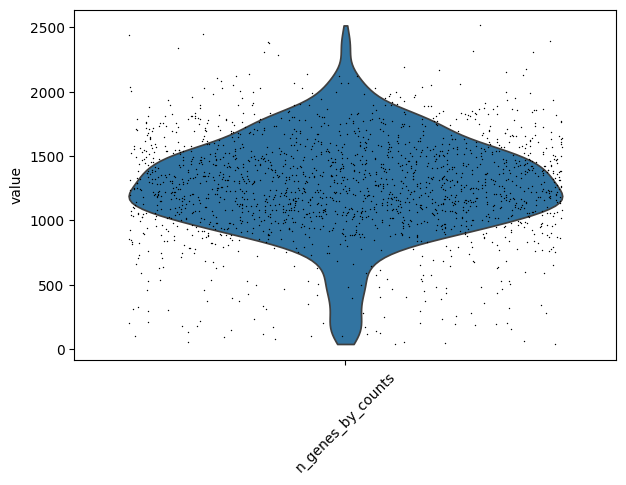

In [544]:
# Violin plot for gene counts per cell
sc.pl.violin(adata_glioblastoma_raw, keys='n_genes_by_counts', jitter=0.4, rotation=45)

In [545]:
# Print a sample of gene names to manually inspect for mitochondrial genes
print(adata_glioblastoma_raw.var_names.to_list()[:7683])  # Show first 7683 gene names

['ENSG00000000005', 'ENSG00000001561', 'ENSG00000001629', 'ENSG00000002587', 'ENSG00000002933', 'ENSG00000003056', 'ENSG00000003137', 'ENSG00000004478', 'ENSG00000004779', 'ENSG00000004799', 'ENSG00000004848', 'ENSG00000005001', 'ENSG00000005022', 'ENSG00000005073', 'ENSG00000005175', 'ENSG00000005243', 'ENSG00000005381', 'ENSG00000005421', 'ENSG00000005513', 'ENSG00000006059', 'ENSG00000006116', 'ENSG00000006194', 'ENSG00000006210', 'ENSG00000006451', 'ENSG00000006530', 'ENSG00000006606', 'ENSG00000006634', 'ENSG00000006831', 'ENSG00000007306', 'ENSG00000007376', 'ENSG00000007520', 'ENSG00000007968', 'ENSG00000008018', 'ENSG00000008118', 'ENSG00000008197', 'ENSG00000008282', 'ENSG00000008438', 'ENSG00000008988', 'ENSG00000010310', 'ENSG00000010319', 'ENSG00000010610', 'ENSG00000010818', 'ENSG00000011083', 'ENSG00000011198', 'ENSG00000011347', 'ENSG00000011376', 'ENSG00000012232', 'ENSG00000012779', 'ENSG00000012963', 'ENSG00000013275', 'ENSG00000013288', 'ENSG00000013293', 'ENSG000000

#### Gene list

In [546]:
mg = mygene.MyGeneInfo()
ensembl_ids = ['ENSG00000000005', 'ENSG00000001561', 'ENSG00000001629', 'ENSG00000002587', 'ENSG00000002933', 'ENSG00000003056', 'ENSG00000003137', 'ENSG00000004478', 'ENSG00000004779', 'ENSG00000004799', 'ENSG00000004848', 'ENSG00000005001', 'ENSG00000005022', 'ENSG00000005073', 'ENSG00000005175', 'ENSG00000005243', 'ENSG00000005381', 'ENSG00000005421', 'ENSG00000005513', 'ENSG00000006059', 'ENSG00000006116', 'ENSG00000006194', 'ENSG00000006210', 'ENSG00000006451', 'ENSG00000006530', 'ENSG00000006606', 'ENSG00000006634', 'ENSG00000006831', 'ENSG00000007306', 'ENSG00000007376', 'ENSG00000007520', 'ENSG00000007968', 'ENSG00000008018', 'ENSG00000008118', 'ENSG00000008197', 'ENSG00000008282', 'ENSG00000008438', 'ENSG00000008988', 'ENSG00000010310', 'ENSG00000010319', 'ENSG00000010610', 'ENSG00000010818', 'ENSG00000011083', 'ENSG00000011198', 'ENSG00000011347', 'ENSG00000011376', 'ENSG00000012232', 'ENSG00000012779', 'ENSG00000012963', 'ENSG00000013275', 'ENSG00000013288', 'ENSG00000013293', 'ENSG00000013392', 'ENSG00000013503', 'ENSG00000013523', 'ENSG00000013583', 'ENSG00000013588', 'ENSG00000014123', 'ENSG00000014138', 'ENSG00000014164', 'ENSG00000015413', 'ENSG00000015479', 'ENSG00000015532', 'ENSG00000016602', 'ENSG00000019186', 'ENSG00000019505', 'ENSG00000019549', 'ENSG00000019995', 'ENSG00000022556', 'ENSG00000022567', 'ENSG00000023191', 'ENSG00000023318', 'ENSG00000023516', 'ENSG00000023572', 'ENSG00000023608', 'ENSG00000023909', 'ENSG00000025772', 'ENSG00000027001', 'ENSG00000027644', 'ENSG00000028839', 'ENSG00000029559', 'ENSG00000031691', 'ENSG00000033050', 'ENSG00000034053', 'ENSG00000034510', 'ENSG00000034713', 'ENSG00000035141', 'ENSG00000035681', 'ENSG00000035687', 'ENSG00000035720', 'ENSG00000036448', 'ENSG00000036473', 'ENSG00000036530', 'ENSG00000037042', 'ENSG00000037241', 'ENSG00000037965', 'ENSG00000038002', 'ENSG00000038210', 'ENSG00000038295', 'ENSG00000039139', 'ENSG00000039987', 'ENSG00000041353', 'ENSG00000042813', 'ENSG00000043039', 'ENSG00000043591', 'ENSG00000044012', 'ENSG00000044090', 'ENSG00000044574', 'ENSG00000046774', 'ENSG00000047597', 'ENSG00000047662', 'ENSG00000048405', 'ENSG00000048544', 'ENSG00000049249', 'ENSG00000049449', 'ENSG00000049656', 'ENSG00000050344', 'ENSG00000051382', 'ENSG00000051596', 'ENSG00000052850', 'ENSG00000053328', 'ENSG00000053372', 'ENSG00000053438', 'ENSG00000053918', 'ENSG00000054282', 'ENSG00000054392', 'ENSG00000054598', 'ENSG00000054803', 'ENSG00000055813', 'ENSG00000056050', 'ENSG00000056736', 'ENSG00000057468', 'ENSG00000057757', 'ENSG00000058056', 'ENSG00000058262', 'ENSG00000059573', 'ENSG00000059588', 'ENSG00000059758', 'ENSG00000060069', 'ENSG00000060140', 'ENSG00000060558', 'ENSG00000061656', 'ENSG00000061936', 'ENSG00000062725', 'ENSG00000063180', 'ENSG00000063241', 'ENSG00000063515', 'ENSG00000063660', 'ENSG00000064195', 'ENSG00000064199', 'ENSG00000064218', 'ENSG00000064300', 'ENSG00000064726', 'ENSG00000064932', 'ENSG00000065057', 'ENSG00000065308', 'ENSG00000065320', 'ENSG00000065491', 'ENSG00000065518', 'ENSG00000065833', 'ENSG00000065923', 'ENSG00000065970', 'ENSG00000066230', 'ENSG00000066379', 'ENSG00000066422', 'ENSG00000066557', 'ENSG00000066777', 'ENSG00000067167', 'ENSG00000067182', 'ENSG00000067248', 'ENSG00000067533', 'ENSG00000067704', 'ENSG00000067900', 'ENSG00000068079', 'ENSG00000068697', 'ENSG00000068985', 'ENSG00000069482', 'ENSG00000069509', 'ENSG00000069696', 'ENSG00000069764', 'ENSG00000069943', 'ENSG00000070018', 'ENSG00000070019', 'ENSG00000070031', 'ENSG00000070047', 'ENSG00000070193', 'ENSG00000070404', 'ENSG00000070601', 'ENSG00000070761', 'ENSG00000070770', 'ENSG00000070915', 'ENSG00000070950', 'ENSG00000071203', 'ENSG00000071677', 'ENSG00000071991', 'ENSG00000072315', 'ENSG00000072415', 'ENSG00000072657', 'ENSG00000072864', 'ENSG00000072954', 'ENSG00000072958', 'ENSG00000073598', 'ENSG00000073734', 'ENSG00000073754', 'ENSG00000073861', 'ENSG00000073969', 'ENSG00000074181', 'ENSG00000074201', 'ENSG00000074695', 'ENSG00000074771', 'ENSG00000074842', 'ENSG00000075035', 'ENSG00000075043', 'ENSG00000075089', 'ENSG00000075131', 'ENSG00000075188', 'ENSG00000075290', 'ENSG00000075388', 'ENSG00000075429', 'ENSG00000075461', 'ENSG00000075643', 'ENSG00000076003', 'ENSG00000076043', 'ENSG00000076258', 'ENSG00000076356', 'ENSG00000076641', 'ENSG00000076650', 'ENSG00000076662', 'ENSG00000076716', 'ENSG00000076826', 'ENSG00000077080', 'ENSG00000077152', 'ENSG00000077274', 'ENSG00000077312', 'ENSG00000077348', 'ENSG00000077498', 'ENSG00000077514', 'ENSG00000077943', 'ENSG00000077984', 'ENSG00000078081', 'ENSG00000078237', 'ENSG00000078401', 'ENSG00000078579', 'ENSG00000078898', 'ENSG00000079112', 'ENSG00000079257', 'ENSG00000079432', 'ENSG00000079435', 'ENSG00000079462', 'ENSG00000079557', 'ENSG00000080007', 'ENSG00000080031', 'ENSG00000080200', 'ENSG00000080293', 'ENSG00000080371', 'ENSG00000080511', 'ENSG00000080573', 'ENSG00000080608', 'ENSG00000080819', 'ENSG00000081041', 'ENSG00000081051', 'ENSG00000081181', 'ENSG00000081237', 'ENSG00000081791', 'ENSG00000081800', 'ENSG00000081818', 'ENSG00000082068', 'ENSG00000082516', 'ENSG00000083093', 'ENSG00000083168', 'ENSG00000083635', 'ENSG00000083782', 'ENSG00000083807', 'ENSG00000083817', 'ENSG00000083845', 'ENSG00000083896', 'ENSG00000083937', 'ENSG00000084073', 'ENSG00000084092', 'ENSG00000084463', 'ENSG00000084628', 'ENSG00000084734', 'ENSG00000085231', 'ENSG00000085721', 'ENSG00000085871', 'ENSG00000086189', 'ENSG00000086506', 'ENSG00000086544', 'ENSG00000086548', 'ENSG00000086827', 'ENSG00000086967', 'ENSG00000087074', 'ENSG00000087076', 'ENSG00000087128', 'ENSG00000087250', 'ENSG00000087301', 'ENSG00000087302', 'ENSG00000087338', 'ENSG00000087448', 'ENSG00000087510', 'ENSG00000088038', 'ENSG00000088053', 'ENSG00000088179', 'ENSG00000088256', 'ENSG00000088320', 'ENSG00000088356', 'ENSG00000088782', 'ENSG00000088882', 'ENSG00000088930', 'ENSG00000089116', 'ENSG00000089163', 'ENSG00000089199', 'ENSG00000089220', 'ENSG00000089248', 'ENSG00000089486', 'ENSG00000089558', 'ENSG00000089692', 'ENSG00000089723', 'ENSG00000089737', 'ENSG00000089902', 'ENSG00000090013', 'ENSG00000090339', 'ENSG00000090382', 'ENSG00000090402', 'ENSG00000090432', 'ENSG00000090530', 'ENSG00000090565', 'ENSG00000090581', 'ENSG00000090776', 'ENSG00000090971', 'ENSG00000091009', 'ENSG00000091010', 'ENSG00000091073', 'ENSG00000091262', 'ENSG00000091317', 'ENSG00000091482', 'ENSG00000091483', 'ENSG00000091542', 'ENSG00000091640', 'ENSG00000091651', 'ENSG00000091664', 'ENSG00000091704', 'ENSG00000091844', 'ENSG00000091947', 'ENSG00000092067', 'ENSG00000092201', 'ENSG00000092531', 'ENSG00000093009', 'ENSG00000093217', 'ENSG00000094661', 'ENSG00000094796', 'ENSG00000094804', 'ENSG00000095015', 'ENSG00000095110', 'ENSG00000095464', 'ENSG00000095587', 'ENSG00000095627', 'ENSG00000095752', 'ENSG00000095932', 'ENSG00000096092', 'ENSG00000096401', 'ENSG00000097096', 'ENSG00000099194', 'ENSG00000099203', 'ENSG00000099282', 'ENSG00000099326', 'ENSG00000099330', 'ENSG00000099337', 'ENSG00000099399', 'ENSG00000099617', 'ENSG00000099624', 'ENSG00000099769', 'ENSG00000099795', 'ENSG00000099800', 'ENSG00000099804', 'ENSG00000099812', 'ENSG00000099822', 'ENSG00000099834', 'ENSG00000099849', 'ENSG00000099860', 'ENSG00000099953', 'ENSG00000099956', 'ENSG00000099974', 'ENSG00000099977', 'ENSG00000099984', 'ENSG00000099985', 'ENSG00000100053', 'ENSG00000100075', 'ENSG00000100078', 'ENSG00000100079', 'ENSG00000100122', 'ENSG00000100170', 'ENSG00000100191', 'ENSG00000100197', 'ENSG00000100206', 'ENSG00000100207', 'ENSG00000100209', 'ENSG00000100216', 'ENSG00000100249', 'ENSG00000100276', 'ENSG00000100285', 'ENSG00000100290', 'ENSG00000100302', 'ENSG00000100314', 'ENSG00000100320', 'ENSG00000100348', 'ENSG00000100365', 'ENSG00000100373', 'ENSG00000100387', 'ENSG00000100410', 'ENSG00000100418', 'ENSG00000100426', 'ENSG00000100441', 'ENSG00000100448', 'ENSG00000100490', 'ENSG00000100522', 'ENSG00000100557', 'ENSG00000100558', 'ENSG00000100564', 'ENSG00000100580', 'ENSG00000100583', 'ENSG00000100591', 'ENSG00000100596', 'ENSG00000100601', 'ENSG00000100625', 'ENSG00000100647', 'ENSG00000100652', 'ENSG00000100749', 'ENSG00000100884', 'ENSG00000100941', 'ENSG00000100983', 'ENSG00000100985', 'ENSG00000101000', 'ENSG00000101003', 'ENSG00000101074', 'ENSG00000101132', 'ENSG00000101161', 'ENSG00000101162', 'ENSG00000101188', 'ENSG00000101189', 'ENSG00000101193', 'ENSG00000101200', 'ENSG00000101213', 'ENSG00000101230', 'ENSG00000101280', 'ENSG00000101282', 'ENSG00000101292', 'ENSG00000101323', 'ENSG00000101327', 'ENSG00000101335', 'ENSG00000101342', 'ENSG00000101347', 'ENSG00000101350', 'ENSG00000101367', 'ENSG00000101400', 'ENSG00000101405', 'ENSG00000101421', 'ENSG00000101435', 'ENSG00000101438', 'ENSG00000101439', 'ENSG00000101440', 'ENSG00000101441', 'ENSG00000101442', 'ENSG00000101445', 'ENSG00000101446', 'ENSG00000101463', 'ENSG00000101470', 'ENSG00000101542', 'ENSG00000101544', 'ENSG00000101577', 'ENSG00000101665', 'ENSG00000101695', 'ENSG00000101825', 'ENSG00000101846', 'ENSG00000101856', 'ENSG00000101882', 'ENSG00000101883', 'ENSG00000101890', 'ENSG00000101935', 'ENSG00000102055', 'ENSG00000102057', 'ENSG00000102076', 'ENSG00000102096', 'ENSG00000102104', 'ENSG00000102109', 'ENSG00000102128', 'ENSG00000102174', 'ENSG00000102195', 'ENSG00000102218', 'ENSG00000102226', 'ENSG00000102239', 'ENSG00000102245', 'ENSG00000102302', 'ENSG00000102313', 'ENSG00000102359', 'ENSG00000102393', 'ENSG00000102409', 'ENSG00000102539', 'ENSG00000102678', 'ENSG00000102683', 'ENSG00000102699', 'ENSG00000102738', 'ENSG00000102753', 'ENSG00000102794', 'ENSG00000102802', 'ENSG00000102837', 'ENSG00000102870', 'ENSG00000102891', 'ENSG00000102897', 'ENSG00000102921', 'ENSG00000102931', 'ENSG00000102934', 'ENSG00000102962', 'ENSG00000102981', 'ENSG00000102996', 'ENSG00000103021', 'ENSG00000103024', 'ENSG00000103042', 'ENSG00000103047', 'ENSG00000103089', 'ENSG00000103121', 'ENSG00000103150', 'ENSG00000103154', 'ENSG00000103187', 'ENSG00000103222', 'ENSG00000103226', 'ENSG00000103241', 'ENSG00000103254', 'ENSG00000103257', 'ENSG00000103260', 'ENSG00000103319', 'ENSG00000103415', 'ENSG00000103429', 'ENSG00000103512', 'ENSG00000103569', 'ENSG00000103671', 'ENSG00000103707', 'ENSG00000103740', 'ENSG00000103769', 'ENSG00000104044', 'ENSG00000104059', 'ENSG00000104067', 'ENSG00000104112', 'ENSG00000104129', 'ENSG00000104140', 'ENSG00000104147', 'ENSG00000104154', 'ENSG00000104237', 'ENSG00000104267', 'ENSG00000104312', 'ENSG00000104325', 'ENSG00000104327', 'ENSG00000104331', 'ENSG00000104361', 'ENSG00000104369', 'ENSG00000104371', 'ENSG00000104408', 'ENSG00000104412', 'ENSG00000104442', 'ENSG00000104472', 'ENSG00000104499', 'ENSG00000104522', 'ENSG00000104529', 'ENSG00000104643', 'ENSG00000104671', 'ENSG00000104689', 'ENSG00000104714', 'ENSG00000104728', 'ENSG00000104755', 'ENSG00000104804', 'ENSG00000104808', 'ENSG00000104823', 'ENSG00000104848', 'ENSG00000104879', 'ENSG00000104883', 'ENSG00000104888', 'ENSG00000104889', 'ENSG00000104897', 'ENSG00000104899', 'ENSG00000104901', 'ENSG00000104903', 'ENSG00000104918', 'ENSG00000104941', 'ENSG00000104967', 'ENSG00000104969', 'ENSG00000104972', 'ENSG00000104974', 'ENSG00000104979', 'ENSG00000104980', 'ENSG00000104983', 'ENSG00000104998', 'ENSG00000105011', 'ENSG00000105072', 'ENSG00000105088', 'ENSG00000105127', 'ENSG00000105131', 'ENSG00000105141', 'ENSG00000105171', 'ENSG00000105193', 'ENSG00000105202', 'ENSG00000105205', 'ENSG00000105219', 'ENSG00000105220', 'ENSG00000105229', 'ENSG00000105245', 'ENSG00000105246', 'ENSG00000105258', 'ENSG00000105261', 'ENSG00000105329', 'ENSG00000105355', 'ENSG00000105369', 'ENSG00000105370', 'ENSG00000105371', 'ENSG00000105372', 'ENSG00000105374', 'ENSG00000105376', 'ENSG00000105379', 'ENSG00000105398', 'ENSG00000105401', 'ENSG00000105402', 'ENSG00000105427', 'ENSG00000105428', 'ENSG00000105438', 'ENSG00000105464', 'ENSG00000105467', 'ENSG00000105497', 'ENSG00000105507', 'ENSG00000105514', 'ENSG00000105523', 'ENSG00000105538', 'ENSG00000105550', 'ENSG00000105583', 'ENSG00000105605', 'ENSG00000105609', 'ENSG00000105610', 'ENSG00000105612', 'ENSG00000105613', 'ENSG00000105617', 'ENSG00000105618', 'ENSG00000105619', 'ENSG00000105641', 'ENSG00000105643', 'ENSG00000105649', 'ENSG00000105668', 'ENSG00000105675', 'ENSG00000105679', 'ENSG00000105696', 'ENSG00000105697', 'ENSG00000105708', 'ENSG00000105722', 'ENSG00000105737', 'ENSG00000105750', 'ENSG00000105755', 'ENSG00000105767', 'ENSG00000105810', 'ENSG00000105849', 'ENSG00000105855', 'ENSG00000105880', 'ENSG00000105954', 'ENSG00000105989', 'ENSG00000105991', 'ENSG00000105996', 'ENSG00000106004', 'ENSG00000106006', 'ENSG00000106025', 'ENSG00000106028', 'ENSG00000106031', 'ENSG00000106049', 'ENSG00000106123', 'ENSG00000106178', 'ENSG00000106211', 'ENSG00000106236', 'ENSG00000106299', 'ENSG00000106302', 'ENSG00000106305', 'ENSG00000106328', 'ENSG00000106344', 'ENSG00000106355', 'ENSG00000106366', 'ENSG00000106436', 'ENSG00000106511', 'ENSG00000106524', 'ENSG00000106537', 'ENSG00000106538', 'ENSG00000106591', 'ENSG00000106615', 'ENSG00000106631', 'ENSG00000106635', 'ENSG00000106636', 'ENSG00000106780', 'ENSG00000106803', 'ENSG00000106804', 'ENSG00000106952', 'ENSG00000107014', 'ENSG00000107018', 'ENSG00000107020', 'ENSG00000107130', 'ENSG00000107185', 'ENSG00000107201', 'ENSG00000107281', 'ENSG00000107282', 'ENSG00000107295', 'ENSG00000107338', 'ENSG00000107341', 'ENSG00000107438', 'ENSG00000107447', 'ENSG00000107719', 'ENSG00000107815', 'ENSG00000107854', 'ENSG00000107859', 'ENSG00000107862', 'ENSG00000107968', 'ENSG00000107984', 'ENSG00000108055', 'ENSG00000108239', 'ENSG00000108244', 'ENSG00000108255', 'ENSG00000108256', 'ENSG00000108298', 'ENSG00000108379', 'ENSG00000108389', 'ENSG00000108405', 'ENSG00000108406', 'ENSG00000108417', 'ENSG00000108424', 'ENSG00000108510', 'ENSG00000108511', 'ENSG00000108518', 'ENSG00000108551', 'ENSG00000108556', 'ENSG00000108561', 'ENSG00000108576', 'ENSG00000108591', 'ENSG00000108639', 'ENSG00000108651', 'ENSG00000108666', 'ENSG00000108671', 'ENSG00000108691', 'ENSG00000108700', 'ENSG00000108702', 'ENSG00000108733', 'ENSG00000108759', 'ENSG00000108784', 'ENSG00000108798', 'ENSG00000108829', 'ENSG00000108830', 'ENSG00000108849', 'ENSG00000108861', 'ENSG00000108878', 'ENSG00000108947', 'ENSG00000108953', 'ENSG00000108960', 'ENSG00000109047', 'ENSG00000109061', 'ENSG00000109079', 'ENSG00000109089', 'ENSG00000109101', 'ENSG00000109132', 'ENSG00000109163', 'ENSG00000109181', 'ENSG00000109208', 'ENSG00000109272', 'ENSG00000109323', 'ENSG00000109424', 'ENSG00000109436', 'ENSG00000109458', 'ENSG00000109471', 'ENSG00000109610', 'ENSG00000109674', 'ENSG00000109705', 'ENSG00000109756', 'ENSG00000109758', 'ENSG00000109805', 'ENSG00000109819', 'ENSG00000109846', 'ENSG00000109851', 'ENSG00000109919', 'ENSG00000109927', 'ENSG00000109929', 'ENSG00000109943', 'ENSG00000109991', 'ENSG00000110042', 'ENSG00000110057', 'ENSG00000110060', 'ENSG00000110063', 'ENSG00000110092', 'ENSG00000110107', 'ENSG00000110108', 'ENSG00000110148', 'ENSG00000110200', 'ENSG00000110203', 'ENSG00000110218', 'ENSG00000110237', 'ENSG00000110244', 'ENSG00000110315', 'ENSG00000110328', 'ENSG00000110330', 'ENSG00000110344', 'ENSG00000110375', 'ENSG00000110395', 'ENSG00000110484', 'ENSG00000110619', 'ENSG00000110628', 'ENSG00000110696', 'ENSG00000110700', 'ENSG00000110711', 'ENSG00000110719', 'ENSG00000110848', 'ENSG00000110852', 'ENSG00000110876', 'ENSG00000110887', 'ENSG00000110917', 'ENSG00000110925', 'ENSG00000110944', 'ENSG00000110955', 'ENSG00000110975', 'ENSG00000110987', 'ENSG00000111012', 'ENSG00000111046', 'ENSG00000111049', 'ENSG00000111052', 'ENSG00000111058', 'ENSG00000111087', 'ENSG00000111144', 'ENSG00000111145', 'ENSG00000111196', 'ENSG00000111215', 'ENSG00000111231', 'ENSG00000111241', 'ENSG00000111254', 'ENSG00000111262', 'ENSG00000111266', 'ENSG00000111269', 'ENSG00000111291', 'ENSG00000111300', 'ENSG00000111328', 'ENSG00000111341', 'ENSG00000111348', 'ENSG00000111404', 'ENSG00000111405', 'ENSG00000111412', 'ENSG00000111432', 'ENSG00000111481', 'ENSG00000111536', 'ENSG00000111537', 'ENSG00000111581', 'ENSG00000111639', 'ENSG00000111644', 'ENSG00000111652', 'ENSG00000111671', 'ENSG00000111674', 'ENSG00000111701', 'ENSG00000111711', 'ENSG00000111713', 'ENSG00000111775', 'ENSG00000111786', 'ENSG00000111796', 'ENSG00000111816', 'ENSG00000111845', 'ENSG00000111875', 'ENSG00000111885', 'ENSG00000111897', 'ENSG00000111911', 'ENSG00000111962', 'ENSG00000111981', 'ENSG00000112029', 'ENSG00000112039', 'ENSG00000112079', 'ENSG00000112110', 'ENSG00000112115', 'ENSG00000112116', 'ENSG00000112149', 'ENSG00000112164', 'ENSG00000112167', 'ENSG00000112175', 'ENSG00000112195', 'ENSG00000112218', 'ENSG00000112232', 'ENSG00000112234', 'ENSG00000112246', 'ENSG00000112273', 'ENSG00000112299', 'ENSG00000112306', 'ENSG00000112312', 'ENSG00000112365', 'ENSG00000112379', 'ENSG00000112406', 'ENSG00000112462', 'ENSG00000112494', 'ENSG00000112511', 'ENSG00000112514', 'ENSG00000112578', 'ENSG00000112584', 'ENSG00000112599', 'ENSG00000112619', 'ENSG00000112658', 'ENSG00000112742', 'ENSG00000112796', 'ENSG00000112799', 'ENSG00000112818', 'ENSG00000112852', 'ENSG00000112874', 'ENSG00000112877', 'ENSG00000112893', 'ENSG00000112981', 'ENSG00000113068', 'ENSG00000113070', 'ENSG00000113088', 'ENSG00000113100', 'ENSG00000113196', 'ENSG00000113205', 'ENSG00000113209', 'ENSG00000113211', 'ENSG00000113212', 'ENSG00000113248', 'ENSG00000113302', 'ENSG00000113318', 'ENSG00000113369', 'ENSG00000113430', 'ENSG00000113504', 'ENSG00000113525', 'ENSG00000113555', 'ENSG00000113575', 'ENSG00000113583', 'ENSG00000113594', 'ENSG00000113597', 'ENSG00000113643', 'ENSG00000113732', 'ENSG00000113749', 'ENSG00000113805', 'ENSG00000113845', 'ENSG00000113905', 'ENSG00000113946', 'ENSG00000113966', 'ENSG00000114107', 'ENSG00000114113', 'ENSG00000114115', 'ENSG00000114124', 'ENSG00000114166', 'ENSG00000114200', 'ENSG00000114248', 'ENSG00000114315', 'ENSG00000114349', 'ENSG00000114383', 'ENSG00000114446', 'ENSG00000114450', 'ENSG00000114487', 'ENSG00000114547', 'ENSG00000114573', 'ENSG00000114638', 'ENSG00000114646', 'ENSG00000114654', 'ENSG00000114656', 'ENSG00000114686', 'ENSG00000114735', 'ENSG00000114744', 'ENSG00000114767', 'ENSG00000114784', 'ENSG00000114790', 'ENSG00000114850', 'ENSG00000114854', 'ENSG00000114999', 'ENSG00000115008', 'ENSG00000115042', 'ENSG00000115073', 'ENSG00000115112', 'ENSG00000115128', 'ENSG00000115145', 'ENSG00000115165', 'ENSG00000115226', 'ENSG00000115267', 'ENSG00000115268', 'ENSG00000115290', 'ENSG00000115361', 'ENSG00000115368', 'ENSG00000115386', 'ENSG00000115457', 'ENSG00000115461', 'ENSG00000115474', 'ENSG00000115488', 'ENSG00000115507', 'ENSG00000115520', 'ENSG00000115596', 'ENSG00000115598', 'ENSG00000115607', 'ENSG00000115616', 'ENSG00000115665', 'ENSG00000115705', 'ENSG00000115738', 'ENSG00000115825', 'ENSG00000115850', 'ENSG00000115942', 'ENSG00000115946', 'ENSG00000115956', 'ENSG00000115998', 'ENSG00000116014', 'ENSG00000116031', 'ENSG00000116032', 'ENSG00000116035', 'ENSG00000116096', 'ENSG00000116120', 'ENSG00000116157', 'ENSG00000116176', 'ENSG00000116251', 'ENSG00000116273', 'ENSG00000116574', 'ENSG00000116649', 'ENSG00000116704', 'ENSG00000116711', 'ENSG00000116721', 'ENSG00000116726', 'ENSG00000116741', 'ENSG00000116745', 'ENSG00000116752', 'ENSG00000116771', 'ENSG00000116819', 'ENSG00000116824', 'ENSG00000116903', 'ENSG00000116954', 'ENSG00000116981', 'ENSG00000116996', 'ENSG00000117000', 'ENSG00000117016', 'ENSG00000117020', 'ENSG00000117091', 'ENSG00000117118', 'ENSG00000117148', 'ENSG00000117228', 'ENSG00000117318', 'ENSG00000117461', 'ENSG00000117472', 'ENSG00000117507', 'ENSG00000117560', 'ENSG00000117592', 'ENSG00000117593', 'ENSG00000117594', 'ENSG00000117614', 'ENSG00000117691', 'ENSG00000117748', 'ENSG00000118017', 'ENSG00000118096', 'ENSG00000118137', 'ENSG00000118217', 'ENSG00000118231', 'ENSG00000118245', 'ENSG00000118271', 'ENSG00000118292', 'ENSG00000118402', 'ENSG00000118434', 'ENSG00000118491', 'ENSG00000118496', 'ENSG00000118508', 'ENSG00000118523', 'ENSG00000118526', 'ENSG00000118620', 'ENSG00000118655', 'ENSG00000118702', 'ENSG00000118707', 'ENSG00000118762', 'ENSG00000118804', 'ENSG00000118816', 'ENSG00000118849', 'ENSG00000118971', 'ENSG00000118972', 'ENSG00000119013', 'ENSG00000119048', 'ENSG00000119138', 'ENSG00000119147', 'ENSG00000119227', 'ENSG00000119242', 'ENSG00000119321', 'ENSG00000119421', 'ENSG00000119431', 'ENSG00000119457', 'ENSG00000119514', 'ENSG00000119523', 'ENSG00000119541', 'ENSG00000119547', 'ENSG00000119614', 'ENSG00000119632', 'ENSG00000119640', 'ENSG00000119669', 'ENSG00000119686', 'ENSG00000119698', 'ENSG00000119699', 'ENSG00000119705', 'ENSG00000119737', 'ENSG00000119865', 'ENSG00000119878', 'ENSG00000119900', 'ENSG00000119913', 'ENSG00000119915', 'ENSG00000119922', 'ENSG00000119938', 'ENSG00000119973', 'ENSG00000119986', 'ENSG00000120055', 'ENSG00000120057', 'ENSG00000120063', 'ENSG00000120068', 'ENSG00000120071', 'ENSG00000120075', 'ENSG00000120088', 'ENSG00000120094', 'ENSG00000120129', 'ENSG00000120137', 'ENSG00000120149', 'ENSG00000120162', 'ENSG00000120210', 'ENSG00000120211', 'ENSG00000120215', 'ENSG00000120235', 'ENSG00000120242', 'ENSG00000120256', 'ENSG00000120262', 'ENSG00000120279', 'ENSG00000120280', 'ENSG00000120306', 'ENSG00000120322', 'ENSG00000120324', 'ENSG00000120327', 'ENSG00000120328', 'ENSG00000120329', 'ENSG00000120333', 'ENSG00000120337', 'ENSG00000120436', 'ENSG00000120437', 'ENSG00000120563', 'ENSG00000120645', 'ENSG00000120647', 'ENSG00000120675', 'ENSG00000120688', 'ENSG00000120696', 'ENSG00000120697', 'ENSG00000120729', 'ENSG00000120738', 'ENSG00000120800', 'ENSG00000120832', 'ENSG00000120837', 'ENSG00000120875', 'ENSG00000120937', 'ENSG00000120952', 'ENSG00000121005', 'ENSG00000121039', 'ENSG00000121053', 'ENSG00000121058', 'ENSG00000121075', 'ENSG00000121104', 'ENSG00000121152', 'ENSG00000121211', 'ENSG00000121297', 'ENSG00000121314', 'ENSG00000121318', 'ENSG00000121351', 'ENSG00000121361', 'ENSG00000121377', 'ENSG00000121381', 'ENSG00000121406', 'ENSG00000121454', 'ENSG00000121552', 'ENSG00000121621', 'ENSG00000121634', 'ENSG00000121691', 'ENSG00000121743', 'ENSG00000121769', 'ENSG00000121797', 'ENSG00000121807', 'ENSG00000121853', 'ENSG00000121864', 'ENSG00000121871', 'ENSG00000121879', 'ENSG00000121895', 'ENSG00000121905', 'ENSG00000121966', 'ENSG00000122035', 'ENSG00000122042', 'ENSG00000122122', 'ENSG00000122180', 'ENSG00000122254', 'ENSG00000122420', 'ENSG00000122435', 'ENSG00000122484', 'ENSG00000122557', 'ENSG00000122585', 'ENSG00000122592', 'ENSG00000122679', 'ENSG00000122692', 'ENSG00000122711', 'ENSG00000122728', 'ENSG00000122778', 'ENSG00000122859', 'ENSG00000122862', 'ENSG00000122863', 'ENSG00000122971', 'ENSG00000123066', 'ENSG00000123091', 'ENSG00000123095', 'ENSG00000123165', 'ENSG00000123171', 'ENSG00000123268', 'ENSG00000123307', 'ENSG00000123353', 'ENSG00000123364', 'ENSG00000123388', 'ENSG00000123407', 'ENSG00000123496', 'ENSG00000123500', 'ENSG00000123545', 'ENSG00000123569', 'ENSG00000123570', 'ENSG00000123575', 'ENSG00000123576', 'ENSG00000123584', 'ENSG00000123594', 'ENSG00000123595', 'ENSG00000123610', 'ENSG00000123685', 'ENSG00000123689', 'ENSG00000123700', 'ENSG00000123728', 'ENSG00000123810', 'ENSG00000123901', 'ENSG00000123975', 'ENSG00000123977', 'ENSG00000123999', 'ENSG00000124019', 'ENSG00000124089', 'ENSG00000124091', 'ENSG00000124098', 'ENSG00000124102', 'ENSG00000124103', 'ENSG00000124107', 'ENSG00000124134', 'ENSG00000124145', 'ENSG00000124157', 'ENSG00000124171', 'ENSG00000124172', 'ENSG00000124196', 'ENSG00000124198', 'ENSG00000124203', 'ENSG00000124209', 'ENSG00000124212', 'ENSG00000124216', 'ENSG00000124217', 'ENSG00000124227', 'ENSG00000124237', 'ENSG00000124249', 'ENSG00000124257', 'ENSG00000124374', 'ENSG00000124383', 'ENSG00000124391', 'ENSG00000124449', 'ENSG00000124466', 'ENSG00000124479', 'ENSG00000124541', 'ENSG00000124562', 'ENSG00000124575', 'ENSG00000124602', 'ENSG00000124608', 'ENSG00000124610', 'ENSG00000124613', 'ENSG00000124635', 'ENSG00000124657', 'ENSG00000124659', 'ENSG00000124701', 'ENSG00000124713', 'ENSG00000124733', 'ENSG00000124743', 'ENSG00000124766', 'ENSG00000124767', 'ENSG00000124784', 'ENSG00000124785', 'ENSG00000124786', 'ENSG00000124827', 'ENSG00000124875', 'ENSG00000124882', 'ENSG00000124935', 'ENSG00000124939', 'ENSG00000125148', 'ENSG00000125207', 'ENSG00000125249', 'ENSG00000125255', 'ENSG00000125266', 'ENSG00000125285', 'ENSG00000125304', 'ENSG00000125352', 'ENSG00000125356', 'ENSG00000125384', 'ENSG00000125398', 'ENSG00000125430', 'ENSG00000125449', 'ENSG00000125458', 'ENSG00000125492', 'ENSG00000125498', 'ENSG00000125505', 'ENSG00000125508', 'ENSG00000125510', 'ENSG00000125522', 'ENSG00000125531', 'ENSG00000125533', 'ENSG00000125534', 'ENSG00000125571', 'ENSG00000125650', 'ENSG00000125652', 'ENSG00000125656', 'ENSG00000125657', 'ENSG00000125741', 'ENSG00000125788', 'ENSG00000125810', 'ENSG00000125815', 'ENSG00000125816', 'ENSG00000125817', 'ENSG00000125820', 'ENSG00000125827', 'ENSG00000125831', 'ENSG00000125845', 'ENSG00000125848', 'ENSG00000125851', 'ENSG00000125869', 'ENSG00000125872', 'ENSG00000125878', 'ENSG00000125879', 'ENSG00000125895', 'ENSG00000125901', 'ENSG00000125903', 'ENSG00000125910', 'ENSG00000125965', 'ENSG00000125966', 'ENSG00000125968', 'ENSG00000125977', 'ENSG00000125998', 'ENSG00000126003', 'ENSG00000126010', 'ENSG00000126062', 'ENSG00000126216', 'ENSG00000126233', 'ENSG00000126243', 'ENSG00000126246', 'ENSG00000126249', 'ENSG00000126251', 'ENSG00000126262', 'ENSG00000126264', 'ENSG00000126266', 'ENSG00000126267', 'ENSG00000126353', 'ENSG00000126368', 'ENSG00000126453', 'ENSG00000126458', 'ENSG00000126500', 'ENSG00000126524', 'ENSG00000126549', 'ENSG00000126550', 'ENSG00000126603', 'ENSG00000126749', 'ENSG00000126752', 'ENSG00000126775', 'ENSG00000126778', 'ENSG00000126803', 'ENSG00000126814', 'ENSG00000126821', 'ENSG00000126838', 'ENSG00000126861', 'ENSG00000126945', 'ENSG00000126950', 'ENSG00000126953', 'ENSG00000127022', 'ENSG00000127080', 'ENSG00000127083', 'ENSG00000127125', 'ENSG00000127129', 'ENSG00000127220', 'ENSG00000127252', 'ENSG00000127311', 'ENSG00000127324', 'ENSG00000127337', 'ENSG00000127362', 'ENSG00000127364', 'ENSG00000127366', 'ENSG00000127377', 'ENSG00000127412', 'ENSG00000127452', 'ENSG00000127511', 'ENSG00000127515', 'ENSG00000127528', 'ENSG00000127529', 'ENSG00000127530', 'ENSG00000127533', 'ENSG00000127578', 'ENSG00000127588', 'ENSG00000127666', 'ENSG00000127720', 'ENSG00000127743', 'ENSG00000127774', 'ENSG00000127780', 'ENSG00000127837', 'ENSG00000127884', 'ENSG00000127920', 'ENSG00000127922', 'ENSG00000127951', 'ENSG00000128011', 'ENSG00000128016', 'ENSG00000128045', 'ENSG00000128050', 'ENSG00000128052', 'ENSG00000128059', 'ENSG00000128165', 'ENSG00000128185', 'ENSG00000128203', 'ENSG00000128218', 'ENSG00000128228', 'ENSG00000128250', 'ENSG00000128262', 'ENSG00000128266', 'ENSG00000128283', 'ENSG00000128285', 'ENSG00000128310', 'ENSG00000128313', 'ENSG00000128322', 'ENSG00000128342', 'ENSG00000128383', 'ENSG00000128408', 'ENSG00000128519', 'ENSG00000128524', 'ENSG00000128534', 'ENSG00000128564', 'ENSG00000128578', 'ENSG00000128590', 'ENSG00000128594', 'ENSG00000128602', 'ENSG00000128617', 'ENSG00000128655', 'ENSG00000128710', 'ENSG00000128714', 'ENSG00000128731', 'ENSG00000128872', 'ENSG00000128917', 'ENSG00000128928', 'ENSG00000129028', 'ENSG00000129048', 'ENSG00000129071', 'ENSG00000129151', 'ENSG00000129152', 'ENSG00000129159', 'ENSG00000129167', 'ENSG00000129170', 'ENSG00000129194', 'ENSG00000129244', 'ENSG00000129295', 'ENSG00000129355', 'ENSG00000129437', 'ENSG00000129450', 'ENSG00000129473', 'ENSG00000129514', 'ENSG00000129518', 'ENSG00000129596', 'ENSG00000129654', 'ENSG00000129673', 'ENSG00000129744', 'ENSG00000129749', 'ENSG00000129757', 'ENSG00000129864', 'ENSG00000129873', 'ENSG00000129910', 'ENSG00000129911', 'ENSG00000129932', 'ENSG00000129951', 'ENSG00000129988', 'ENSG00000130023', 'ENSG00000130035', 'ENSG00000130037', 'ENSG00000130038', 'ENSG00000130054', 'ENSG00000130175', 'ENSG00000130176', 'ENSG00000130182', 'ENSG00000130193', 'ENSG00000130202', 'ENSG00000130203', 'ENSG00000130208', 'ENSG00000130300', 'ENSG00000130312', 'ENSG00000130313', 'ENSG00000130349', 'ENSG00000130368', 'ENSG00000130382', 'ENSG00000130383', 'ENSG00000130385', 'ENSG00000130427', 'ENSG00000130433', 'ENSG00000130449', 'ENSG00000130487', 'ENSG00000130489', 'ENSG00000130513', 'ENSG00000130522', 'ENSG00000130538', 'ENSG00000130560', 'ENSG00000130643', 'ENSG00000130649', 'ENSG00000130656', 'ENSG00000130699', 'ENSG00000130700', 'ENSG00000130701', 'ENSG00000130711', 'ENSG00000130724', 'ENSG00000130725', 'ENSG00000130734', 'ENSG00000130748', 'ENSG00000130749', 'ENSG00000130751', 'ENSG00000130758', 'ENSG00000130764', 'ENSG00000130766', 'ENSG00000130827', 'ENSG00000130921', 'ENSG00000130935', 'ENSG00000130943', 'ENSG00000130948', 'ENSG00000130957', 'ENSG00000131013', 'ENSG00000131015', 'ENSG00000131042', 'ENSG00000131055', 'ENSG00000131068', 'ENSG00000131094', 'ENSG00000131097', 'ENSG00000131143', 'ENSG00000131148', 'ENSG00000131153', 'ENSG00000131174', 'ENSG00000131187', 'ENSG00000131233', 'ENSG00000131264', 'ENSG00000131368', 'ENSG00000131375', 'ENSG00000131379', 'ENSG00000131400', 'ENSG00000131462', 'ENSG00000131471', 'ENSG00000131475', 'ENSG00000131480', 'ENSG00000131482', 'ENSG00000131495', 'ENSG00000131669', 'ENSG00000131721', 'ENSG00000131737', 'ENSG00000131791', 'ENSG00000131844', 'ENSG00000131848', 'ENSG00000131873', 'ENSG00000131910', 'ENSG00000131931', 'ENSG00000131941', 'ENSG00000131944', 'ENSG00000132002', 'ENSG00000132003', 'ENSG00000132005', 'ENSG00000132109', 'ENSG00000132164', 'ENSG00000132323', 'ENSG00000132386', 'ENSG00000132429', 'ENSG00000132434', 'ENSG00000132446', 'ENSG00000132467', 'ENSG00000132478', 'ENSG00000132481', 'ENSG00000132518', 'ENSG00000132581', 'ENSG00000132631', 'ENSG00000132661', 'ENSG00000132671', 'ENSG00000132703', 'ENSG00000132718', 'ENSG00000132740', 'ENSG00000132744', 'ENSG00000132801', 'ENSG00000132825', 'ENSG00000132840', 'ENSG00000132846', 'ENSG00000132855', 'ENSG00000132911', 'ENSG00000132963', 'ENSG00000132965', 'ENSG00000132975', 'ENSG00000133020', 'ENSG00000133055', 'ENSG00000133101', 'ENSG00000133105', 'ENSG00000133111', 'ENSG00000133116', 'ENSG00000133169', 'ENSG00000133195', 'ENSG00000133243', 'ENSG00000133328', 'ENSG00000133392', 'ENSG00000133393', 'ENSG00000133398', 'ENSG00000133433', 'ENSG00000133460', 'ENSG00000133574', 'ENSG00000133639', 'ENSG00000133704', 'ENSG00000133731', 'ENSG00000133800', 'ENSG00000133808', 'ENSG00000133863', 'ENSG00000133874', 'ENSG00000133878', 'ENSG00000133884', 'ENSG00000133935', 'ENSG00000133937', 'ENSG00000133962', 'ENSG00000133980', 'ENSG00000133985', 'ENSG00000134007', 'ENSG00000134020', 'ENSG00000134049', 'ENSG00000134056', 'ENSG00000134058', 'ENSG00000134061', 'ENSG00000134070', 'ENSG00000134086', 'ENSG00000134107', 'ENSG00000134121', 'ENSG00000134153', 'ENSG00000134160', 'ENSG00000134198', 'ENSG00000134200', 'ENSG00000134247', 'ENSG00000134249', 'ENSG00000134253', 'ENSG00000134259', 'ENSG00000134287', 'ENSG00000134297', 'ENSG00000134339', 'ENSG00000134389', 'ENSG00000134438', 'ENSG00000134443', 'ENSG00000134489', 'ENSG00000134531', 'ENSG00000134533', 'ENSG00000134538', 'ENSG00000134548', 'ENSG00000134569', 'ENSG00000134575', 'ENSG00000134594', 'ENSG00000134595', 'ENSG00000134640', 'ENSG00000134716', 'ENSG00000134757', 'ENSG00000134760', 'ENSG00000134765', 'ENSG00000134780', 'ENSG00000134809', 'ENSG00000134812', 'ENSG00000134827', 'ENSG00000134830', 'ENSG00000134873', 'ENSG00000134917', 'ENSG00000134962', 'ENSG00000135045', 'ENSG00000135077', 'ENSG00000135097', 'ENSG00000135116', 'ENSG00000135144', 'ENSG00000135175', 'ENSG00000135211', 'ENSG00000135222', 'ENSG00000135245', 'ENSG00000135249', 'ENSG00000135312', 'ENSG00000135324', 'ENSG00000135334', 'ENSG00000135346', 'ENSG00000135355', 'ENSG00000135372', 'ENSG00000135374', 'ENSG00000135378', 'ENSG00000135413', 'ENSG00000135414', 'ENSG00000135436', 'ENSG00000135437', 'ENSG00000135441', 'ENSG00000135443', 'ENSG00000135452', 'ENSG00000135457', 'ENSG00000135472', 'ENSG00000135482', 'ENSG00000135517', 'ENSG00000135519', 'ENSG00000135521', 'ENSG00000135547', 'ENSG00000135569', 'ENSG00000135577', 'ENSG00000135587', 'ENSG00000135604', 'ENSG00000135617', 'ENSG00000135625', 'ENSG00000135643', 'ENSG00000135697', 'ENSG00000135698', 'ENSG00000135722', 'ENSG00000135736', 'ENSG00000135744', 'ENSG00000135763', 'ENSG00000135766', 'ENSG00000135776', 'ENSG00000135801', 'ENSG00000135845', 'ENSG00000135862', 'ENSG00000135898', 'ENSG00000135900', 'ENSG00000135902', 'ENSG00000135914', 'ENSG00000135925', 'ENSG00000135929', 'ENSG00000135940', 'ENSG00000135945', 'ENSG00000135956', 'ENSG00000135960', 'ENSG00000135972', 'ENSG00000135973', 'ENSG00000135974', 'ENSG00000136040', 'ENSG00000136052', 'ENSG00000136159', 'ENSG00000136206', 'ENSG00000136213', 'ENSG00000136240', 'ENSG00000136274', 'ENSG00000136327', 'ENSG00000136383', 'ENSG00000136444', 'ENSG00000136451', 'ENSG00000136457', 'ENSG00000136463', 'ENSG00000136478', 'ENSG00000136490', 'ENSG00000136492', 'ENSG00000136514', 'ENSG00000136542', 'ENSG00000136634', 'ENSG00000136694', 'ENSG00000136698', 'ENSG00000136710', 'ENSG00000136718', 'ENSG00000136720', 'ENSG00000136783', 'ENSG00000136834', 'ENSG00000136839', 'ENSG00000136859', 'ENSG00000136881', 'ENSG00000136888', 'ENSG00000136897', 'ENSG00000136918', 'ENSG00000136928', 'ENSG00000136931', 'ENSG00000136938', 'ENSG00000136939', 'ENSG00000136982', 'ENSG00000136986', 'ENSG00000136999', 'ENSG00000137038', 'ENSG00000137040', 'ENSG00000137077', 'ENSG00000137078', 'ENSG00000137080', 'ENSG00000137124', 'ENSG00000137142', 'ENSG00000137168', 'ENSG00000137198', 'ENSG00000137252', 'ENSG00000137267', 'ENSG00000137273', 'ENSG00000137285', 'ENSG00000137288', 'ENSG00000137310', 'ENSG00000137312', 'ENSG00000137331', 'ENSG00000137337', 'ENSG00000137338', 'ENSG00000137343', 'ENSG00000137364', 'ENSG00000137392', 'ENSG00000137393', 'ENSG00000137404', 'ENSG00000137411', 'ENSG00000137414', 'ENSG00000137440', 'ENSG00000137441', 'ENSG00000137460', 'ENSG00000137462', 'ENSG00000137463', 'ENSG00000137492', 'ENSG00000137500', 'ENSG00000137502', 'ENSG00000137513', 'ENSG00000137547', 'ENSG00000137558', 'ENSG00000137561', 'ENSG00000137634', 'ENSG00000137673', 'ENSG00000137674', 'ENSG00000137675', 'ENSG00000137700', 'ENSG00000137709', 'ENSG00000137714', 'ENSG00000137720', 'ENSG00000137806', 'ENSG00000137842', 'ENSG00000137875', 'ENSG00000137876', 'ENSG00000137877', 'ENSG00000137880', 'ENSG00000137960', 'ENSG00000137975', 'ENSG00000137976', 'ENSG00000138083', 'ENSG00000138109', 'ENSG00000138131', 'ENSG00000138135', 'ENSG00000138136', 'ENSG00000138152', 'ENSG00000138160', 'ENSG00000138166', 'ENSG00000138175', 'ENSG00000138271', 'ENSG00000138308', 'ENSG00000138336', 'ENSG00000138379', 'ENSG00000138381', 'ENSG00000138442', 'ENSG00000138459', 'ENSG00000138463', 'ENSG00000138483', 'ENSG00000138495', 'ENSG00000138587', 'ENSG00000138593', 'ENSG00000138600', 'ENSG00000138604', 'ENSG00000138615', 'ENSG00000138622', 'ENSG00000138623', 'ENSG00000138646', 'ENSG00000138650', 'ENSG00000138653', 'ENSG00000138663', 'ENSG00000138669', 'ENSG00000138684', 'ENSG00000138686', 'ENSG00000138722', 'ENSG00000138755', 'ENSG00000138760', 'ENSG00000138792', 'ENSG00000138794', 'ENSG00000138795', 'ENSG00000138801', 'ENSG00000138813', 'ENSG00000138944', 'ENSG00000139053', 'ENSG00000139055', 'ENSG00000139133', 'ENSG00000139144', 'ENSG00000139155', 'ENSG00000139168', 'ENSG00000139173', 'ENSG00000139187', 'ENSG00000139193', 'ENSG00000139194', 'ENSG00000139211', 'ENSG00000139223', 'ENSG00000139233', 'ENSG00000139266', 'ENSG00000139269', 'ENSG00000139278', 'ENSG00000139318', 'ENSG00000139329', 'ENSG00000139330', 'ENSG00000139344', 'ENSG00000139352', 'ENSG00000139433', 'ENSG00000139438', 'ENSG00000139515', 'ENSG00000139517', 'ENSG00000139547', 'ENSG00000139549', 'ENSG00000139572', 'ENSG00000139574', 'ENSG00000139610', 'ENSG00000139645', 'ENSG00000139648', 'ENSG00000139656', 'ENSG00000139668', 'ENSG00000139719', 'ENSG00000139722', 'ENSG00000139725', 'ENSG00000139767', 'ENSG00000139780', 'ENSG00000139797', 'ENSG00000139800', 'ENSG00000139826', 'ENSG00000139832', 'ENSG00000139874', 'ENSG00000139890', 'ENSG00000139914', 'ENSG00000139946', 'ENSG00000139985', 'ENSG00000139988', 'ENSG00000140022', 'ENSG00000140030', 'ENSG00000140057', 'ENSG00000140067', 'ENSG00000140093', 'ENSG00000140259', 'ENSG00000140285', 'ENSG00000140323', 'ENSG00000140379', 'ENSG00000140395', 'ENSG00000140406', 'ENSG00000140450', 'ENSG00000140505', 'ENSG00000140548', 'ENSG00000140694', 'ENSG00000140743', 'ENSG00000140749', 'ENSG00000140807', 'ENSG00000140830', 'ENSG00000140832', 'ENSG00000140835', 'ENSG00000140932', 'ENSG00000140986', 'ENSG00000141026', 'ENSG00000141034', 'ENSG00000141076', 'ENSG00000141096', 'ENSG00000141194', 'ENSG00000141200', 'ENSG00000141232', 'ENSG00000141294', 'ENSG00000141349', 'ENSG00000141385', 'ENSG00000141437', 'ENSG00000141448', 'ENSG00000141452', 'ENSG00000141543', 'ENSG00000141556', 'ENSG00000141574', 'ENSG00000141579', 'ENSG00000141642', 'ENSG00000141664', 'ENSG00000141668', 'ENSG00000141744', 'ENSG00000141750', 'ENSG00000141753', 'ENSG00000141854', 'ENSG00000141933', 'ENSG00000141934', 'ENSG00000141946', 'ENSG00000141965', 'ENSG00000141968', 'ENSG00000141977', 'ENSG00000141985', 'ENSG00000142039', 'ENSG00000142149', 'ENSG00000142178', 'ENSG00000142182', 'ENSG00000142188', 'ENSG00000142207', 'ENSG00000142235', 'ENSG00000142319', 'ENSG00000142408', 'ENSG00000142409', 'ENSG00000142444', 'ENSG00000142459', 'ENSG00000142484', 'ENSG00000142507', 'ENSG00000142511', 'ENSG00000142513', 'ENSG00000142534', 'ENSG00000142538', 'ENSG00000142544', 'ENSG00000142549', 'ENSG00000142552', 'ENSG00000142606', 'ENSG00000142615', 'ENSG00000142619', 'ENSG00000142623', 'ENSG00000142677', 'ENSG00000142684', 'ENSG00000142686', 'ENSG00000142694', 'ENSG00000142959', 'ENSG00000143001', 'ENSG00000143006', 'ENSG00000143028', 'ENSG00000143032', 'ENSG00000143067', 'ENSG00000143105', 'ENSG00000143107', 'ENSG00000143125', 'ENSG00000143126', 'ENSG00000143162', 'ENSG00000143184', 'ENSG00000143185', 'ENSG00000143196', 'ENSG00000143217', 'ENSG00000143256', 'ENSG00000143278', 'ENSG00000143315', 'ENSG00000143320', 'ENSG00000143333', 'ENSG00000143340', 'ENSG00000143368', 'ENSG00000143412', 'ENSG00000143443', 'ENSG00000143473', 'ENSG00000143520', 'ENSG00000143536', 'ENSG00000143545', 'ENSG00000143546', 'ENSG00000143552', 'ENSG00000143556', 'ENSG00000143614', 'ENSG00000143627', 'ENSG00000143630', 'ENSG00000143641', 'ENSG00000143653', 'ENSG00000143702', 'ENSG00000143751', 'ENSG00000143772', 'ENSG00000143786', 'ENSG00000143816', 'ENSG00000143862', 'ENSG00000143867', 'ENSG00000143869', 'ENSG00000143878', 'ENSG00000143921', 'ENSG00000143942', 'ENSG00000143971', 'ENSG00000144010', 'ENSG00000144015', 'ENSG00000144021', 'ENSG00000144035', 'ENSG00000144063', 'ENSG00000144119', 'ENSG00000144214', 'ENSG00000144227', 'ENSG00000144228', 'ENSG00000144233', 'ENSG00000144407', 'ENSG00000144410', 'ENSG00000144476', 'ENSG00000144559', 'ENSG00000144579', 'ENSG00000144583', 'ENSG00000144635', 'ENSG00000144647', 'ENSG00000144649', 'ENSG00000144746', 'ENSG00000144771', 'ENSG00000144791', 'ENSG00000144792', 'ENSG00000144820', 'ENSG00000144821', 'ENSG00000144827', 'ENSG00000144837', 'ENSG00000144840', 'ENSG00000144909', 'ENSG00000144959', 'ENSG00000144962', 'ENSG00000145022', 'ENSG00000145040', 'ENSG00000145088', 'ENSG00000145113', 'ENSG00000145248', 'ENSG00000145283', 'ENSG00000145309', 'ENSG00000145337', 'ENSG00000145354', 'ENSG00000145358', 'ENSG00000145375', 'ENSG00000145384', 'ENSG00000145386', 'ENSG00000145414', 'ENSG00000145423', 'ENSG00000145425', 'ENSG00000145506', 'ENSG00000145569', 'ENSG00000145649', 'ENSG00000145700', 'ENSG00000145734', 'ENSG00000145736', 'ENSG00000145779', 'ENSG00000145780', 'ENSG00000145781', 'ENSG00000145808', 'ENSG00000145826', 'ENSG00000145839', 'ENSG00000145850', 'ENSG00000145861', 'ENSG00000145911', 'ENSG00000145912', 'ENSG00000145936', 'ENSG00000145945', 'ENSG00000145949', 'ENSG00000146001', 'ENSG00000146005', 'ENSG00000146006', 'ENSG00000146047', 'ENSG00000146049', 'ENSG00000146066', 'ENSG00000146072', 'ENSG00000146085', 'ENSG00000146109', 'ENSG00000146112', 'ENSG00000146197', 'ENSG00000146221', 'ENSG00000146233', 'ENSG00000146242', 'ENSG00000146250', 'ENSG00000146281', 'ENSG00000146360', 'ENSG00000146378', 'ENSG00000146383', 'ENSG00000146385', 'ENSG00000146386', 'ENSG00000146399', 'ENSG00000146411', 'ENSG00000146433', 'ENSG00000146477', 'ENSG00000146618', 'ENSG00000146670', 'ENSG00000146676', 'ENSG00000146678', 'ENSG00000146700', 'ENSG00000146707', 'ENSG00000146729', 'ENSG00000146830', 'ENSG00000146857', 'ENSG00000146858', 'ENSG00000146859', 'ENSG00000146904', 'ENSG00000146909', 'ENSG00000147003', 'ENSG00000147027', 'ENSG00000147059', 'ENSG00000147117', 'ENSG00000147119', 'ENSG00000147127', 'ENSG00000147138', 'ENSG00000147160', 'ENSG00000147183', 'ENSG00000147223', 'ENSG00000147246', 'ENSG00000147262', 'ENSG00000147400', 'ENSG00000147432', 'ENSG00000147434', 'ENSG00000147437', 'ENSG00000147570', 'ENSG00000147571', 'ENSG00000147586', 'ENSG00000147588', 'ENSG00000147592', 'ENSG00000147596', 'ENSG00000147606', 'ENSG00000147613', 'ENSG00000147614', 'ENSG00000147649', 'ENSG00000147684', 'ENSG00000147697', 'ENSG00000147804', 'ENSG00000147813', 'ENSG00000147869', 'ENSG00000147872', 'ENSG00000147873', 'ENSG00000147885', 'ENSG00000147896', 'ENSG00000147912', 'ENSG00000148082', 'ENSG00000148123', 'ENSG00000148136', 'ENSG00000148154', 'ENSG00000148156', 'ENSG00000148215', 'ENSG00000148248', 'ENSG00000148290', 'ENSG00000148291', 'ENSG00000148296', 'ENSG00000148297', 'ENSG00000148300', 'ENSG00000148303', 'ENSG00000148377', 'ENSG00000148386', 'ENSG00000148400', 'ENSG00000148411', 'ENSG00000148483', 'ENSG00000148602', 'ENSG00000148672', 'ENSG00000148677', 'ENSG00000148730', 'ENSG00000148734', 'ENSG00000148795', 'ENSG00000148826', 'ENSG00000148926', 'ENSG00000148948', 'ENSG00000148950', 'ENSG00000148965', 'ENSG00000149021', 'ENSG00000149050', 'ENSG00000149133', 'ENSG00000149136', 'ENSG00000149150', 'ENSG00000149201', 'ENSG00000149218', 'ENSG00000149269', 'ENSG00000149300', 'ENSG00000149305', 'ENSG00000149357', 'ENSG00000149480', 'ENSG00000149489', 'ENSG00000149507', 'ENSG00000149534', 'ENSG00000149541', 'ENSG00000149573', 'ENSG00000149575', 'ENSG00000149596', 'ENSG00000149609', 'ENSG00000149634', 'ENSG00000149635', 'ENSG00000149651', 'ENSG00000149654', 'ENSG00000149735', 'ENSG00000149742', 'ENSG00000149761', 'ENSG00000149792', 'ENSG00000149798', 'ENSG00000149823', 'ENSG00000150261', 'ENSG00000150269', 'ENSG00000150281', 'ENSG00000150433', 'ENSG00000150457', 'ENSG00000150594', 'ENSG00000150628', 'ENSG00000150630', 'ENSG00000150637', 'ENSG00000150667', 'ENSG00000150681', 'ENSG00000150750', 'ENSG00000150783', 'ENSG00000150787', 'ENSG00000150907', 'ENSG00000150938', 'ENSG00000150990', 'ENSG00000151005', 'ENSG00000151006', 'ENSG00000151014', 'ENSG00000151025', 'ENSG00000151033', 'ENSG00000151093', 'ENSG00000151117', 'ENSG00000151135', 'ENSG00000151151', 'ENSG00000151176', 'ENSG00000151304', 'ENSG00000151360', 'ENSG00000151365', 'ENSG00000151379', 'ENSG00000151388', 'ENSG00000151475', 'ENSG00000151572', 'ENSG00000151615', 'ENSG00000151650', 'ENSG00000151715', 'ENSG00000151790', 'ENSG00000151846', 'ENSG00000151929', 'ENSG00000151962', 'ENSG00000151967', 'ENSG00000152049', 'ENSG00000152078', 'ENSG00000152086', 'ENSG00000152093', 'ENSG00000152127', 'ENSG00000152137', 'ENSG00000152192', 'ENSG00000152193', 'ENSG00000152207', 'ENSG00000152213', 'ENSG00000152219', 'ENSG00000152253', 'ENSG00000152254', 'ENSG00000152266', 'ENSG00000152270', 'ENSG00000152284', 'ENSG00000152315', 'ENSG00000152380', 'ENSG00000152382', 'ENSG00000152409', 'ENSG00000152454', 'ENSG00000152467', 'ENSG00000152475', 'ENSG00000152503', 'ENSG00000152518', 'ENSG00000152580', 'ENSG00000152661', 'ENSG00000152669', 'ENSG00000152672', 'ENSG00000152705', 'ENSG00000152749', 'ENSG00000152760', 'ENSG00000152766', 'ENSG00000152778', 'ENSG00000152785', 'ENSG00000152894', 'ENSG00000152932', 'ENSG00000152939', 'ENSG00000152942', 'ENSG00000152944', 'ENSG00000152977', 'ENSG00000153044', 'ENSG00000153060', 'ENSG00000153140', 'ENSG00000153147', 'ENSG00000153162', 'ENSG00000153214', 'ENSG00000153347', 'ENSG00000153395', 'ENSG00000153406', 'ENSG00000153485', 'ENSG00000153498', 'ENSG00000153574', 'ENSG00000153714', 'ENSG00000153767', 'ENSG00000153774', 'ENSG00000153879', 'ENSG00000153933', 'ENSG00000153975', 'ENSG00000153976', 'ENSG00000153989', 'ENSG00000154007', 'ENSG00000154059', 'ENSG00000154079', 'ENSG00000154124', 'ENSG00000154127', 'ENSG00000154143', 'ENSG00000154165', 'ENSG00000154174', 'ENSG00000154188', 'ENSG00000154252', 'ENSG00000154309', 'ENSG00000154342', 'ENSG00000154415', 'ENSG00000154438', 'ENSG00000154478', 'ENSG00000154485', 'ENSG00000154518', 'ENSG00000154548', 'ENSG00000154589', 'ENSG00000154620', 'ENSG00000154640', 'ENSG00000154646', 'ENSG00000154710', 'ENSG00000154736', 'ENSG00000154764', 'ENSG00000154813', 'ENSG00000154839', 'ENSG00000154945', 'ENSG00000154997', 'ENSG00000155011', 'ENSG00000155087', 'ENSG00000155093', 'ENSG00000155099', 'ENSG00000155115', 'ENSG00000155249', 'ENSG00000155304', 'ENSG00000155324', 'ENSG00000155330', 'ENSG00000155495', 'ENSG00000155530', 'ENSG00000155622', 'ENSG00000155744', 'ENSG00000155760', 'ENSG00000155792', 'ENSG00000155850', 'ENSG00000155858', 'ENSG00000155868', 'ENSG00000155876', 'ENSG00000155890', 'ENSG00000155897', 'ENSG00000155918', 'ENSG00000155961', 'ENSG00000155975', 'ENSG00000156006', 'ENSG00000156009', 'ENSG00000156049', 'ENSG00000156050', 'ENSG00000156076', 'ENSG00000156127', 'ENSG00000156136', 'ENSG00000156140', 'ENSG00000156150', 'ENSG00000156172', 'ENSG00000156232', 'ENSG00000156234', 'ENSG00000156253', 'ENSG00000156269', 'ENSG00000156282', 'ENSG00000156284', 'ENSG00000156381', 'ENSG00000156411', 'ENSG00000156427', 'ENSG00000156466', 'ENSG00000156467', 'ENSG00000156469', 'ENSG00000156486', 'ENSG00000156564', 'ENSG00000156574', 'ENSG00000156575', 'ENSG00000156689', 'ENSG00000156795', 'ENSG00000156804', 'ENSG00000156831', 'ENSG00000156876', 'ENSG00000156885', 'ENSG00000156928', 'ENSG00000156959', 'ENSG00000156966', 'ENSG00000156968', 'ENSG00000157005', 'ENSG00000157045', 'ENSG00000157093', 'ENSG00000157150', 'ENSG00000157184', 'ENSG00000157219', 'ENSG00000157240', 'ENSG00000157259', 'ENSG00000157315', 'ENSG00000157330', 'ENSG00000157343', 'ENSG00000157456', 'ENSG00000157483', 'ENSG00000157542', 'ENSG00000157778', 'ENSG00000157782', 'ENSG00000157870', 'ENSG00000157873', 'ENSG00000157881', 'ENSG00000157890', 'ENSG00000157911', 'ENSG00000157933', 'ENSG00000157999', 'ENSG00000158008', 'ENSG00000158022', 'ENSG00000158023', 'ENSG00000158042', 'ENSG00000158050', 'ENSG00000158077', 'ENSG00000158092', 'ENSG00000158125', 'ENSG00000158156', 'ENSG00000158164', 'ENSG00000158201', 'ENSG00000158246', 'ENSG00000158292', 'ENSG00000158373', 'ENSG00000158406', 'ENSG00000158427', 'ENSG00000158428', 'ENSG00000158435', 'ENSG00000158445', 'ENSG00000158457', 'ENSG00000158470', 'ENSG00000158473', 'ENSG00000158477', 'ENSG00000158497', 'ENSG00000158526', 'ENSG00000158553', 'ENSG00000158615', 'ENSG00000158683', 'ENSG00000158715', 'ENSG00000158716', 'ENSG00000158748', 'ENSG00000158764', 'ENSG00000158786', 'ENSG00000158825', 'ENSG00000158828', 'ENSG00000158859', 'ENSG00000159055', 'ENSG00000159086', 'ENSG00000159128', 'ENSG00000159131', 'ENSG00000159164', 'ENSG00000159182', 'ENSG00000159184', 'ENSG00000159197', 'ENSG00000159210', 'ENSG00000159217', 'ENSG00000159224', 'ENSG00000159231', 'ENSG00000159248', 'ENSG00000159251', 'ENSG00000159259', 'ENSG00000159289', 'ENSG00000159314', 'ENSG00000159337', 'ENSG00000159387', 'ENSG00000159388', 'ENSG00000159398', 'ENSG00000159399', 'ENSG00000159455', 'ENSG00000159495', 'ENSG00000159516', 'ENSG00000159527', 'ENSG00000159556', 'ENSG00000159596', 'ENSG00000159650', 'ENSG00000159723', 'ENSG00000159763', 'ENSG00000159792', 'ENSG00000159842', 'ENSG00000159873', 'ENSG00000159958', 'ENSG00000159961', 'ENSG00000160013', 'ENSG00000160113', 'ENSG00000160124', 'ENSG00000160161', 'ENSG00000160181', 'ENSG00000160182', 'ENSG00000160188', 'ENSG00000160202', 'ENSG00000160207', 'ENSG00000160213', 'ENSG00000160233', 'ENSG00000160282', 'ENSG00000160285', 'ENSG00000160307', 'ENSG00000160318', 'ENSG00000160323', 'ENSG00000160325', 'ENSG00000160349', 'ENSG00000160396', 'ENSG00000160439', 'ENSG00000160447', 'ENSG00000160472', 'ENSG00000160539', 'ENSG00000160588', 'ENSG00000160654', 'ENSG00000160683', 'ENSG00000160714', 'ENSG00000160716', 'ENSG00000160767', 'ENSG00000160803', 'ENSG00000160808', 'ENSG00000160813', 'ENSG00000160877', 'ENSG00000160888', 'ENSG00000160932', 'ENSG00000160951', 'ENSG00000160959', 'ENSG00000160972', 'ENSG00000160973', 'ENSG00000160993', 'ENSG00000160994', 'ENSG00000161021', 'ENSG00000161048', 'ENSG00000161055', 'ENSG00000161243', 'ENSG00000161267', 'ENSG00000161328', 'ENSG00000161544', 'ENSG00000161594', 'ENSG00000161609', 'ENSG00000161610', 'ENSG00000161618', 'ENSG00000161654', 'ENSG00000161664', 'ENSG00000161798', 'ENSG00000161807', 'ENSG00000161849', 'ENSG00000161850', 'ENSG00000161860', 'ENSG00000161914', 'ENSG00000161920', 'ENSG00000161980', 'ENSG00000161992', 'ENSG00000162009', 'ENSG00000162040', 'ENSG00000162068', 'ENSG00000162104', 'ENSG00000162139', 'ENSG00000162144', 'ENSG00000162188', 'ENSG00000162227', 'ENSG00000162344', 'ENSG00000162366', 'ENSG00000162377', 'ENSG00000162396', 'ENSG00000162399', 'ENSG00000162407', 'ENSG00000162415', 'ENSG00000162456', 'ENSG00000162460', 'ENSG00000162461', 'ENSG00000162482', 'ENSG00000162490', 'ENSG00000162494', 'ENSG00000162496', 'ENSG00000162510', 'ENSG00000162511', 'ENSG00000162526', 'ENSG00000162543', 'ENSG00000162545', 'ENSG00000162592', 'ENSG00000162595', 'ENSG00000162601', 'ENSG00000162616', 'ENSG00000162621', 'ENSG00000162630', 'ENSG00000162654', 'ENSG00000162702', 'ENSG00000162722', 'ENSG00000162723', 'ENSG00000162727', 'ENSG00000162728', 'ENSG00000162738', 'ENSG00000162747', 'ENSG00000162757', 'ENSG00000162763', 'ENSG00000162771', 'ENSG00000162817', 'ENSG00000162849', 'ENSG00000162851', 'ENSG00000162881', 'ENSG00000162896', 'ENSG00000162928', 'ENSG00000162975', 'ENSG00000162989', 'ENSG00000162992', 'ENSG00000162998', 'ENSG00000163012', 'ENSG00000163016', 'ENSG00000163041', 'ENSG00000163060', 'ENSG00000163064', 'ENSG00000163072', 'ENSG00000163081', 'ENSG00000163082', 'ENSG00000163083', 'ENSG00000163098', 'ENSG00000163114', 'ENSG00000163116', 'ENSG00000163121', 'ENSG00000163132', 'ENSG00000163154', 'ENSG00000163162', 'ENSG00000163171', 'ENSG00000163191', 'ENSG00000163202', 'ENSG00000163206', 'ENSG00000163207', 'ENSG00000163216', 'ENSG00000163217', 'ENSG00000163221', 'ENSG00000163251', 'ENSG00000163254', 'ENSG00000163263', 'ENSG00000163273', 'ENSG00000163283', 'ENSG00000163285', 'ENSG00000163286', 'ENSG00000163295', 'ENSG00000163344', 'ENSG00000163347', 'ENSG00000163348', 'ENSG00000163352', 'ENSG00000163394', 'ENSG00000163421', 'ENSG00000163424', 'ENSG00000163428', 'ENSG00000163464', 'ENSG00000163481', 'ENSG00000163497', 'ENSG00000163501', 'ENSG00000163515', 'ENSG00000163527', 'ENSG00000163530', 'ENSG00000163545', 'ENSG00000163563', 'ENSG00000163577', 'ENSG00000163586', 'ENSG00000163623', 'ENSG00000163624', 'ENSG00000163661', 'ENSG00000163666', 'ENSG00000163673', 'ENSG00000163710', 'ENSG00000163734', 'ENSG00000163735', 'ENSG00000163736', 'ENSG00000163737', 'ENSG00000163739', 'ENSG00000163751', 'ENSG00000163755', 'ENSG00000163762', 'ENSG00000163792', 'ENSG00000163794', 'ENSG00000163807', 'ENSG00000163814', 'ENSG00000163815', 'ENSG00000163823', 'ENSG00000163825', 'ENSG00000163833', 'ENSG00000163840', 'ENSG00000163866', 'ENSG00000163873', 'ENSG00000163882', 'ENSG00000163884', 'ENSG00000163888', 'ENSG00000163898', 'ENSG00000163909', 'ENSG00000163914', 'ENSG00000163923', 'ENSG00000163930', 'ENSG00000163933', 'ENSG00000163959', 'ENSG00000163961', 'ENSG00000163982', 'ENSG00000163993', 'ENSG00000164035', 'ENSG00000164047', 'ENSG00000164061', 'ENSG00000164086', 'ENSG00000164087', 'ENSG00000164089', 'ENSG00000164099', 'ENSG00000164100', 'ENSG00000164105', 'ENSG00000164106', 'ENSG00000164107', 'ENSG00000164122', 'ENSG00000164123', 'ENSG00000164128', 'ENSG00000164161', 'ENSG00000164168', 'ENSG00000164175', 'ENSG00000164185', 'ENSG00000164187', 'ENSG00000164188', 'ENSG00000164219', 'ENSG00000164220', 'ENSG00000164237', 'ENSG00000164251', 'ENSG00000164265', 'ENSG00000164296', 'ENSG00000164299', 'ENSG00000164325', 'ENSG00000164326', 'ENSG00000164331', 'ENSG00000164332', 'ENSG00000164338', 'ENSG00000164346', 'ENSG00000164363', 'ENSG00000164366', 'ENSG00000164379', 'ENSG00000164393', 'ENSG00000164399', 'ENSG00000164400', 'ENSG00000164404', 'ENSG00000164406', 'ENSG00000164438', 'ENSG00000164442', 'ENSG00000164458', 'ENSG00000164500', 'ENSG00000164508', 'ENSG00000164543', 'ENSG00000164556', 'ENSG00000164588', 'ENSG00000164597', 'ENSG00000164600', 'ENSG00000164609', 'ENSG00000164610', 'ENSG00000164615', 'ENSG00000164619', 'ENSG00000164620', 'ENSG00000164626', 'ENSG00000164645', 'ENSG00000164647', 'ENSG00000164690', 'ENSG00000164695', 'ENSG00000164708', 'ENSG00000164713', 'ENSG00000164715', 'ENSG00000164729', 'ENSG00000164736', 'ENSG00000164743', 'ENSG00000164758', 'ENSG00000164761', 'ENSG00000164776', 'ENSG00000164778', 'ENSG00000164794', 'ENSG00000164816', 'ENSG00000164821', 'ENSG00000164822', 'ENSG00000164823', 'ENSG00000164825', 'ENSG00000164841', 'ENSG00000164849', 'ENSG00000164853', 'ENSG00000164871', 'ENSG00000164879', 'ENSG00000164893', 'ENSG00000164900', 'ENSG00000164920', 'ENSG00000164935', 'ENSG00000164949', 'ENSG00000164967', 'ENSG00000164976', 'ENSG00000164983', 'ENSG00000165023', 'ENSG00000165030', 'ENSG00000165059', 'ENSG00000165072', 'ENSG00000165105', 'ENSG00000165120', 'ENSG00000165125', 'ENSG00000165131', 'ENSG00000165140', 'ENSG00000165152', 'ENSG00000165168', 'ENSG00000165178', 'ENSG00000165197', 'ENSG00000165202', 'ENSG00000165204', 'ENSG00000165215', 'ENSG00000165244', 'ENSG00000165275', 'ENSG00000165300', 'ENSG00000165304', 'ENSG00000165312', 'ENSG00000165355', 'ENSG00000165370', 'ENSG00000165389', 'ENSG00000165392', 'ENSG00000165406', 'ENSG00000165424', 'ENSG00000165434', 'ENSG00000165462', 'ENSG00000165471', 'ENSG00000165474', 'ENSG00000165478', 'ENSG00000165496', 'ENSG00000165502', 'ENSG00000165507', 'ENSG00000165512', 'ENSG00000165526', 'ENSG00000165527', 'ENSG00000165553', 'ENSG00000165555', 'ENSG00000165556', 'ENSG00000165572', 'ENSG00000165591', 'ENSG00000165606', 'ENSG00000165621', 'ENSG00000165623', 'ENSG00000165632', 'ENSG00000165660', 'ENSG00000165672', 'ENSG00000165684', 'ENSG00000165685', 'ENSG00000165694', 'ENSG00000165695', 'ENSG00000165724', 'ENSG00000165733', 'ENSG00000165757', 'ENSG00000165762', 'ENSG00000165794', 'ENSG00000165799', 'ENSG00000165801', 'ENSG00000165805', 'ENSG00000165807', 'ENSG00000165832', 'ENSG00000165841', 'ENSG00000165879', 'ENSG00000165886', 'ENSG00000165916', 'ENSG00000165917', 'ENSG00000165929', 'ENSG00000165935', 'ENSG00000165943', 'ENSG00000165949', 'ENSG00000165953', 'ENSG00000165985', 'ENSG00000165997', 'ENSG00000166002', 'ENSG00000166016', 'ENSG00000166090', 'ENSG00000166106', 'ENSG00000166111', 'ENSG00000166118', 'ENSG00000166143', 'ENSG00000166148', 'ENSG00000166152', 'ENSG00000166160', 'ENSG00000166170', 'ENSG00000166188', 'ENSG00000166189', 'ENSG00000166211', 'ENSG00000166225', 'ENSG00000166228', 'ENSG00000166257', 'ENSG00000166278', 'ENSG00000166289', 'ENSG00000166295', 'ENSG00000166311', 'ENSG00000166326', 'ENSG00000166329', 'ENSG00000166337', 'ENSG00000166341', 'ENSG00000166343', 'ENSG00000166349', 'ENSG00000166363', 'ENSG00000166368', 'ENSG00000166377', 'ENSG00000166398', 'ENSG00000166402', 'ENSG00000166426', 'ENSG00000166439', 'ENSG00000166454', 'ENSG00000166478', 'ENSG00000166479', 'ENSG00000166503', 'ENSG00000166507', 'ENSG00000166523', 'ENSG00000166527', 'ENSG00000166562', 'ENSG00000166569', 'ENSG00000166573', 'ENSG00000166578', 'ENSG00000166582', 'ENSG00000166603', 'ENSG00000166634', 'ENSG00000166664', 'ENSG00000166670', 'ENSG00000166716', 'ENSG00000166741', 'ENSG00000166743', 'ENSG00000166750', 'ENSG00000166780', 'ENSG00000166783', 'ENSG00000166787', 'ENSG00000166788', 'ENSG00000166794', 'ENSG00000166800', 'ENSG00000166821', 'ENSG00000166823', 'ENSG00000166828', 'ENSG00000166831', 'ENSG00000166847', 'ENSG00000166848', 'ENSG00000166855', 'ENSG00000166856', 'ENSG00000166860', 'ENSG00000166862', 'ENSG00000166869', 'ENSG00000166881', 'ENSG00000166884', 'ENSG00000166896', 'ENSG00000166902', 'ENSG00000166912', 'ENSG00000166922', 'ENSG00000166923', 'ENSG00000166924', 'ENSG00000166925', 'ENSG00000166926', 'ENSG00000166930', 'ENSG00000166948', 'ENSG00000166959', 'ENSG00000166997', 'ENSG00000167011', 'ENSG00000167034', 'ENSG00000167080', 'ENSG00000167083', 'ENSG00000167105', 'ENSG00000167112', 'ENSG00000167131', 'ENSG00000167136', 'ENSG00000167139', 'ENSG00000167183', 'ENSG00000167193', 'ENSG00000167194', 'ENSG00000167195', 'ENSG00000167283', 'ENSG00000167286', 'ENSG00000167332', 'ENSG00000167346', 'ENSG00000167359', 'ENSG00000167360', 'ENSG00000167378', 'ENSG00000167393', 'ENSG00000167414', 'ENSG00000167434', 'ENSG00000167513', 'ENSG00000167531', 'ENSG00000167535', 'ENSG00000167580', 'ENSG00000167608', 'ENSG00000167613', 'ENSG00000167614', 'ENSG00000167615', 'ENSG00000167617', 'ENSG00000167618', 'ENSG00000167633', 'ENSG00000167634', 'ENSG00000167653', 'ENSG00000167656', 'ENSG00000167664', 'ENSG00000167676', 'ENSG00000167693', 'ENSG00000167700', 'ENSG00000167703', 'ENSG00000167711', 'ENSG00000167716', 'ENSG00000167740', 'ENSG00000167768', 'ENSG00000167769', 'ENSG00000167771', 'ENSG00000167778', 'ENSG00000167779', 'ENSG00000167785', 'ENSG00000167797', 'ENSG00000167799', 'ENSG00000167800', 'ENSG00000167822', 'ENSG00000167825', 'ENSG00000167850', 'ENSG00000167862', 'ENSG00000167874', 'ENSG00000167880', 'ENSG00000167910', 'ENSG00000167916', 'ENSG00000167920', 'ENSG00000167930', 'ENSG00000167941', 'ENSG00000167977', 'ENSG00000167981', 'ENSG00000167985', 'ENSG00000168004', 'ENSG00000168005', 'ENSG00000168032', 'ENSG00000168040', 'ENSG00000168062', 'ENSG00000168078', 'ENSG00000168081', 'ENSG00000168090', 'ENSG00000168124', 'ENSG00000168131', 'ENSG00000168135', 'ENSG00000168140', 'ENSG00000168143', 'ENSG00000168148', 'ENSG00000168158', 'ENSG00000168172', 'ENSG00000168209', 'ENSG00000168229', 'ENSG00000168246', 'ENSG00000168263', 'ENSG00000168267', 'ENSG00000168269', 'ENSG00000168273', 'ENSG00000168280', 'ENSG00000168282', 'ENSG00000168286', 'ENSG00000168298', 'ENSG00000168303', 'ENSG00000168334', 'ENSG00000168348', 'ENSG00000168350', 'ENSG00000168394', 'ENSG00000168398', 'ENSG00000168412', 'ENSG00000168418', 'ENSG00000168427', 'ENSG00000168477', 'ENSG00000168481', 'ENSG00000168491', 'ENSG00000168496', 'ENSG00000168497', 'ENSG00000168505', 'ENSG00000168515', 'ENSG00000168539', 'ENSG00000168556', 'ENSG00000168564', 'ENSG00000168569', 'ENSG00000168575', 'ENSG00000168582', 'ENSG00000168612', 'ENSG00000168615', 'ENSG00000168619', 'ENSG00000168631', 'ENSG00000168634', 'ENSG00000168671', 'ENSG00000168672', 'ENSG00000168703', 'ENSG00000168785', 'ENSG00000168792', 'ENSG00000168795', 'ENSG00000168806', 'ENSG00000168807', 'ENSG00000168811', 'ENSG00000168818', 'ENSG00000168828', 'ENSG00000168830', 'ENSG00000168875', 'ENSG00000168876', 'ENSG00000168894', 'ENSG00000168899', 'ENSG00000168903', 'ENSG00000168913', 'ENSG00000168917', 'ENSG00000168938', 'ENSG00000168955', 'ENSG00000169006', 'ENSG00000169018', 'ENSG00000169020', 'ENSG00000169021', 'ENSG00000169032', 'ENSG00000169040', 'ENSG00000169047', 'ENSG00000169067', 'ENSG00000169105', 'ENSG00000169154', 'ENSG00000169155', 'ENSG00000169164', 'ENSG00000169184', 'ENSG00000169188', 'ENSG00000169194', 'ENSG00000169208', 'ENSG00000169213', 'ENSG00000169214', 'ENSG00000169217', 'ENSG00000169230', 'ENSG00000169245', 'ENSG00000169252', 'ENSG00000169258', 'ENSG00000169271', 'ENSG00000169291', 'ENSG00000169297', 'ENSG00000169306', 'ENSG00000169313', 'ENSG00000169314', 'ENSG00000169327', 'ENSG00000169330', 'ENSG00000169340', 'ENSG00000169385', 'ENSG00000169393', 'ENSG00000169397', 'ENSG00000169410', 'ENSG00000169413', 'ENSG00000169418', 'ENSG00000169427', 'ENSG00000169442', 'ENSG00000169446', 'ENSG00000169469', 'ENSG00000169474', 'ENSG00000169484', 'ENSG00000169488', 'ENSG00000169495', 'ENSG00000169507', 'ENSG00000169508', 'ENSG00000169509', 'ENSG00000169515', 'ENSG00000169548', 'ENSG00000169562', 'ENSG00000169564', 'ENSG00000169570', 'ENSG00000169575', 'ENSG00000169605', 'ENSG00000169612', 'ENSG00000169621', 'ENSG00000169627', 'ENSG00000169635', 'ENSG00000169676', 'ENSG00000169683', 'ENSG00000169704', 'ENSG00000169710', 'ENSG00000169717', 'ENSG00000169738', 'ENSG00000169750', 'ENSG00000169777', 'ENSG00000169826', 'ENSG00000169836', 'ENSG00000169840', 'ENSG00000169856', 'ENSG00000169857', 'ENSG00000169860', 'ENSG00000169877', 'ENSG00000169885', 'ENSG00000169895', 'ENSG00000169900', 'ENSG00000169903', 'ENSG00000169906', 'ENSG00000169914', 'ENSG00000169918', 'ENSG00000169926', 'ENSG00000169951', 'ENSG00000169955', 'ENSG00000169957', 'ENSG00000169962', 'ENSG00000169964', 'ENSG00000169976', 'ENSG00000169989', 'ENSG00000169992', 'ENSG00000170027', 'ENSG00000170044', 'ENSG00000170049', 'ENSG00000170075', 'ENSG00000170099', 'ENSG00000170122', 'ENSG00000170128', 'ENSG00000170145', 'ENSG00000170166', 'ENSG00000170178', 'ENSG00000170185', 'ENSG00000170191', 'ENSG00000170209', 'ENSG00000170214', 'ENSG00000170255', 'ENSG00000170260', 'ENSG00000170270', 'ENSG00000170276', 'ENSG00000170279', 'ENSG00000170290', 'ENSG00000170293', 'ENSG00000170296', 'ENSG00000170323', 'ENSG00000170345', 'ENSG00000170348', 'ENSG00000170356', 'ENSG00000170365', 'ENSG00000170367', 'ENSG00000170369', 'ENSG00000170373', 'ENSG00000170374', 'ENSG00000170385', 'ENSG00000170396', 'ENSG00000170425', 'ENSG00000170426', 'ENSG00000170430', 'ENSG00000170439', 'ENSG00000170454', 'ENSG00000170464', 'ENSG00000170465', 'ENSG00000170468', 'ENSG00000170484', 'ENSG00000170498', 'ENSG00000170522', 'ENSG00000170523', 'ENSG00000170542', 'ENSG00000170549', 'ENSG00000170558', 'ENSG00000170577', 'ENSG00000170604', 'ENSG00000170605', 'ENSG00000170608', 'ENSG00000170613', 'ENSG00000170619', 'ENSG00000170629', 'ENSG00000170632', 'ENSG00000170638', 'ENSG00000170647', 'ENSG00000170677', 'ENSG00000170681', 'ENSG00000170683', 'ENSG00000170684', 'ENSG00000170689', 'ENSG00000170748', 'ENSG00000170775', 'ENSG00000170782', 'ENSG00000170790', 'ENSG00000170801', 'ENSG00000170819', 'ENSG00000170827', 'ENSG00000170837', 'ENSG00000170855', 'ENSG00000170858', 'ENSG00000170860', 'ENSG00000170876', 'ENSG00000170881', 'ENSG00000170889', 'ENSG00000170892', 'ENSG00000170893', 'ENSG00000170906', 'ENSG00000170909', 'ENSG00000170915', 'ENSG00000170920', 'ENSG00000170923', 'ENSG00000170925', 'ENSG00000170929', 'ENSG00000170935', 'ENSG00000170948', 'ENSG00000170950', 'ENSG00000170953', 'ENSG00000170955', 'ENSG00000170961', 'ENSG00000170965', 'ENSG00000170967', 'ENSG00000170989', 'ENSG00000171014', 'ENSG00000171049', 'ENSG00000171051', 'ENSG00000171053', 'ENSG00000171054', 'ENSG00000171056', 'ENSG00000171102', 'ENSG00000171115', 'ENSG00000171116', 'ENSG00000171119', 'ENSG00000171126', 'ENSG00000171133', 'ENSG00000171136', 'ENSG00000171150', 'ENSG00000171155', 'ENSG00000171159', 'ENSG00000171169', 'ENSG00000171180', 'ENSG00000171202', 'ENSG00000171208', 'ENSG00000171209', 'ENSG00000171217', 'ENSG00000171219', 'ENSG00000171223', 'ENSG00000171224', 'ENSG00000171227', 'ENSG00000171236', 'ENSG00000171241', 'ENSG00000171243', 'ENSG00000171246', 'ENSG00000171291', 'ENSG00000171303', 'ENSG00000171314', 'ENSG00000171357', 'ENSG00000171360', 'ENSG00000171385', 'ENSG00000171403', 'ENSG00000171425', 'ENSG00000171431', 'ENSG00000171443', 'ENSG00000171446', 'ENSG00000171448', 'ENSG00000171450', 'ENSG00000171451', 'ENSG00000171459', 'ENSG00000171466', 'ENSG00000171478', 'ENSG00000171481', 'ENSG00000171496', 'ENSG00000171497', 'ENSG00000171501', 'ENSG00000171505', 'ENSG00000171517', 'ENSG00000171522', 'ENSG00000171532', 'ENSG00000171540', 'ENSG00000171561', 'ENSG00000171596', 'ENSG00000171611', 'ENSG00000171612', 'ENSG00000171657', 'ENSG00000171658', 'ENSG00000171711', 'ENSG00000171720', 'ENSG00000171724', 'ENSG00000171747', 'ENSG00000171759', 'ENSG00000171773', 'ENSG00000171786', 'ENSG00000171794', 'ENSG00000171815', 'ENSG00000171819', 'ENSG00000171823', 'ENSG00000171853', 'ENSG00000171855', 'ENSG00000171860', 'ENSG00000171864', 'ENSG00000171865', 'ENSG00000171872', 'ENSG00000171873', 'ENSG00000171936', 'ENSG00000171942', 'ENSG00000171944', 'ENSG00000171951', 'ENSG00000171956', 'ENSG00000171987', 'ENSG00000171989', 'ENSG00000172000', 'ENSG00000172007', 'ENSG00000172023', 'ENSG00000172031', 'ENSG00000172057', 'ENSG00000172058', 'ENSG00000172061', 'ENSG00000172062', 'ENSG00000172073', 'ENSG00000172086', 'ENSG00000172113', 'ENSG00000172115', 'ENSG00000172146', 'ENSG00000172150', 'ENSG00000172155', 'ENSG00000172156', 'ENSG00000172167', 'ENSG00000172172', 'ENSG00000172188', 'ENSG00000172199', 'ENSG00000172208', 'ENSG00000172209', 'ENSG00000172215', 'ENSG00000172216', 'ENSG00000172232', 'ENSG00000172238', 'ENSG00000172244', 'ENSG00000172247', 'ENSG00000172288', 'ENSG00000172289', 'ENSG00000172315', 'ENSG00000172318', 'ENSG00000172320', 'ENSG00000172324', 'ENSG00000172336', 'ENSG00000172339', 'ENSG00000172350', 'ENSG00000172352', 'ENSG00000172354', 'ENSG00000172361', 'ENSG00000172362', 'ENSG00000172365', 'ENSG00000172377', 'ENSG00000172380', 'ENSG00000172382', 'ENSG00000172399', 'ENSG00000172404', 'ENSG00000172409', 'ENSG00000172410', 'ENSG00000172421', 'ENSG00000172457', 'ENSG00000172458', 'ENSG00000172459', 'ENSG00000172460', 'ENSG00000172464', 'ENSG00000172476', 'ENSG00000172482', 'ENSG00000172487', 'ENSG00000172489', 'ENSG00000172497', 'ENSG00000172519', 'ENSG00000172538', 'ENSG00000172543', 'ENSG00000172554', 'ENSG00000172568', 'ENSG00000172572', 'ENSG00000172586', 'ENSG00000172602', 'ENSG00000172613', 'ENSG00000172640', 'ENSG00000172663', 'ENSG00000172673', 'ENSG00000172680', 'ENSG00000172689', 'ENSG00000172742', 'ENSG00000172769', 'ENSG00000172772', 'ENSG00000172789', 'ENSG00000172817', 'ENSG00000172818', 'ENSG00000172840', 'ENSG00000172867', 'ENSG00000172922', 'ENSG00000172927', 'ENSG00000172935', 'ENSG00000172938', 'ENSG00000172939', 'ENSG00000172967', 'ENSG00000172969', 'ENSG00000173013', 'ENSG00000173080', 'ENSG00000173110', 'ENSG00000173113', 'ENSG00000173141', 'ENSG00000173156', 'ENSG00000173198', 'ENSG00000173208', 'ENSG00000173212', 'ENSG00000173214', 'ENSG00000173237', 'ENSG00000173250', 'ENSG00000173261', 'ENSG00000173281', 'ENSG00000173285', 'ENSG00000173295', 'ENSG00000173302', 'ENSG00000173327', 'ENSG00000173334', 'ENSG00000173335', 'ENSG00000173349', 'ENSG00000173391', 'ENSG00000173401', 'ENSG00000173404', 'ENSG00000173431', 'ENSG00000173451', 'ENSG00000173456', 'ENSG00000173465', 'ENSG00000173467', 'ENSG00000173511', 'ENSG00000173530', 'ENSG00000173542', 'ENSG00000173545', 'ENSG00000173546', 'ENSG00000173548', 'ENSG00000173578', 'ENSG00000173581', 'ENSG00000173597', 'ENSG00000173612', 'ENSG00000173621', 'ENSG00000173626', 'ENSG00000173627', 'ENSG00000173653', 'ENSG00000173673', 'ENSG00000173679', 'ENSG00000173702', 'ENSG00000173705', 'ENSG00000173714', 'ENSG00000173757', 'ENSG00000173762', 'ENSG00000173769', 'ENSG00000173825', 'ENSG00000173905', 'ENSG00000173908', 'ENSG00000173926', 'ENSG00000173928', 'ENSG00000173930', 'ENSG00000173991', 'ENSG00000173992', 'ENSG00000174004', 'ENSG00000174007', 'ENSG00000174010', 'ENSG00000174013', 'ENSG00000174015', 'ENSG00000174106', 'ENSG00000174109', 'ENSG00000174125', 'ENSG00000174132', 'ENSG00000174145', 'ENSG00000174165', 'ENSG00000174173', 'ENSG00000174226', 'ENSG00000174231', 'ENSG00000174236', 'ENSG00000174243', 'ENSG00000174255', 'ENSG00000174276', 'ENSG00000174279', 'ENSG00000174307', 'ENSG00000174325', 'ENSG00000174327', 'ENSG00000174332', 'ENSG00000174339', 'ENSG00000174343', 'ENSG00000174370', 'ENSG00000174417', 'ENSG00000174429', 'ENSG00000174448', 'ENSG00000174453', 'ENSG00000174460', 'ENSG00000174469', 'ENSG00000174521', 'ENSG00000174527', 'ENSG00000174529', 'ENSG00000174567', 'ENSG00000174576', 'ENSG00000174579', 'ENSG00000174599', 'ENSG00000174667', 'ENSG00000174684', 'ENSG00000174695', 'ENSG00000174697', 'ENSG00000174721', 'ENSG00000174740', 'ENSG00000174749', 'ENSG00000174788', 'ENSG00000174804', 'ENSG00000174807', 'ENSG00000174840', 'ENSG00000174914', 'ENSG00000174915', 'ENSG00000174917', 'ENSG00000174937', 'ENSG00000174943', 'ENSG00000174944', 'ENSG00000174946', 'ENSG00000174948', 'ENSG00000174953', 'ENSG00000174957', 'ENSG00000174970', 'ENSG00000174982', 'ENSG00000174990', 'ENSG00000174992', 'ENSG00000175040', 'ENSG00000175073', 'ENSG00000175077', 'ENSG00000175087', 'ENSG00000175093', 'ENSG00000175097', 'ENSG00000175105', 'ENSG00000175130', 'ENSG00000175143', 'ENSG00000175155', 'ENSG00000175164', 'ENSG00000175175', 'ENSG00000175183', 'ENSG00000175189', 'ENSG00000175202', 'ENSG00000175213', 'ENSG00000175221', 'ENSG00000175229', 'ENSG00000175264', 'ENSG00000175267', 'ENSG00000175283', 'ENSG00000175294', 'ENSG00000175311', 'ENSG00000175315', 'ENSG00000175324', 'ENSG00000175325', 'ENSG00000175334', 'ENSG00000175336', 'ENSG00000175344', 'ENSG00000175376', 'ENSG00000175398', 'ENSG00000175414', 'ENSG00000175482', 'ENSG00000175485', 'ENSG00000175489', 'ENSG00000175513', 'ENSG00000175514', 'ENSG00000175518', 'ENSG00000175520', 'ENSG00000175535', 'ENSG00000175536', 'ENSG00000175548', 'ENSG00000175550', 'ENSG00000175567', 'ENSG00000175573', 'ENSG00000175592', 'ENSG00000175602', 'ENSG00000175619', 'ENSG00000175643', 'ENSG00000175646', 'ENSG00000175664', 'ENSG00000175676', 'ENSG00000175691', 'ENSG00000175707', 'ENSG00000175711', 'ENSG00000175718', 'ENSG00000175782', 'ENSG00000175809', 'ENSG00000175820', 'ENSG00000175857', 'ENSG00000175874', 'ENSG00000175877', 'ENSG00000175879', 'ENSG00000175895', 'ENSG00000175906', 'ENSG00000175928', 'ENSG00000175938', 'ENSG00000175946', 'ENSG00000175985', 'ENSG00000176009', 'ENSG00000176020', 'ENSG00000176022', 'ENSG00000176046', 'ENSG00000176055', 'ENSG00000176076', 'ENSG00000176108', 'ENSG00000176125', 'ENSG00000176136', 'ENSG00000176177', 'ENSG00000176182', 'ENSG00000176198', 'ENSG00000176200', 'ENSG00000176208', 'ENSG00000176219', 'ENSG00000176222', 'ENSG00000176230', 'ENSG00000176231', 'ENSG00000176239', 'ENSG00000176244', 'ENSG00000176246', 'ENSG00000176248', 'ENSG00000176253', 'ENSG00000176269', 'ENSG00000176281', 'ENSG00000176294', 'ENSG00000176299', 'ENSG00000176340', 'ENSG00000176381', 'ENSG00000176383', 'ENSG00000176386', 'ENSG00000176387', 'ENSG00000176399', 'ENSG00000176401', 'ENSG00000176402', 'ENSG00000176410', 'ENSG00000176428', 'ENSG00000176435', 'ENSG00000176476', 'ENSG00000176490', 'ENSG00000176495', 'ENSG00000176532', 'ENSG00000176540', 'ENSG00000176542', 'ENSG00000176547', 'ENSG00000176555', 'ENSG00000176563', 'ENSG00000176566', 'ENSG00000176567', 'ENSG00000176595', 'ENSG00000176605', 'ENSG00000176678', 'ENSG00000176679', 'ENSG00000176681', 'ENSG00000176692', 'ENSG00000176695', 'ENSG00000176714', 'ENSG00000176720', 'ENSG00000176723', 'ENSG00000176732', 'ENSG00000176742', 'ENSG00000176746', 'ENSG00000176748', 'ENSG00000176749', 'ENSG00000176769', 'ENSG00000176774', 'ENSG00000176782', 'ENSG00000176783', 'ENSG00000176787', 'ENSG00000176788', 'ENSG00000176798', 'ENSG00000176845', 'ENSG00000176871', 'ENSG00000176887', 'ENSG00000176893', 'ENSG00000176894', 'ENSG00000176895', 'ENSG00000176896', 'ENSG00000176900', 'ENSG00000176903', 'ENSG00000176904', 'ENSG00000176907', 'ENSG00000176922', 'ENSG00000176925', 'ENSG00000176928', 'ENSG00000176945', 'ENSG00000176971', 'ENSG00000176973', 'ENSG00000176988', 'ENSG00000177025', 'ENSG00000177030', 'ENSG00000177045', 'ENSG00000177047', 'ENSG00000177051', 'ENSG00000177076', 'ENSG00000177096', 'ENSG00000177098', 'ENSG00000177105', 'ENSG00000177108', 'ENSG00000177125', 'ENSG00000177143', 'ENSG00000177151', 'ENSG00000177169', 'ENSG00000177174', 'ENSG00000177186', 'ENSG00000177191', 'ENSG00000177201', 'ENSG00000177202', 'ENSG00000177212', 'ENSG00000177243', 'ENSG00000177257', 'ENSG00000177272', 'ENSG00000177283', 'ENSG00000177291', 'ENSG00000177294', 'ENSG00000177300', 'ENSG00000177303', 'ENSG00000177350', 'ENSG00000177352', 'ENSG00000177359', 'ENSG00000177363', 'ENSG00000177370', 'ENSG00000177383', 'ENSG00000177432', 'ENSG00000177453', 'ENSG00000177462', 'ENSG00000177464', 'ENSG00000177465', 'ENSG00000177468', 'ENSG00000177476', 'ENSG00000177485', 'ENSG00000177489', 'ENSG00000177494', 'ENSG00000177511', 'ENSG00000177519', 'ENSG00000177535', 'ENSG00000177551', 'ENSG00000177558', 'ENSG00000177600', 'ENSG00000177602', 'ENSG00000177606', 'ENSG00000177613', 'ENSG00000177627', 'ENSG00000177628', 'ENSG00000177669', 'ENSG00000177673', 'ENSG00000177675', 'ENSG00000177684', 'ENSG00000177688', 'ENSG00000177693', 'ENSG00000177700', 'ENSG00000177706', 'ENSG00000177710', 'ENSG00000177721', 'ENSG00000177732', 'ENSG00000177733', 'ENSG00000177807', 'ENSG00000177839', 'ENSG00000177854', 'ENSG00000177875', 'ENSG00000177888', 'ENSG00000177889', 'ENSG00000177932', 'ENSG00000177938', 'ENSG00000177946', 'ENSG00000177971', 'ENSG00000177984', 'ENSG00000177992', 'ENSG00000178015', 'ENSG00000178033', 'ENSG00000178074', 'ENSG00000178084', 'ENSG00000178096', 'ENSG00000178104', 'ENSG00000178105', 'ENSG00000178150', 'ENSG00000178163', 'ENSG00000178172', 'ENSG00000178187', 'ENSG00000178201', 'ENSG00000178229', 'ENSG00000178235', 'ENSG00000178257', 'ENSG00000178279', 'ENSG00000178301', 'ENSG00000178307', 'ENSG00000178342', 'ENSG00000178343', 'ENSG00000178358', 'ENSG00000178363', 'ENSG00000178372', 'ENSG00000178394', 'ENSG00000178395', 'ENSG00000178403', 'ENSG00000178404', 'ENSG00000178445', 'ENSG00000178449', 'ENSG00000178473', 'ENSG00000178502', 'ENSG00000178531', 'ENSG00000178537', 'ENSG00000178538', 'ENSG00000178567', 'ENSG00000178573', 'ENSG00000178586', 'ENSG00000178591', 'ENSG00000178597', 'ENSG00000178602', 'ENSG00000178690', 'ENSG00000178694', 'ENSG00000178695', 'ENSG00000178700', 'ENSG00000178718', 'ENSG00000178726', 'ENSG00000178732', 'ENSG00000178750', 'ENSG00000178764', 'ENSG00000178772', 'ENSG00000178776', 'ENSG00000178789', 'ENSG00000178795', 'ENSG00000178804', 'ENSG00000178828', 'ENSG00000178836', 'ENSG00000178860', 'ENSG00000178896', 'ENSG00000178913', 'ENSG00000178919', 'ENSG00000178928', 'ENSG00000178934', 'ENSG00000178935', 'ENSG00000178947', 'ENSG00000178951', 'ENSG00000178974', 'ENSG00000178982', 'ENSG00000179002', 'ENSG00000179008', 'ENSG00000179021', 'ENSG00000179023', 'ENSG00000179041', 'ENSG00000179046', 'ENSG00000179055', 'ENSG00000179058', 'ENSG00000179059', 'ENSG00000179071', 'ENSG00000179073', 'ENSG00000179083', 'ENSG00000179085', 'ENSG00000179091', 'ENSG00000179097', 'ENSG00000179104', 'ENSG00000179111', 'ENSG00000179142', 'ENSG00000179144', 'ENSG00000179148', 'ENSG00000179172', 'ENSG00000179240', 'ENSG00000179242', 'ENSG00000179256', 'ENSG00000179262', 'ENSG00000179270', 'ENSG00000179271', 'ENSG00000179284', 'ENSG00000179292', 'ENSG00000179300', 'ENSG00000179331', 'ENSG00000179344', 'ENSG00000179363', 'ENSG00000179387', 'ENSG00000179388', 'ENSG00000179407', 'ENSG00000179431', 'ENSG00000179455', 'ENSG00000179468', 'ENSG00000179476', 'ENSG00000179477', 'ENSG00000179546', 'ENSG00000179562', 'ENSG00000179564', 'ENSG00000179580', 'ENSG00000179588', 'ENSG00000179598', 'ENSG00000179600', 'ENSG00000179604', 'ENSG00000179615', 'ENSG00000179626', 'ENSG00000179627', 'ENSG00000179632', 'ENSG00000179673', 'ENSG00000179674', 'ENSG00000179695', 'ENSG00000179709', 'ENSG00000179751', 'ENSG00000179772', 'ENSG00000179774', 'ENSG00000179813', 'ENSG00000179817', 'ENSG00000179826', 'ENSG00000179833', 'ENSG00000179841', 'ENSG00000179846', 'ENSG00000179855', 'ENSG00000179859', 'ENSG00000179862', 'ENSG00000179886', 'ENSG00000179889', 'ENSG00000179914', 'ENSG00000179919', 'ENSG00000179922', 'ENSG00000179930', 'ENSG00000179933', 'ENSG00000179934', 'ENSG00000179938', 'ENSG00000179941', 'ENSG00000179943', 'ENSG00000179950', 'ENSG00000179958', 'ENSG00000179981', 'ENSG00000180008', 'ENSG00000180011', 'ENSG00000180016', 'ENSG00000180044', 'ENSG00000180053', 'ENSG00000180061', 'ENSG00000180068', 'ENSG00000180089', 'ENSG00000180090', 'ENSG00000180098', 'ENSG00000180138', 'ENSG00000180155', 'ENSG00000180205', 'ENSG00000180219', 'ENSG00000180245', 'ENSG00000180251', 'ENSG00000180269', 'ENSG00000180305', 'ENSG00000180318', 'ENSG00000180332', 'ENSG00000180340', 'ENSG00000180346', 'ENSG00000180357', 'ENSG00000180383', 'ENSG00000180386', 'ENSG00000180389', 'ENSG00000180423', 'ENSG00000180424', 'ENSG00000180432', 'ENSG00000180433', 'ENSG00000180440', 'ENSG00000180447', 'ENSG00000180475', 'ENSG00000180483', 'ENSG00000180535', 'ENSG00000180543', 'ENSG00000180549', 'ENSG00000180573', 'ENSG00000180596', 'ENSG00000180611', 'ENSG00000180616', 'ENSG00000180626', 'ENSG00000180644', 'ENSG00000180658', 'ENSG00000180660', 'ENSG00000180697', 'ENSG00000180708', 'ENSG00000180720', 'ENSG00000180730', 'ENSG00000180745', 'ENSG00000180767', 'ENSG00000180772', 'ENSG00000180785', 'ENSG00000180787', 'ENSG00000180806', 'ENSG00000180818', 'ENSG00000180828', 'ENSG00000180834', 'ENSG00000180871', 'ENSG00000180872', 'ENSG00000180875', 'ENSG00000180878', 'ENSG00000180884', 'ENSG00000180917', 'ENSG00000180919', 'ENSG00000180921', 'ENSG00000180929', 'ENSG00000180934', 'ENSG00000180938', 'ENSG00000180974', 'ENSG00000180979', 'ENSG00000180988', 'ENSG00000180992', 'ENSG00000181001', 'ENSG00000181004', 'ENSG00000181007', 'ENSG00000181009', 'ENSG00000181013', 'ENSG00000181016', 'ENSG00000181023', 'ENSG00000181029', 'ENSG00000181031', 'ENSG00000181074', 'ENSG00000181085', 'ENSG00000181092', 'ENSG00000181104', 'ENSG00000181218', 'ENSG00000181234', 'ENSG00000181264', 'ENSG00000181273', 'ENSG00000181274', 'ENSG00000181284', 'ENSG00000181291', 'ENSG00000181323', 'ENSG00000181358', 'ENSG00000181371', 'ENSG00000181374', 'ENSG00000181408', 'ENSG00000181418', 'ENSG00000181433', 'ENSG00000181449', 'ENSG00000181467', 'ENSG00000181472', 'ENSG00000181499', 'ENSG00000181518', 'ENSG00000181541', 'ENSG00000181552', 'ENSG00000181562', 'ENSG00000181585', 'ENSG00000181609', 'ENSG00000181616', 'ENSG00000181617', 'ENSG00000181631', 'ENSG00000181634', 'ENSG00000181649', 'ENSG00000181656', 'ENSG00000181690', 'ENSG00000181693', 'ENSG00000181698', 'ENSG00000181718', 'ENSG00000181733', 'ENSG00000181744', 'ENSG00000181751', 'ENSG00000181752', 'ENSG00000181754', 'ENSG00000181761', 'ENSG00000181767', 'ENSG00000181773', 'ENSG00000181778', 'ENSG00000181781', 'ENSG00000181785', 'ENSG00000181786', 'ENSG00000181788', 'ENSG00000181803', 'ENSG00000181817', 'ENSG00000181826', 'ENSG00000181830', 'ENSG00000181867', 'ENSG00000181903', 'ENSG00000181904', 'ENSG00000181915', 'ENSG00000181924', 'ENSG00000181927', 'ENSG00000181939', 'ENSG00000181958', 'ENSG00000181961', 'ENSG00000181963', 'ENSG00000181965', 'ENSG00000182040', 'ENSG00000182054', 'ENSG00000182070', 'ENSG00000182077', 'ENSG00000182083', 'ENSG00000182103', 'ENSG00000182107', 'ENSG00000182108', 'ENSG00000182111', 'ENSG00000182117', 'ENSG00000182118', 'ENSG00000182154', 'ENSG00000182156', 'ENSG00000182170', 'ENSG00000182187', 'ENSG00000182195', 'ENSG00000182218', 'ENSG00000182223', 'ENSG00000182247', 'ENSG00000182255', 'ENSG00000182257', 'ENSG00000182261', 'ENSG00000182264', 'ENSG00000182308', 'ENSG00000182315', 'ENSG00000182318', 'ENSG00000182324', 'ENSG00000182327', 'ENSG00000182330', 'ENSG00000182334', 'ENSG00000182348', 'ENSG00000182372', 'ENSG00000182379', 'ENSG00000182393', 'ENSG00000182405', 'ENSG00000182415', 'ENSG00000182447', 'ENSG00000182459', 'ENSG00000182472', 'ENSG00000182481', 'ENSG00000182489', 'ENSG00000182512', 'ENSG00000182521', 'ENSG00000182533', 'ENSG00000182544', 'ENSG00000182545', 'ENSG00000182551', 'ENSG00000182557', 'ENSG00000182575', 'ENSG00000182580', 'ENSG00000182584', 'ENSG00000182585', 'ENSG00000182591', 'ENSG00000182600', 'ENSG00000182601', 'ENSG00000182613', 'ENSG00000182631', 'ENSG00000182634', 'ENSG00000182636', 'ENSG00000182645', 'ENSG00000182652', 'ENSG00000182674', 'ENSG00000182676', 'ENSG00000182685', 'ENSG00000182687', 'ENSG00000182700', 'ENSG00000182704', 'ENSG00000182742', 'ENSG00000182747', 'ENSG00000182749', 'ENSG00000182752', 'ENSG00000182759', 'ENSG00000182768', 'ENSG00000182774', 'ENSG00000182782', 'ENSG00000182783', 'ENSG00000182791', 'ENSG00000182810', 'ENSG00000182816', 'ENSG00000182827', 'ENSG00000182836', 'ENSG00000182854', 'ENSG00000182890', 'ENSG00000182898', 'ENSG00000182916', 'ENSG00000182931', 'ENSG00000182938', 'ENSG00000182950', 'ENSG00000182952', 'ENSG00000182957', 'ENSG00000182963', 'ENSG00000182968', 'ENSG00000182993', 'ENSG00000183018', 'ENSG00000183019', 'ENSG00000183020', 'ENSG00000183024', 'ENSG00000183067', 'ENSG00000183072', 'ENSG00000183090', 'ENSG00000183114', 'ENSG00000183128', 'ENSG00000183134', 'ENSG00000183145', 'ENSG00000183146', 'ENSG00000183148', 'ENSG00000183150', 'ENSG00000183153', 'ENSG00000183155', 'ENSG00000183160', 'ENSG00000183161', 'ENSG00000183172', 'ENSG00000183185', 'ENSG00000183186', 'ENSG00000183196', 'ENSG00000183246', 'ENSG00000183251', 'ENSG00000183260', 'ENSG00000183269', 'ENSG00000183273', 'ENSG00000183303', 'ENSG00000183307', 'ENSG00000183309', 'ENSG00000183310', 'ENSG00000183313', 'ENSG00000183323', 'ENSG00000183336', 'ENSG00000183340', 'ENSG00000183346', 'ENSG00000183379', 'ENSG00000183386', 'ENSG00000183389', 'ENSG00000183395', 'ENSG00000183396', 'ENSG00000183397', 'ENSG00000183426', 'ENSG00000183434', 'ENSG00000183439', 'ENSG00000183463', 'ENSG00000183496', 'ENSG00000183508', 'ENSG00000183513', 'ENSG00000183542', 'ENSG00000183560', 'ENSG00000183578', 'ENSG00000183580', 'ENSG00000183598', 'ENSG00000183607', 'ENSG00000183615', 'ENSG00000183617', 'ENSG00000183629', 'ENSG00000183631', 'ENSG00000183638', 'ENSG00000183640', 'ENSG00000183648', 'ENSG00000183654', 'ENSG00000183665', 'ENSG00000183682', 'ENSG00000183684', 'ENSG00000183688', 'ENSG00000183691', 'ENSG00000183695', 'ENSG00000183706', 'ENSG00000183709', 'ENSG00000183718', 'ENSG00000183722', 'ENSG00000183729', 'ENSG00000183733', 'ENSG00000183734', 'ENSG00000183735', 'ENSG00000183763', 'ENSG00000183770', 'ENSG00000183779', 'ENSG00000183783', 'ENSG00000183784', 'ENSG00000183791', 'ENSG00000183793', 'ENSG00000183795', 'ENSG00000183798', 'ENSG00000183801', 'ENSG00000183807', 'ENSG00000183813', 'ENSG00000183831', 'ENSG00000183837', 'ENSG00000183840', 'ENSG00000183862', 'ENSG00000183864', 'ENSG00000183876', 'ENSG00000183888', 'ENSG00000183891', 'ENSG00000183908', 'ENSG00000183935', 'ENSG00000183943', 'ENSG00000183960', 'ENSG00000183971', 'ENSG00000183978', 'ENSG00000183979', 'ENSG00000184009', 'ENSG00000184014', 'ENSG00000184022', 'ENSG00000184032', 'ENSG00000184106', 'ENSG00000184108', 'ENSG00000184113', 'ENSG00000184140', 'ENSG00000184148', 'ENSG00000184155', 'ENSG00000184160', 'ENSG00000184163', 'ENSG00000184166', 'ENSG00000184185', 'ENSG00000184194', 'ENSG00000184203', 'ENSG00000184207', 'ENSG00000184210', 'ENSG00000184227', 'ENSG00000184232', 'ENSG00000184258', 'ENSG00000184260', 'ENSG00000184261', 'ENSG00000184270', 'ENSG00000184276', 'ENSG00000184292', 'ENSG00000184293', 'ENSG00000184302', 'ENSG00000184321', 'ENSG00000184344', 'ENSG00000184345', 'ENSG00000184350', 'ENSG00000184351', 'ENSG00000184357', 'ENSG00000184363', 'ENSG00000184374', 'ENSG00000184378', 'ENSG00000184388', 'ENSG00000184389', 'ENSG00000184394', 'ENSG00000184408', 'ENSG00000184432', 'ENSG00000184434', 'ENSG00000184451', 'ENSG00000184454', 'ENSG00000184459', 'ENSG00000184471', 'ENSG00000184478', 'ENSG00000184486', 'ENSG00000184489', 'ENSG00000184492', 'ENSG00000184497', 'ENSG00000184502', 'ENSG00000184524', 'ENSG00000184530', 'ENSG00000184545', 'ENSG00000184557', 'ENSG00000184560', 'ENSG00000184564', 'ENSG00000184574', 'ENSG00000184602', 'ENSG00000184619', 'ENSG00000184640', 'ENSG00000184659', 'ENSG00000184669', 'ENSG00000184675', 'ENSG00000184697', 'ENSG00000184698', 'ENSG00000184709', 'ENSG00000184724', 'ENSG00000184731', 'ENSG00000184735', 'ENSG00000184774', 'ENSG00000184785', 'ENSG00000184786', 'ENSG00000184811', 'ENSG00000184814', 'ENSG00000184828', 'ENSG00000184845', 'ENSG00000184857', 'ENSG00000184860', 'ENSG00000184895', 'ENSG00000184897', 'ENSG00000184898', 'ENSG00000184903', 'ENSG00000184905', 'ENSG00000184916', 'ENSG00000184924', 'ENSG00000184933', 'ENSG00000184954', 'ENSG00000184956', 'ENSG00000184967', 'ENSG00000184979', 'ENSG00000184983', 'ENSG00000184984', 'ENSG00000184988', 'ENSG00000184995', 'ENSG00000185002', 'ENSG00000185015', 'ENSG00000185028', 'ENSG00000185037', 'ENSG00000185040', 'ENSG00000185056', 'ENSG00000185069', 'ENSG00000185085', 'ENSG00000185105', 'ENSG00000185112', 'ENSG00000185115', 'ENSG00000185127', 'ENSG00000185129', 'ENSG00000185130', 'ENSG00000185149', 'ENSG00000185156', 'ENSG00000185163', 'ENSG00000185182', 'ENSG00000185215', 'ENSG00000185222', 'ENSG00000185231', 'ENSG00000185245', 'ENSG00000185262', 'ENSG00000185267', 'ENSG00000185271', 'ENSG00000185290', 'ENSG00000185294', 'ENSG00000185313', 'ENSG00000185332', 'ENSG00000185338', 'ENSG00000185339', 'ENSG00000185352', 'ENSG00000185361', 'ENSG00000185372', 'ENSG00000185385', 'ENSG00000185467', 'ENSG00000185477', 'ENSG00000185479', 'ENSG00000185482', 'ENSG00000185507', 'ENSG00000185519', 'ENSG00000185522', 'ENSG00000185523', 'ENSG00000185561', 'ENSG00000185567', 'ENSG00000185591', 'ENSG00000185594', 'ENSG00000185608', 'ENSG00000185610', 'ENSG00000185614', 'ENSG00000185640', 'ENSG00000185650', 'ENSG00000185662', 'ENSG00000185668', 'ENSG00000185669', 'ENSG00000185670', 'ENSG00000185674', 'ENSG00000185686', 'ENSG00000185730', 'ENSG00000185742', 'ENSG00000185745', 'ENSG00000185758', 'ENSG00000185774', 'ENSG00000185775', 'ENSG00000185792', 'ENSG00000185798', 'ENSG00000185803', 'ENSG00000185818', 'ENSG00000185821', 'ENSG00000185823', 'ENSG00000185829', 'ENSG00000185862', 'ENSG00000185863', 'ENSG00000185873', 'ENSG00000185880', 'ENSG00000185888', 'ENSG00000185897', 'ENSG00000185899', 'ENSG00000185900', 'ENSG00000185905', 'ENSG00000185915', 'ENSG00000185924', 'ENSG00000185926', 'ENSG00000185933', 'ENSG00000185940', 'ENSG00000185950', 'ENSG00000185955', 'ENSG00000185958', 'ENSG00000185962', 'ENSG00000185966', 'ENSG00000185972', 'ENSG00000185974', 'ENSG00000185982', 'ENSG00000185985', 'ENSG00000186007', 'ENSG00000186009', 'ENSG00000186026', 'ENSG00000186038', 'ENSG00000186047', 'ENSG00000186049', 'ENSG00000186051', 'ENSG00000186092', 'ENSG00000186103', 'ENSG00000186105', 'ENSG00000186111', 'ENSG00000186113', 'ENSG00000186118', 'ENSG00000186119', 'ENSG00000186130', 'ENSG00000186136', 'ENSG00000186141', 'ENSG00000186146', 'ENSG00000186150', 'ENSG00000186160', 'ENSG00000186163', 'ENSG00000186166', 'ENSG00000186190', 'ENSG00000186191', 'ENSG00000186193', 'ENSG00000186198', 'ENSG00000186207', 'ENSG00000186212', 'ENSG00000186222', 'ENSG00000186226', 'ENSG00000186230', 'ENSG00000186265', 'ENSG00000186280', 'ENSG00000186288', 'ENSG00000186306', 'ENSG00000186310', 'ENSG00000186326', 'ENSG00000186329', 'ENSG00000186334', 'ENSG00000186335', 'ENSG00000186350', 'ENSG00000186352', 'ENSG00000186367', 'ENSG00000186377', 'ENSG00000186393', 'ENSG00000186395', 'ENSG00000186407', 'ENSG00000186431', 'ENSG00000186432', 'ENSG00000186440', 'ENSG00000186442', 'ENSG00000186451', 'ENSG00000186458', 'ENSG00000186462', 'ENSG00000186469', 'ENSG00000186479', 'ENSG00000186509', 'ENSG00000186513', 'ENSG00000186562', 'ENSG00000186564', 'ENSG00000186572', 'ENSG00000186579', 'ENSG00000186599', 'ENSG00000186603', 'ENSG00000186652', 'ENSG00000186665', 'ENSG00000186666', 'ENSG00000186675', 'ENSG00000186723', 'ENSG00000186766', 'ENSG00000186767', 'ENSG00000186787', 'ENSG00000186790', 'ENSG00000186795', 'ENSG00000186803', 'ENSG00000186806', 'ENSG00000186810', 'ENSG00000186818', 'ENSG00000186832', 'ENSG00000186834', 'ENSG00000186844', 'ENSG00000186847', 'ENSG00000186860', 'ENSG00000186868', 'ENSG00000186871', 'ENSG00000186881', 'ENSG00000186889', 'ENSG00000186895', 'ENSG00000186897', 'ENSG00000186907', 'ENSG00000186910', 'ENSG00000186912', 'ENSG00000186924', 'ENSG00000186925', 'ENSG00000186930', 'ENSG00000186943', 'ENSG00000186965', 'ENSG00000186967', 'ENSG00000186970', 'ENSG00000186971', 'ENSG00000186977', 'ENSG00000186980', 'ENSG00000187003', 'ENSG00000187005', 'ENSG00000187026', 'ENSG00000187033', 'ENSG00000187037', 'ENSG00000187049', 'ENSG00000187051', 'ENSG00000187066', 'ENSG00000187068', 'ENSG00000187080', 'ENSG00000187082', 'ENSG00000187105', 'ENSG00000187116', 'ENSG00000187135', 'ENSG00000187140', 'ENSG00000187151', 'ENSG00000187166', 'ENSG00000187170', 'ENSG00000187173', 'ENSG00000187175', 'ENSG00000187180', 'ENSG00000187193', 'ENSG00000187223', 'ENSG00000187238', 'ENSG00000187242', 'ENSG00000187272', 'ENSG00000187325', 'ENSG00000187474', 'ENSG00000187475', 'ENSG00000187479', 'ENSG00000187483', 'ENSG00000187486', 'ENSG00000187492', 'ENSG00000187510', 'ENSG00000187513', 'ENSG00000187516', 'ENSG00000187545', 'ENSG00000187550', 'ENSG00000187553', 'ENSG00000187556', 'ENSG00000187559', 'ENSG00000187566', 'ENSG00000187569', 'ENSG00000187581', 'ENSG00000187595', 'ENSG00000187601', 'ENSG00000187608', 'ENSG00000187612', 'ENSG00000187616', 'ENSG00000187624', 'ENSG00000187626', 'ENSG00000187642', 'ENSG00000187650', 'ENSG00000187658', 'ENSG00000187664', 'ENSG00000187676', 'ENSG00000187678', 'ENSG00000187682', 'ENSG00000187689', 'ENSG00000187690', 'ENSG00000187701', 'ENSG00000187713', 'ENSG00000187714', 'ENSG00000187726', 'ENSG00000187730', 'ENSG00000187733', 'ENSG00000187747', 'ENSG00000187754', 'ENSG00000187758', 'ENSG00000187766', 'ENSG00000187772', 'ENSG00000187773', 'ENSG00000187792', 'ENSG00000187806', 'ENSG00000187808', 'ENSG00000187815', 'ENSG00000187821', 'ENSG00000187823', 'ENSG00000187824', 'ENSG00000187833', 'ENSG00000187837', 'ENSG00000187840', 'ENSG00000187855', 'ENSG00000187857', 'ENSG00000187866', 'ENSG00000187867', 'ENSG00000187871', 'ENSG00000187918', 'ENSG00000187944', 'ENSG00000187950', 'ENSG00000187951', 'ENSG00000187957', 'ENSG00000187959', 'ENSG00000187969', 'ENSG00000187980', 'ENSG00000187987', 'ENSG00000188000', 'ENSG00000188001', 'ENSG00000188004', 'ENSG00000188011', 'ENSG00000188015', 'ENSG00000188021', 'ENSG00000188029', 'ENSG00000188032', 'ENSG00000188033', 'ENSG00000188038', 'ENSG00000188042', 'ENSG00000188050', 'ENSG00000188051', 'ENSG00000188060', 'ENSG00000188064', 'ENSG00000188070', 'ENSG00000188076', 'ENSG00000188095', 'ENSG00000188100', 'ENSG00000188112', 'ENSG00000188124', 'ENSG00000188133', 'ENSG00000188163', 'ENSG00000188167', 'ENSG00000188175', 'ENSG00000188211', 'ENSG00000188215', 'ENSG00000188229', 'ENSG00000188269', 'ENSG00000188277', 'ENSG00000188293', 'ENSG00000188305', 'ENSG00000188306', 'ENSG00000188315', 'ENSG00000188322', 'ENSG00000188324', 'ENSG00000188334', 'ENSG00000188340', 'ENSG00000188368', 'ENSG00000188373', 'ENSG00000188375', 'ENSG00000188379', 'ENSG00000188386', 'ENSG00000188389', 'ENSG00000188393', 'ENSG00000188396', 'ENSG00000188404', 'ENSG00000188408', 'ENSG00000188425', 'ENSG00000188483', 'ENSG00000188486', 'ENSG00000188505', 'ENSG00000188523', 'ENSG00000188542', 'ENSG00000188558', 'ENSG00000188581', 'ENSG00000188582', 'ENSG00000188585', 'ENSG00000188603', 'ENSG00000188613', 'ENSG00000188620', 'ENSG00000188624', 'ENSG00000188626', 'ENSG00000188636', 'ENSG00000188659', 'ENSG00000188691', 'ENSG00000188694', 'ENSG00000188707', 'ENSG00000188710', 'ENSG00000188716', 'ENSG00000188725', 'ENSG00000188729', 'ENSG00000188730', 'ENSG00000188747', 'ENSG00000188755', 'ENSG00000188763', 'ENSG00000188770', 'ENSG00000188771', 'ENSG00000188778', 'ENSG00000188782', 'ENSG00000188783', 'ENSG00000188784', 'ENSG00000188786', 'ENSG00000188800', 'ENSG00000188816', 'ENSG00000188817', 'ENSG00000188822', 'ENSG00000188833', 'ENSG00000188859', 'ENSG00000188883', 'ENSG00000188886', 'ENSG00000188897', 'ENSG00000188909', 'ENSG00000188910', 'ENSG00000188916', 'ENSG00000188931', 'ENSG00000188937', 'ENSG00000188958', 'ENSG00000188959', 'ENSG00000188986', 'ENSG00000188991', 'ENSG00000188993', 'ENSG00000188996', 'ENSG00000188997', 'ENSG00000189013', 'ENSG00000189014', 'ENSG00000189030', 'ENSG00000189037', 'ENSG00000189043', 'ENSG00000189051', 'ENSG00000189052', 'ENSG00000189058', 'ENSG00000189060', 'ENSG00000189064', 'ENSG00000189068', 'ENSG00000189090', 'ENSG00000189114', 'ENSG00000189120', 'ENSG00000189127', 'ENSG00000189132', 'ENSG00000189134', 'ENSG00000189136', 'ENSG00000189139', 'ENSG00000189143', 'ENSG00000189169', 'ENSG00000189181', 'ENSG00000189182', 'ENSG00000189190', 'ENSG00000189221', 'ENSG00000189227', 'ENSG00000189241', 'ENSG00000189252', 'ENSG00000189253', 'ENSG00000189280', 'ENSG00000189283', 'ENSG00000189299', 'ENSG00000189320', 'ENSG00000189325', 'ENSG00000189326', 'ENSG00000189332', 'ENSG00000189334', 'ENSG00000189348', 'ENSG00000189357', 'ENSG00000189366', 'ENSG00000189369', 'ENSG00000189377', 'ENSG00000189398', 'ENSG00000189401', 'ENSG00000189420', 'ENSG00000189430', 'ENSG00000189431', 'ENSG00000189433', 'ENSG00000196071', 'ENSG00000196083', 'ENSG00000196098', 'ENSG00000196099', 'ENSG00000196109', 'ENSG00000196110', 'ENSG00000196116', 'ENSG00000196119', 'ENSG00000196126', 'ENSG00000196131', 'ENSG00000196132', 'ENSG00000196156', 'ENSG00000196166', 'ENSG00000196171', 'ENSG00000196172', 'ENSG00000196184', 'ENSG00000196196', 'ENSG00000196224', 'ENSG00000196228', 'ENSG00000196240', 'ENSG00000196242', 'ENSG00000196248', 'ENSG00000196260', 'ENSG00000196263', 'ENSG00000196266', 'ENSG00000196289', 'ENSG00000196341', 'ENSG00000196350', 'ENSG00000196361', 'ENSG00000196363', 'ENSG00000196368', 'ENSG00000196371', 'ENSG00000196383', 'ENSG00000196387', 'ENSG00000196388', 'ENSG00000196396', 'ENSG00000196406', 'ENSG00000196411', 'ENSG00000196415', 'ENSG00000196420', 'ENSG00000196421', 'ENSG00000196431', 'ENSG00000196436', 'ENSG00000196449', 'ENSG00000196453', 'ENSG00000196455', 'ENSG00000196468', 'ENSG00000196475', 'ENSG00000196503', 'ENSG00000196539', 'ENSG00000196542', 'ENSG00000196544', 'ENSG00000196570', 'ENSG00000196578', 'ENSG00000196584', 'ENSG00000196589', 'ENSG00000196605', 'ENSG00000196611', 'ENSG00000196620', 'ENSG00000196636', 'ENSG00000196639', 'ENSG00000196659', 'ENSG00000196664', 'ENSG00000196666', 'ENSG00000196700', 'ENSG00000196705', 'ENSG00000196711', 'ENSG00000196715', 'ENSG00000196734', 'ENSG00000196735', 'ENSG00000196743', 'ENSG00000196747', 'ENSG00000196748', 'ENSG00000196757', 'ENSG00000196767', 'ENSG00000196772', 'ENSG00000196778', 'ENSG00000196787', 'ENSG00000196800', 'ENSG00000196805', 'ENSG00000196812', 'ENSG00000196821', 'ENSG00000196832', 'ENSG00000196844', 'ENSG00000196850', 'ENSG00000196859', 'ENSG00000196860', 'ENSG00000196862', 'ENSG00000196865', 'ENSG00000196866', 'ENSG00000196867', 'ENSG00000196890', 'ENSG00000196900', 'ENSG00000196914', 'ENSG00000196917', 'ENSG00000196935', 'ENSG00000196944', 'ENSG00000196970', 'ENSG00000196972', 'ENSG00000196976', 'ENSG00000196981', 'ENSG00000196990', 'ENSG00000196993', 'ENSG00000197006', 'ENSG00000197008', 'ENSG00000197013', 'ENSG00000197019', 'ENSG00000197020', 'ENSG00000197021', 'ENSG00000197024', 'ENSG00000197056', 'ENSG00000197057', 'ENSG00000197061', 'ENSG00000197079', 'ENSG00000197084', 'ENSG00000197106', 'ENSG00000197110', 'ENSG00000197123', 'ENSG00000197125', 'ENSG00000197136', 'ENSG00000197140', 'ENSG00000197153', 'ENSG00000197162', 'ENSG00000197170', 'ENSG00000197171', 'ENSG00000197191', 'ENSG00000197208', 'ENSG00000197213', 'ENSG00000197233', 'ENSG00000197238', 'ENSG00000197241', 'ENSG00000197245', 'ENSG00000197249', 'ENSG00000197265', 'ENSG00000197272', 'ENSG00000197273', 'ENSG00000197275', 'ENSG00000197279', 'ENSG00000197283', 'ENSG00000197296', 'ENSG00000197324', 'ENSG00000197353', 'ENSG00000197360', 'ENSG00000197361', 'ENSG00000197363', 'ENSG00000197364', 'ENSG00000197372', 'ENSG00000197385', 'ENSG00000197403', 'ENSG00000197405', 'ENSG00000197406', 'ENSG00000197408', 'ENSG00000197409', 'ENSG00000197416', 'ENSG00000197417', 'ENSG00000197421', 'ENSG00000197428', 'ENSG00000197437', 'ENSG00000197442', 'ENSG00000197444', 'ENSG00000197446', 'ENSG00000197454', 'ENSG00000197457', 'ENSG00000197479', 'ENSG00000197483', 'ENSG00000197487', 'ENSG00000197496', 'ENSG00000197506', 'ENSG00000197532', 'ENSG00000197540', 'ENSG00000197549', 'ENSG00000197555', 'ENSG00000197557', 'ENSG00000197561', 'ENSG00000197562', 'ENSG00000197566', 'ENSG00000197579', 'ENSG00000197588', 'ENSG00000197591', 'ENSG00000197617', 'ENSG00000197629', 'ENSG00000197632', 'ENSG00000197635', 'ENSG00000197646', 'ENSG00000197651', 'ENSG00000197653', 'ENSG00000197658', 'ENSG00000197683', 'ENSG00000197696', 'ENSG00000197705', 'ENSG00000197706', 'ENSG00000197714', 'ENSG00000197728', 'ENSG00000197734', 'ENSG00000197745', 'ENSG00000197747', 'ENSG00000197753', 'ENSG00000197756', 'ENSG00000197757', 'ENSG00000197766', 'ENSG00000197769', 'ENSG00000197776', 'ENSG00000197780', 'ENSG00000197786', 'ENSG00000197790', 'ENSG00000197798', 'ENSG00000197822', 'ENSG00000197837', 'ENSG00000197838', 'ENSG00000197849', 'ENSG00000197852', 'ENSG00000197859', 'ENSG00000197860', 'ENSG00000197863', 'ENSG00000197870', 'ENSG00000197887', 'ENSG00000197888', 'ENSG00000197889', 'ENSG00000197903', 'ENSG00000197905', 'ENSG00000197915', 'ENSG00000197919', 'ENSG00000197921', 'ENSG00000197935', 'ENSG00000197938', 'ENSG00000197943', 'ENSG00000197951', 'ENSG00000197953', 'ENSG00000197956', 'ENSG00000197977', 'ENSG00000197978', 'ENSG00000197991', 'ENSG00000197992', 'ENSG00000197993', 'ENSG00000198010', 'ENSG00000198018', 'ENSG00000198021', 'ENSG00000198026', 'ENSG00000198028', 'ENSG00000198049', 'ENSG00000198060', 'ENSG00000198074', 'ENSG00000198075', 'ENSG00000198083', 'ENSG00000198087', 'ENSG00000198090', 'ENSG00000198092', 'ENSG00000198099', 'ENSG00000198104', 'ENSG00000198108', 'ENSG00000198113', 'ENSG00000198128', 'ENSG00000198133', 'ENSG00000198142', 'ENSG00000198146', 'ENSG00000198155', 'ENSG00000198168', 'ENSG00000198169', 'ENSG00000198173', 'ENSG00000198203', 'ENSG00000198205', 'ENSG00000198246', 'ENSG00000198271', 'ENSG00000198283', 'ENSG00000198284', 'ENSG00000198286', 'ENSG00000198326', 'ENSG00000198336', 'ENSG00000198342', 'ENSG00000198353', 'ENSG00000198354', 'ENSG00000198355', 'ENSG00000198369', 'ENSG00000198382', 'ENSG00000198390', 'ENSG00000198393', 'ENSG00000198398', 'ENSG00000198417', 'ENSG00000198420', 'ENSG00000198429', 'ENSG00000198435', 'ENSG00000198440', 'ENSG00000198443', 'ENSG00000198445', 'ENSG00000198455', 'ENSG00000198471', 'ENSG00000198478', 'ENSG00000198498', 'ENSG00000198502', 'ENSG00000198517', 'ENSG00000198521', 'ENSG00000198523', 'ENSG00000198535', 'ENSG00000198551', 'ENSG00000198553', 'ENSG00000198569', 'ENSG00000198570', 'ENSG00000198573', 'ENSG00000198574', 'ENSG00000198576', 'ENSG00000198597', 'ENSG00000198598', 'ENSG00000198601', 'ENSG00000198642', 'ENSG00000198643', 'ENSG00000198680', 'ENSG00000198681', 'ENSG00000198690', 'ENSG00000198692', 'ENSG00000198695', 'ENSG00000198700', 'ENSG00000198704', 'ENSG00000198712', 'ENSG00000198719', 'ENSG00000198727', 'ENSG00000198729', 'ENSG00000198730', 'ENSG00000198740', 'ENSG00000198742', 'ENSG00000198743', 'ENSG00000198754', 'ENSG00000198763', 'ENSG00000198774', 'ENSG00000198783', 'ENSG00000198785', 'ENSG00000198786', 'ENSG00000198796', 'ENSG00000198797', 'ENSG00000198798', 'ENSG00000198804', 'ENSG00000198812', 'ENSG00000198815', 'ENSG00000198816', 'ENSG00000198818', 'ENSG00000198824', 'ENSG00000198826', 'ENSG00000198829', 'ENSG00000198833', 'ENSG00000198835', 'ENSG00000198836', 'ENSG00000198837', 'ENSG00000198839', 'ENSG00000198840', 'ENSG00000198841', 'ENSG00000198842', 'ENSG00000198846', 'ENSG00000198848', 'ENSG00000198851', 'ENSG00000198854', 'ENSG00000198855', 'ENSG00000198858', 'ENSG00000198863', 'ENSG00000198865', 'ENSG00000198870', 'ENSG00000198881', 'ENSG00000198885', 'ENSG00000198886', 'ENSG00000198887', 'ENSG00000198888', 'ENSG00000198889', 'ENSG00000198890', 'ENSG00000198892', 'ENSG00000198894', 'ENSG00000198899', 'ENSG00000198900', 'ENSG00000198909', 'ENSG00000198914', 'ENSG00000198918', 'ENSG00000198920', 'ENSG00000198924', 'ENSG00000198933', 'ENSG00000198934', 'ENSG00000198937', 'ENSG00000198938', 'ENSG00000198939', 'ENSG00000198944', 'ENSG00000198945', 'ENSG00000198952', 'ENSG00000198954', 'ENSG00000198961', 'ENSG00000198965', 'ENSG00000198967', 'ENSG00000203581', 'ENSG00000203618', 'ENSG00000203661', 'ENSG00000203663', 'ENSG00000203667', 'ENSG00000203668', 'ENSG00000203685', 'ENSG00000203722', 'ENSG00000203727', 'ENSG00000203730', 'ENSG00000203737', 'ENSG00000203740', 'ENSG00000203756', 'ENSG00000203757', 'ENSG00000203760', 'ENSG00000203772', 'ENSG00000203778', 'ENSG00000203782', 'ENSG00000203783', 'ENSG00000203784', 'ENSG00000203785', 'ENSG00000203786', 'ENSG00000203795', 'ENSG00000203797', 'ENSG00000203811', 'ENSG00000203812', 'ENSG00000203814', 'ENSG00000203819', 'ENSG00000203837', 'ENSG00000203857', 'ENSG00000203859', 'ENSG00000203867', 'ENSG00000203870', 'ENSG00000203872', 'ENSG00000203877', 'ENSG00000203880', 'ENSG00000203883', 'ENSG00000203896', 'ENSG00000203907', 'ENSG00000203908', 'ENSG00000203909', 'ENSG00000203910', 'ENSG00000203923', 'ENSG00000203933', 'ENSG00000203942', 'ENSG00000203943', 'ENSG00000203950', 'ENSG00000203952', 'ENSG00000203970', 'ENSG00000203972', 'ENSG00000203989', 'ENSG00000203995', 'ENSG00000204001', 'ENSG00000204006', 'ENSG00000204007', 'ENSG00000204010', 'ENSG00000204019', 'ENSG00000204020', 'ENSG00000204021', 'ENSG00000204022', 'ENSG00000204025', 'ENSG00000204033', 'ENSG00000204052', 'ENSG00000204065', 'ENSG00000204070', 'ENSG00000204086', 'ENSG00000204099', 'ENSG00000204103', 'ENSG00000204118', 'ENSG00000204128', 'ENSG00000204131', 'ENSG00000204140', 'ENSG00000204147', 'ENSG00000204165', 'ENSG00000204174', 'ENSG00000204175', 'ENSG00000204178', 'ENSG00000204186', 'ENSG00000204188', 'ENSG00000204195', 'ENSG00000204209', 'ENSG00000204219', 'ENSG00000204220', 'ENSG00000204227', 'ENSG00000204228', 'ENSG00000204231', 'ENSG00000204237', 'ENSG00000204246', 'ENSG00000204248', 'ENSG00000204256', 'ENSG00000204257', 'ENSG00000204264', 'ENSG00000204267', 'ENSG00000204279', 'ENSG00000204287', 'ENSG00000204290', 'ENSG00000204296', 'ENSG00000204300', 'ENSG00000204301', 'ENSG00000204304', 'ENSG00000204305', 'ENSG00000204308', 'ENSG00000204310', 'ENSG00000204314', 'ENSG00000204315', 'ENSG00000204323', 'ENSG00000204334', 'ENSG00000204335', 'ENSG00000204338', 'ENSG00000204344', 'ENSG00000204345', 'ENSG00000204347', 'ENSG00000204348', 'ENSG00000204351', 'ENSG00000204356', 'ENSG00000204361', 'ENSG00000204363', 'ENSG00000204366', 'ENSG00000204370', 'ENSG00000204371', 'ENSG00000204385', 'ENSG00000204386', 'ENSG00000204387', 'ENSG00000204388', 'ENSG00000204389', 'ENSG00000204390', 'ENSG00000204392', 'ENSG00000204394', 'ENSG00000204396', 'ENSG00000204397', 'ENSG00000204403', 'ENSG00000204410', 'ENSG00000204420', 'ENSG00000204421', 'ENSG00000204424', 'ENSG00000204427', 'ENSG00000204428', 'ENSG00000204435', 'ENSG00000204438', 'ENSG00000204439', 'ENSG00000204442', 'ENSG00000204444', 'ENSG00000204449', 'ENSG00000204450', 'ENSG00000204469', 'ENSG00000204472', 'ENSG00000204475', 'ENSG00000204478', 'ENSG00000204479', 'ENSG00000204480', 'ENSG00000204481', 'ENSG00000204482', 'ENSG00000204498', 'ENSG00000204501', 'ENSG00000204505', 'ENSG00000204510', 'ENSG00000204511', 'ENSG00000204514', 'ENSG00000204516', 'ENSG00000204518', 'ENSG00000204520', 'ENSG00000204524', 'ENSG00000204525', 'ENSG00000204531', 'ENSG00000204536', 'ENSG00000204538', 'ENSG00000204539', 'ENSG00000204540', 'ENSG00000204542', 'ENSG00000204544', 'ENSG00000204547', 'ENSG00000204548', 'ENSG00000204560', 'ENSG00000204564', 'ENSG00000204568', 'ENSG00000204569', 'ENSG00000204571', 'ENSG00000204572', 'ENSG00000204574', 'ENSG00000204577', 'ENSG00000204580', 'ENSG00000204583', 'ENSG00000204590', 'ENSG00000204592', 'ENSG00000204595', 'ENSG00000204604', 'ENSG00000204610', 'ENSG00000204611', 'ENSG00000204612', 'ENSG00000204613', 'ENSG00000204614', 'ENSG00000204616', 'ENSG00000204618', 'ENSG00000204619', 'ENSG00000204623', 'ENSG00000204624', 'ENSG00000204632', 'ENSG00000204640', 'ENSG00000204644', 'ENSG00000204650', 'ENSG00000204653', 'ENSG00000204655', 'ENSG00000204657', 'ENSG00000204659', 'ENSG00000204661', 'ENSG00000204663', 'ENSG00000204669', 'ENSG00000204671', 'ENSG00000204681', 'ENSG00000204682', 'ENSG00000204687', 'ENSG00000204688', 'ENSG00000204694', 'ENSG00000204695', 'ENSG00000204700', 'ENSG00000204701', 'ENSG00000204703', 'ENSG00000204704', 'ENSG00000204710', 'ENSG00000204711', 'ENSG00000204713', 'ENSG00000204767', 'ENSG00000204779', 'ENSG00000204815', 'ENSG00000204822', 'ENSG00000204839', 'ENSG00000204849', 'ENSG00000204851', 'ENSG00000204866', 'ENSG00000204869', 'ENSG00000204872', 'ENSG00000204873', 'ENSG00000204880', 'ENSG00000204882', 'ENSG00000204887', 'ENSG00000204897', 'ENSG00000204899', 'ENSG00000204909', 'ENSG00000204913', 'ENSG00000204922', 'ENSG00000204923', 'ENSG00000204928', 'ENSG00000204930', 'ENSG00000204936', 'ENSG00000204946', 'ENSG00000204947', 'ENSG00000204950', 'ENSG00000204952', 'ENSG00000204954', 'ENSG00000204956', 'ENSG00000204961', 'ENSG00000204962', 'ENSG00000204963', 'ENSG00000204965', 'ENSG00000204969', 'ENSG00000204970', 'ENSG00000204977', 'ENSG00000204978', 'ENSG00000204979', 'ENSG00000204983', 'ENSG00000205002', 'ENSG00000205022', 'ENSG00000205029', 'ENSG00000205030', 'ENSG00000205035', 'ENSG00000205045', 'ENSG00000205057', 'ENSG00000205076', 'ENSG00000205078', 'ENSG00000205086', 'ENSG00000205089', 'ENSG00000205090', 'ENSG00000205097', 'ENSG00000205108', 'ENSG00000205111', 'ENSG00000205116', 'ENSG00000205126', 'ENSG00000205129', 'ENSG00000205138', 'ENSG00000205143', 'ENSG00000205155', 'ENSG00000205176', 'ENSG00000205177', 'ENSG00000205186', 'ENSG00000205208', 'ENSG00000205209', 'ENSG00000205212', 'ENSG00000205238', 'ENSG00000205250', 'ENSG00000205269', 'ENSG00000205277', 'ENSG00000205279', 'ENSG00000205302', 'ENSG00000205323', 'ENSG00000205327', 'ENSG00000205328', 'ENSG00000205329', 'ENSG00000205330', 'ENSG00000205339', 'ENSG00000205356', 'ENSG00000205358', 'ENSG00000205359', 'ENSG00000205363', 'ENSG00000205364', 'ENSG00000205409', 'ENSG00000205413', 'ENSG00000205436', 'ENSG00000205445', 'ENSG00000205456', 'ENSG00000205476', 'ENSG00000205485', 'ENSG00000205495', 'ENSG00000205496', 'ENSG00000205497', 'ENSG00000205502', 'ENSG00000205531', 'ENSG00000205544', 'ENSG00000205549', 'ENSG00000205572', 'ENSG00000205642', 'ENSG00000205649', 'ENSG00000205667', 'ENSG00000205669', 'ENSG00000205678', 'ENSG00000205693', 'ENSG00000205702', 'ENSG00000205704', 'ENSG00000205710', 'ENSG00000205718', 'ENSG00000205730', 'ENSG00000205744', 'ENSG00000205765', 'ENSG00000205771', 'ENSG00000205784', 'ENSG00000205794', 'ENSG00000205795', 'ENSG00000205808', 'ENSG00000205809', 'ENSG00000205810', 'ENSG00000205832', 'ENSG00000205835', 'ENSG00000205846', 'ENSG00000205847', 'ENSG00000205856', 'ENSG00000205857', 'ENSG00000205858', 'ENSG00000205864', 'ENSG00000205867', 'ENSG00000205869', 'ENSG00000205882', 'ENSG00000205883', 'ENSG00000205884', 'ENSG00000205899', 'ENSG00000205903', 'ENSG00000205922', 'ENSG00000205923', 'ENSG00000205927', 'ENSG00000205946', 'ENSG00000205978', 'ENSG00000205981', 'ENSG00000206013', 'ENSG00000206026', 'ENSG00000206043', 'ENSG00000206047', 'ENSG00000206069', 'ENSG00000206102', 'ENSG00000206104', 'ENSG00000206105', 'ENSG00000206106', 'ENSG00000206107', 'ENSG00000206127', 'ENSG00000206149', 'ENSG00000206150', 'ENSG00000206172', 'ENSG00000206177', 'ENSG00000206181', 'ENSG00000206203', 'ENSG00000206260', 'ENSG00000206262', 'ENSG00000206418', 'ENSG00000206422', 'ENSG00000206432', 'ENSG00000206448', 'ENSG00000206474', 'ENSG00000206503', 'ENSG00000206527', 'ENSG00000206535', 'ENSG00000206536', 'ENSG00000206538', 'ENSG00000206557', 'ENSG00000206559', 'ENSG00000206579', 'ENSG00000211450', 'ENSG00000211455', 'ENSG00000211689', 'ENSG00000212122', 'ENSG00000212123', 'ENSG00000212124', 'ENSG00000212126', 'ENSG00000212127', 'ENSG00000212128', 'ENSG00000212657', 'ENSG00000212658', 'ENSG00000212659', 'ENSG00000212710', 'ENSG00000212721', 'ENSG00000212722', 'ENSG00000212724', 'ENSG00000212725', 'ENSG00000212747', 'ENSG00000212807', 'ENSG00000212864', 'ENSG00000212899', 'ENSG00000212900', 'ENSG00000212901', 'ENSG00000212907', 'ENSG00000212916', 'ENSG00000212933', 'ENSG00000212935', 'ENSG00000212938', 'ENSG00000212993', 'ENSG00000213005', 'ENSG00000213015', 'ENSG00000213020', 'ENSG00000213022', 'ENSG00000213029', 'ENSG00000213030', 'ENSG00000213064', 'ENSG00000213073', 'ENSG00000213075', 'ENSG00000213079', 'ENSG00000213085', 'ENSG00000213088', 'ENSG00000213139', 'ENSG00000213145', 'ENSG00000213160', 'ENSG00000213171', 'ENSG00000213185', 'ENSG00000213186', 'ENSG00000213190', 'ENSG00000213199', 'ENSG00000213203', 'ENSG00000213214', 'ENSG00000213215', 'ENSG00000213221', 'ENSG00000213246', 'ENSG00000213265', 'ENSG00000213281', 'ENSG00000213316', 'ENSG00000213337', 'ENSG00000213339', 'ENSG00000213398', 'ENSG00000213401', 'ENSG00000213402', 'ENSG00000213412', 'ENSG00000213413', 'ENSG00000213416', 'ENSG00000213417', 'ENSG00000213420', 'ENSG00000213424', 'ENSG00000213445', 'ENSG00000213462', 'ENSG00000213463', 'ENSG00000213465', 'ENSG00000213512', 'ENSG00000213516', 'ENSG00000213538', 'ENSG00000213551', 'ENSG00000213563', 'ENSG00000213578', 'ENSG00000213588', 'ENSG00000213593', 'ENSG00000213614', 'ENSG00000213619', 'ENSG00000213625', 'ENSG00000213638', 'ENSG00000213639', 'ENSG00000213654', 'ENSG00000213672', 'ENSG00000213676', 'ENSG00000213693', 'ENSG00000213694', 'ENSG00000213699', 'ENSG00000213714', 'ENSG00000213719', 'ENSG00000213722', 'ENSG00000213741', 'ENSG00000213759', 'ENSG00000213760', 'ENSG00000213782', 'ENSG00000213793', 'ENSG00000213801', 'ENSG00000213809', 'ENSG00000213822', 'ENSG00000213853', 'ENSG00000213859', 'ENSG00000213865', 'ENSG00000213886', 'ENSG00000213903', 'ENSG00000213906', 'ENSG00000213920', 'ENSG00000213921', 'ENSG00000213927', 'ENSG00000213928', 'ENSG00000213931', 'ENSG00000213934', 'ENSG00000213937', 'ENSG00000213949', 'ENSG00000213965', 'ENSG00000213973', 'ENSG00000213977', 'ENSG00000214013', 'ENSG00000214029', 'ENSG00000214042', 'ENSG00000214046', 'ENSG00000214050', 'ENSG00000214081', 'ENSG00000214087', 'ENSG00000214097', 'ENSG00000214100', 'ENSG00000214102', 'ENSG00000214107', 'ENSG00000214114', 'ENSG00000214135', 'ENSG00000214160', 'ENSG00000214174', 'ENSG00000214189', 'ENSG00000214194', 'ENSG00000214198', 'ENSG00000214212', 'ENSG00000214215', 'ENSG00000214223', 'ENSG00000214226', 'ENSG00000214249', 'ENSG00000214253', 'ENSG00000214262', 'ENSG00000214274', 'ENSG00000214285', 'ENSG00000214290', 'ENSG00000214300', 'ENSG00000214309', 'ENSG00000214313', 'ENSG00000214324', 'ENSG00000214331', 'ENSG00000214336', 'ENSG00000214344', 'ENSG00000214357', 'ENSG00000214360', 'ENSG00000214367', 'ENSG00000214376', 'ENSG00000214402', 'ENSG00000214413', 'ENSG00000214414', 'ENSG00000214415', 'ENSG00000214435', 'ENSG00000214456', 'ENSG00000214491', 'ENSG00000214510', 'ENSG00000214511', 'ENSG00000214513', 'ENSG00000214514', 'ENSG00000214517', 'ENSG00000214518', 'ENSG00000214530', 'ENSG00000214534', 'ENSG00000214553', 'ENSG00000214575', 'ENSG00000214617', 'ENSG00000214642', 'ENSG00000214643', 'ENSG00000214652', 'ENSG00000214681', 'ENSG00000214686', 'ENSG00000214688', 'ENSG00000214700', 'ENSG00000214711', 'ENSG00000214725', 'ENSG00000214736', 'ENSG00000214753', 'ENSG00000214756', 'ENSG00000214765', 'ENSG00000214782', 'ENSG00000214787', 'ENSG00000214814', 'ENSG00000214819', 'ENSG00000214822', 'ENSG00000214827', 'ENSG00000214837', 'ENSG00000214842', 'ENSG00000214855', 'ENSG00000214860', 'ENSG00000214866', 'ENSG00000214872', 'ENSG00000214891', 'ENSG00000214897', 'ENSG00000214929', 'ENSG00000214940', 'ENSG00000214941', 'ENSG00000214943', 'ENSG00000214944', 'ENSG00000214954', 'ENSG00000214960', 'ENSG00000214967', 'ENSG00000214978', 'ENSG00000215009', 'ENSG00000215012', 'ENSG00000215018', 'ENSG00000215021', 'ENSG00000215029', 'ENSG00000215041', 'ENSG00000215045', 'ENSG00000215114', 'ENSG00000215115', 'ENSG00000215146', 'ENSG00000215148', 'ENSG00000215154', 'ENSG00000215174', 'ENSG00000215182', 'ENSG00000215183', 'ENSG00000215186', 'ENSG00000215190', 'ENSG00000215203', 'ENSG00000215217', 'ENSG00000215218', 'ENSG00000215251', 'ENSG00000215262', 'ENSG00000215271', 'ENSG00000215274', 'ENSG00000215277', 'ENSG00000215301', 'ENSG00000215305', 'ENSG00000215343', 'ENSG00000215356', 'ENSG00000215372', 'ENSG00000215375', 'ENSG00000215378', 'ENSG00000215397', 'ENSG00000215421', 'ENSG00000215454', 'ENSG00000215455', 'ENSG00000215474', 'ENSG00000215475', 'ENSG00000215512', 'ENSG00000215545', 'ENSG00000215547', 'ENSG00000215559', 'ENSG00000215568', 'ENSG00000215595', 'ENSG00000215612', 'ENSG00000215644', 'ENSG00000215695', 'ENSG00000215704', 'ENSG00000215717', 'ENSG00000215784', 'ENSG00000215788', 'ENSG00000215790', 'ENSG00000215817', 'ENSG00000215838', 'ENSG00000215853', 'ENSG00000215869', 'ENSG00000215906', 'ENSG00000215910', 'ENSG00000215912', 'ENSG00000215914', 'ENSG00000215915', 'ENSG00000216306', 'ENSG00000216490', 'ENSG00000216588', 'ENSG00000216621', 'ENSG00000216649', 'ENSG00000216775', 'ENSG00000216921', 'ENSG00000217236', 'ENSG00000217442', 'ENSG00000217801', 'ENSG00000217930', 'ENSG00000218336', 'ENSG00000218358', 'ENSG00000218510', 'ENSG00000218739', 'ENSG00000218819', 'ENSG00000218823', 'ENSG00000218891', 'ENSG00000219073', 'ENSG00000219435', 'ENSG00000219438', 'ENSG00000219451', 'ENSG00000219607', 'ENSG00000219626', 'ENSG00000220008', 'ENSG00000220201', 'ENSG00000220205', 'ENSG00000220749', 'ENSG00000221813', 'ENSG00000221818', 'ENSG00000221821', 'ENSG00000221826', 'ENSG00000221829', 'ENSG00000221836', 'ENSG00000221837', 'ENSG00000221838', 'ENSG00000221840', 'ENSG00000221843', 'ENSG00000221852', 'ENSG00000221855', 'ENSG00000221858', 'ENSG00000221859', 'ENSG00000221864', 'ENSG00000221866', 'ENSG00000221867', 'ENSG00000221869', 'ENSG00000221874', 'ENSG00000221880', 'ENSG00000221882', 'ENSG00000221883', 'ENSG00000221886', 'ENSG00000221887', 'ENSG00000221888', 'ENSG00000221890', 'ENSG00000221900', 'ENSG00000221909', 'ENSG00000221910', 'ENSG00000221914', 'ENSG00000221916', 'ENSG00000221923', 'ENSG00000221931', 'ENSG00000221932', 'ENSG00000221933', 'ENSG00000221937', 'ENSG00000221938', 'ENSG00000221944', 'ENSG00000221946', 'ENSG00000221947', 'ENSG00000221954', 'ENSG00000221957', 'ENSG00000221962', 'ENSG00000221963', 'ENSG00000221968', 'ENSG00000221970', 'ENSG00000221972', 'ENSG00000221977', 'ENSG00000221983', 'ENSG00000221986', 'ENSG00000221988', 'ENSG00000221989', 'ENSG00000221995', 'ENSG00000221996', 'ENSG00000222009', 'ENSG00000222011', 'ENSG00000222014', 'ENSG00000222018', 'ENSG00000222019', 'ENSG00000222028', 'ENSG00000222036', 'ENSG00000222038', 'ENSG00000222046', 'ENSG00000222047', 'ENSG00000223417', 'ENSG00000223443', 'ENSG00000223496', 'ENSG00000223501', 'ENSG00000223510', 'ENSG00000223535', 'ENSG00000223547', 'ENSG00000223569', 'ENSG00000223572', 'ENSG00000223573', 'ENSG00000223601', 'ENSG00000223609', 'ENSG00000223614', 'ENSG00000223629', 'ENSG00000223637', 'ENSG00000223638', 'ENSG00000223658', 'ENSG00000223705', 'ENSG00000223756', 'ENSG00000223760', 'ENSG00000223773', 'ENSG00000223802', 'ENSG00000223820', 'ENSG00000223953', 'ENSG00000223959', 'ENSG00000223972', 'ENSG00000224051', 'ENSG00000224081', 'ENSG00000224097', 'ENSG00000224107', 'ENSG00000224227', 'ENSG00000224287', 'ENSG00000224383', 'ENSG00000224389', 'ENSG00000224420', 'ENSG00000224440', 'ENSG00000224470', 'ENSG00000224531', 'ENSG00000224557', 'ENSG00000224586', 'ENSG00000224659', 'ENSG00000224712', 'ENSG00000224792', 'ENSG00000224877', 'ENSG00000224902', 'ENSG00000224940', 'ENSG00000224960', 'ENSG00000224982', 'ENSG00000225110', 'ENSG00000225180', 'ENSG00000225190', 'ENSG00000225210', 'ENSG00000225327', 'ENSG00000225362', 'ENSG00000225366', 'ENSG00000225396', 'ENSG00000225449', 'ENSG00000225492', 'ENSG00000225526', 'ENSG00000225556', 'ENSG00000225560', 'ENSG00000225581', 'ENSG00000225614', 'ENSG00000225648', 'ENSG00000225663', 'ENSG00000225781', 'ENSG00000225805', 'ENSG00000225828', 'ENSG00000225849', 'ENSG00000225868', 'ENSG00000225872', 'ENSG00000225873', 'ENSG00000225899', 'ENSG00000225921', 'ENSG00000225932', 'ENSG00000225940', 'ENSG00000225950', 'ENSG00000225968', 'ENSG00000225973', 'ENSG00000226023', 'ENSG00000226025', 'ENSG00000226124', 'ENSG00000226174', 'ENSG00000226210', 'ENSG00000226287', 'ENSG00000226288', 'ENSG00000226306', 'ENSG00000226314', 'ENSG00000226321', 'ENSG00000226372', 'ENSG00000226430', 'ENSG00000226435', 'ENSG00000226479', 'ENSG00000226650', 'ENSG00000226685', 'ENSG00000226690', 'ENSG00000226742', 'ENSG00000226752', 'ENSG00000226761', 'ENSG00000226763', 'ENSG00000226784', 'ENSG00000226792', 'ENSG00000226807', 'ENSG00000226864', 'ENSG00000226887', 'ENSG00000226929', 'ENSG00000226931', 'ENSG00000226941', 'ENSG00000226979', 'ENSG00000227051', 'ENSG00000227057', 'ENSG00000227059', 'ENSG00000227124', 'ENSG00000227140', 'ENSG00000227179', 'ENSG00000227232', 'ENSG00000227234', 'ENSG00000227268', 'ENSG00000227345', 'ENSG00000227357', 'ENSG00000227449', 'ENSG00000227471', 'ENSG00000227488', 'ENSG00000227500', 'ENSG00000227507', 'ENSG00000227551', 'ENSG00000227729', 'ENSG00000227825', 'ENSG00000227855', 'ENSG00000227868', 'ENSG00000227877', 'ENSG00000227942', 'ENSG00000228075', 'ENSG00000228083', 'ENSG00000228141', 'ENSG00000228146', 'ENSG00000228198', 'ENSG00000228224', 'ENSG00000228253', 'ENSG00000228278', 'ENSG00000228294', 'ENSG00000228314', 'ENSG00000228376', 'ENSG00000228439', 'ENSG00000228451', 'ENSG00000228474', 'ENSG00000228517', 'ENSG00000228567', 'ENSG00000228594', 'ENSG00000228607', 'ENSG00000228623', 'ENSG00000228672', 'ENSG00000228695', 'ENSG00000228696', 'ENSG00000228716', 'ENSG00000228727', 'ENSG00000228789', 'ENSG00000228836', 'ENSG00000228856', 'ENSG00000229009', 'ENSG00000229015', 'ENSG00000229027', 'ENSG00000229117', 'ENSG00000229180', 'ENSG00000229183', 'ENSG00000229212', 'ENSG00000229292', 'ENSG00000229314', 'ENSG00000229359', 'ENSG00000229391', 'ENSG00000229415', 'ENSG00000229419', 'ENSG00000229453', 'ENSG00000229474', 'ENSG00000229544', 'ENSG00000229547', 'ENSG00000229549', 'ENSG00000229571', 'ENSG00000229637', 'ENSG00000229676', 'ENSG00000229809', 'ENSG00000229833', 'ENSG00000229859', 'ENSG00000229894', 'ENSG00000229937', 'ENSG00000229972', 'ENSG00000230006', 'ENSG00000230021', 'ENSG00000230062', 'ENSG00000230066', 'ENSG00000230124', 'ENSG00000230178', 'ENSG00000230219', 'ENSG00000230257', 'ENSG00000230301', 'ENSG00000230359', 'ENSG00000230373', 'ENSG00000230445', 'ENSG00000230453', 'ENSG00000230510', 'ENSG00000230522', 'ENSG00000230524', 'ENSG00000230549', 'ENSG00000230561', 'ENSG00000230583', 'ENSG00000230601', 'ENSG00000230657', 'ENSG00000230666', 'ENSG00000230667', 'ENSG00000230701', 'ENSG00000230778', 'ENSG00000230797', 'ENSG00000230873', 'ENSG00000230927', 'ENSG00000230989', 'ENSG00000231068', 'ENSG00000231192', 'ENSG00000231213', 'ENSG00000231256', 'ENSG00000231274', 'ENSG00000231322', 'ENSG00000231389', 'ENSG00000231396', 'ENSG00000231431', 'ENSG00000231500', 'ENSG00000231584', 'ENSG00000231679', 'ENSG00000231752', 'ENSG00000231784', 'ENSG00000231824', 'ENSG00000231827', 'ENSG00000231852', 'ENSG00000231861', 'ENSG00000231887', 'ENSG00000231924', 'ENSG00000231925', 'ENSG00000231989', 'ENSG00000232039', 'ENSG00000232040', 'ENSG00000232070', 'ENSG00000232112', 'ENSG00000232113', 'ENSG00000232119', 'ENSG00000232125', 'ENSG00000232159', 'ENSG00000232196', 'ENSG00000232237', 'ENSG00000232258', 'ENSG00000232263', 'ENSG00000232264', 'ENSG00000232268', 'ENSG00000232382', 'ENSG00000232388', 'ENSG00000232399', 'ENSG00000232423', 'ENSG00000232431', 'ENSG00000232434', 'ENSG00000232528', 'ENSG00000232629', 'ENSG00000232653', 'ENSG00000232765', 'ENSG00000232775', 'ENSG00000232810', 'ENSG00000232818', 'ENSG00000232838', 'ENSG00000232859', 'ENSG00000232871', 'ENSG00000232938', 'ENSG00000232948', 'ENSG00000233041', 'ENSG00000233080', 'ENSG00000233087', 'ENSG00000233122', 'ENSG00000233136', 'ENSG00000233198', 'ENSG00000233238', 'ENSG00000233261', 'ENSG00000233276', 'ENSG00000233312', 'ENSG00000233369', 'ENSG00000233382', 'ENSG00000233412', 'ENSG00000233436', 'ENSG00000233437', 'ENSG00000233491', 'ENSG00000233493', 'ENSG00000233531', 'ENSG00000233608', 'ENSG00000233614', 'ENSG00000233622', 'ENSG00000233670', 'ENSG00000233673', 'ENSG00000233701', 'ENSG00000233780', 'ENSG00000233802', 'ENSG00000233803', 'ENSG00000233816', 'ENSG00000233822', 'ENSG00000233917', 'ENSG00000233927', 'ENSG00000233932', 'ENSG00000233954', 'ENSG00000234068', 'ENSG00000234118', 'ENSG00000234124', 'ENSG00000234127', 'ENSG00000234178', 'ENSG00000234224', 'ENSG00000234278', 'ENSG00000234284', 'ENSG00000234409', 'ENSG00000234414', 'ENSG00000234420', 'ENSG00000234438', 'ENSG00000234444', 'ENSG00000234469', 'ENSG00000234479', 'ENSG00000234493', 'ENSG00000234498', 'ENSG00000234511', 'ENSG00000234545', 'ENSG00000234560', 'ENSG00000234585', 'ENSG00000234602', 'ENSG00000234616', 'ENSG00000234745', 'ENSG00000234776', 'ENSG00000234803', 'ENSG00000234828', 'ENSG00000234829', 'ENSG00000234830', 'ENSG00000234857', 'ENSG00000234906', 'ENSG00000234965', 'ENSG00000234996', 'ENSG00000235034', 'ENSG00000235098', 'ENSG00000235106', 'ENSG00000235109', 'ENSG00000235118', 'ENSG00000235156', 'ENSG00000235162', 'ENSG00000235169', 'ENSG00000235173', 'ENSG00000235194', 'ENSG00000235217', 'ENSG00000235268', 'ENSG00000235374', 'ENSG00000235376', 'ENSG00000235387', 'ENSG00000235438', 'ENSG00000235453', 'ENSG00000235505', 'ENSG00000235568', 'ENSG00000235602', 'ENSG00000235608', 'ENSG00000235618', 'ENSG00000235631', 'ENSG00000235687', 'ENSG00000235699', 'ENSG00000235700', 'ENSG00000235711', 'ENSG00000235718', 'ENSG00000235750', 'ENSG00000235812', 'ENSG00000235863', 'ENSG00000235942', 'ENSG00000235961', 'ENSG00000236027', 'ENSG00000236032', 'ENSG00000236104', 'ENSG00000236125', 'ENSG00000236155', 'ENSG00000236252', 'ENSG00000236253', 'ENSG00000236279', 'ENSG00000236287', 'ENSG00000236296', 'ENSG00000236320', 'ENSG00000236334', 'ENSG00000236362', 'ENSG00000236371', 'ENSG00000236383', 'ENSG00000236396', 'ENSG00000236398', 'ENSG00000236424', 'ENSG00000236446', 'ENSG00000236543', 'ENSG00000236552', 'ENSG00000236609', 'ENSG00000236637', 'ENSG00000236699', 'ENSG00000236761', 'ENSG00000236829', 'ENSG00000236957', 'ENSG00000236980', 'ENSG00000236981', 'ENSG00000237038', 'ENSG00000237064', 'ENSG00000237110', 'ENSG00000237136', 'ENSG00000237172', 'ENSG00000237190', 'ENSG00000237223', 'ENSG00000237247', 'ENSG00000237265', 'ENSG00000237289', 'ENSG00000237296', 'ENSG00000237330', 'ENSG00000237353', 'ENSG00000237388', 'ENSG00000237412', 'ENSG00000237438', 'ENSG00000237440', 'ENSG00000237441', 'ENSG00000237452', 'ENSG00000237515', 'ENSG00000237521', 'ENSG00000237524', 'ENSG00000237541', 'ENSG00000237575', 'ENSG00000237624', 'ENSG00000237649', 'ENSG00000237651', 'ENSG00000237693', 'ENSG00000237700', 'ENSG00000237732', 'ENSG00000237763', 'ENSG00000237765', 'ENSG00000237802', 'ENSG00000237872', 'ENSG00000237984', 'ENSG00000238083', 'ENSG00000238098', 'ENSG00000238105', 'ENSG00000238166', 'ENSG00000238205', 'ENSG00000238227', 'ENSG00000238243', 'ENSG00000238269', 'ENSG00000239264', 'ENSG00000239282', 'ENSG00000239305', 'ENSG00000239306', 'ENSG00000239388', 'ENSG00000239389', 'ENSG00000239402', 'ENSG00000239474', 'ENSG00000239521', 'ENSG00000239533', 'ENSG00000239590', 'ENSG00000239605', 'ENSG00000239642', 'ENSG00000239649', 'ENSG00000239672', 'ENSG00000239713', 'ENSG00000239732', 'ENSG00000239779', 'ENSG00000239789', 'ENSG00000239810', 'ENSG00000239827', 'ENSG00000239839', 'ENSG00000239857', 'ENSG00000239886', 'ENSG00000239887', 'ENSG00000239961', 'ENSG00000239998', 'ENSG00000240021', 'ENSG00000240024', 'ENSG00000240038', 'ENSG00000240045', 'ENSG00000240053', 'ENSG00000240065', 'ENSG00000240108', 'ENSG00000240184', 'ENSG00000240194', 'ENSG00000240204', 'ENSG00000240224', 'ENSG00000240230', 'ENSG00000240247', 'ENSG00000240268', 'ENSG00000240280', 'ENSG00000240303', 'ENSG00000240344', 'ENSG00000240370', 'ENSG00000240386', 'ENSG00000240403', 'ENSG00000240432', 'ENSG00000240480', 'ENSG00000240505', 'ENSG00000240542', 'ENSG00000240563', 'ENSG00000240602', 'ENSG00000240632', 'ENSG00000240654', 'ENSG00000240682', 'ENSG00000240694', 'ENSG00000240720', 'ENSG00000240747', 'ENSG00000240764', 'ENSG00000240771', 'ENSG00000240857', 'ENSG00000240871', 'ENSG00000240891', 'ENSG00000240935', 'ENSG00000240972', 'ENSG00000241015', 'ENSG00000241058', 'ENSG00000241104', 'ENSG00000241106', 'ENSG00000241119', 'ENSG00000241123', 'ENSG00000241127', 'ENSG00000241186', 'ENSG00000241224', 'ENSG00000241233', 'ENSG00000241258', 'ENSG00000241343', 'ENSG00000241360', 'ENSG00000241370', 'ENSG00000241399', 'ENSG00000241404', 'ENSG00000241468', 'ENSG00000241476', 'ENSG00000241484', 'ENSG00000241549', 'ENSG00000241563', 'ENSG00000241595', 'ENSG00000241635', 'ENSG00000241644', 'ENSG00000241685', 'ENSG00000241697', 'ENSG00000241735', 'ENSG00000241749', 'ENSG00000241794', 'ENSG00000241837', 'ENSG00000241839', 'ENSG00000241852', 'ENSG00000241935', 'ENSG00000241945', 'ENSG00000241978', 'ENSG00000242019', 'ENSG00000242028', 'ENSG00000242110', 'ENSG00000242114', 'ENSG00000242120', 'ENSG00000242153', 'ENSG00000242173', 'ENSG00000242180', 'ENSG00000242220', 'ENSG00000242221', 'ENSG00000242252', 'ENSG00000242259', 'ENSG00000242265', 'ENSG00000242294', 'ENSG00000242362', 'ENSG00000242366', 'ENSG00000242372', 'ENSG00000242389', 'ENSG00000242412', 'ENSG00000242419', 'ENSG00000242441', 'ENSG00000242485', 'ENSG00000242498', 'ENSG00000242515', 'ENSG00000242550', 'ENSG00000242574', 'ENSG00000242599', 'ENSG00000242600', 'ENSG00000242612', 'ENSG00000242616', 'ENSG00000242689', 'ENSG00000242715', 'ENSG00000242732', 'ENSG00000242779', 'ENSG00000242802', 'ENSG00000242852', 'ENSG00000242866', 'ENSG00000242875', 'ENSG00000242950', 'ENSG00000243040', 'ENSG00000243056', 'ENSG00000243064', 'ENSG00000243073', 'ENSG00000243130', 'ENSG00000243135', 'ENSG00000243137', 'ENSG00000243147', 'ENSG00000243156', 'ENSG00000243207', 'ENSG00000243232', 'ENSG00000243244', 'ENSG00000243279', 'ENSG00000243284', 'ENSG00000243316', 'ENSG00000243317', 'ENSG00000243323', 'ENSG00000243335', 'ENSG00000243364', 'ENSG00000243406', 'ENSG00000243414', 'ENSG00000243440', 'ENSG00000243444', 'ENSG00000243449', 'ENSG00000243468', 'ENSG00000243477', 'ENSG00000243480', 'ENSG00000243489', 'ENSG00000243509', 'ENSG00000243543', 'ENSG00000243566', 'ENSG00000243627', 'ENSG00000243646', 'ENSG00000243649', 'ENSG00000243667', 'ENSG00000243709', 'ENSG00000243710', 'ENSG00000243725', 'ENSG00000243729', 'ENSG00000243742', 'ENSG00000243749', 'ENSG00000243753', 'ENSG00000243772', 'ENSG00000243775', 'ENSG00000243811', 'ENSG00000243896', 'ENSG00000243910', 'ENSG00000243927', 'ENSG00000243943', 'ENSG00000243955', 'ENSG00000243978', 'ENSG00000243989', 'ENSG00000244020', 'ENSG00000244025', 'ENSG00000244026', 'ENSG00000244038', 'ENSG00000244057', 'ENSG00000244067', 'ENSG00000244094', 'ENSG00000244115', 'ENSG00000244122', 'ENSG00000244165', 'ENSG00000244187', 'ENSG00000244219', 'ENSG00000244227', 'ENSG00000244242', 'ENSG00000244274', 'ENSG00000244280', 'ENSG00000244355', 'ENSG00000244362', 'ENSG00000244395', 'ENSG00000244405', 'ENSG00000244411', 'ENSG00000244414', 'ENSG00000244462', 'ENSG00000244474', 'ENSG00000244476', 'ENSG00000244482', 'ENSG00000244486', 'ENSG00000244509', 'ENSG00000244537', 'ENSG00000244560', 'ENSG00000244588', 'ENSG00000244607', 'ENSG00000244617', 'ENSG00000244623', 'ENSG00000244624', 'ENSG00000244681', 'ENSG00000244693', 'ENSG00000244694', 'ENSG00000244731', 'ENSG00000244734', 'ENSG00000244752', 'ENSG00000244754', 'ENSG00000245680', 'ENSG00000245848', 'ENSG00000245958', 'ENSG00000246082', 'ENSG00000246705', 'ENSG00000246922', 'ENSG00000247077', 'ENSG00000247315', 'ENSG00000247595', 'ENSG00000247596', 'ENSG00000247626', 'ENSG00000247746', 'ENSG00000248099', 'ENSG00000248109', 'ENSG00000248144', 'ENSG00000248167', 'ENSG00000248278', 'ENSG00000248329', 'ENSG00000248333', 'ENSG00000248383', 'ENSG00000248385', 'ENSG00000248449', 'ENSG00000248472', 'ENSG00000248483', 'ENSG00000248485', 'ENSG00000248487', 'ENSG00000248498', 'ENSG00000248522', 'ENSG00000248592', 'ENSG00000248593', 'ENSG00000248643', 'ENSG00000248672', 'ENSG00000248698', 'ENSG00000248712', 'ENSG00000248713', 'ENSG00000248746', 'ENSG00000248767', 'ENSG00000248771', 'ENSG00000248848', 'ENSG00000248871', 'ENSG00000248905', 'ENSG00000248919', 'ENSG00000248920', 'ENSG00000248933', 'ENSG00000249104', 'ENSG00000249115', 'ENSG00000249138', 'ENSG00000249139', 'ENSG00000249158', 'ENSG00000249222', 'ENSG00000249242', 'ENSG00000249437', 'ENSG00000249459', 'ENSG00000249471', 'ENSG00000249481', 'ENSG00000249581', 'ENSG00000249693', 'ENSG00000249709', 'ENSG00000249751', 'ENSG00000249811', 'ENSG00000249853', 'ENSG00000249860', 'ENSG00000249861', 'ENSG00000249884', 'ENSG00000249915', 'ENSG00000249931', 'ENSG00000249948', 'ENSG00000249961', 'ENSG00000249992', 'ENSG00000250021', 'ENSG00000250026', 'ENSG00000250120', 'ENSG00000250151', 'ENSG00000250204', 'ENSG00000250254', 'ENSG00000250298', 'ENSG00000250305', 'ENSG00000250312', 'ENSG00000250317', 'ENSG00000250361', 'ENSG00000250366', 'ENSG00000250420', 'ENSG00000250423', 'ENSG00000250426', 'ENSG00000250479', 'ENSG00000250486', 'ENSG00000250506', 'ENSG00000250510', 'ENSG00000250565', 'ENSG00000250571', 'ENSG00000250654', 'ENSG00000250673', 'ENSG00000250709', 'ENSG00000250719', 'ENSG00000250722', 'ENSG00000250741', 'ENSG00000250745', 'ENSG00000250771', 'ENSG00000250799', 'ENSG00000250821', 'ENSG00000250844', 'ENSG00000250878', 'ENSG00000250959', 'ENSG00000251192', 'ENSG00000251201', 'ENSG00000251258', 'ENSG00000251287', 'ENSG00000251322', 'ENSG00000251369', 'ENSG00000251380', 'ENSG00000251402', 'ENSG00000251474', 'ENSG00000251493', 'ENSG00000251503', 'ENSG00000251557', 'ENSG00000251595', 'ENSG00000251655', 'ENSG00000251664', 'ENSG00000251669', 'ENSG00000251692', 'ENSG00000251694', 'ENSG00000253117', 'ENSG00000253148', 'ENSG00000253159', 'ENSG00000253203', 'ENSG00000253250', 'ENSG00000253276', 'ENSG00000253293', 'ENSG00000253304', 'ENSG00000253305', 'ENSG00000253309', 'ENSG00000253313', 'ENSG00000253368', 'ENSG00000253457', 'ENSG00000253485', 'ENSG00000253506', 'ENSG00000253537', 'ENSG00000253542', 'ENSG00000253548', 'ENSG00000253598', 'ENSG00000253626', 'ENSG00000253696', 'ENSG00000253710', 'ENSG00000253719', 'ENSG00000253729', 'ENSG00000253731', 'ENSG00000253767', 'ENSG00000253797', 'ENSG00000253831', 'ENSG00000253846', 'ENSG00000253873', 'ENSG00000253882', 'ENSG00000253910', 'ENSG00000253953', 'ENSG00000253958', 'ENSG00000254004', 'ENSG00000254087', 'ENSG00000254093', 'ENSG00000254122', 'ENSG00000254206', 'ENSG00000254221', 'ENSG00000254245', 'ENSG00000254402', 'ENSG00000254413', 'ENSG00000254415', 'ENSG00000254440', 'ENSG00000254445', 'ENSG00000254466', 'ENSG00000254470', 'ENSG00000254505', 'ENSG00000254521', 'ENSG00000254535', 'ENSG00000254550', 'ENSG00000254585', 'ENSG00000254598', 'ENSG00000254634', 'ENSG00000254636', 'ENSG00000254647', 'ENSG00000254656', 'ENSG00000254685', 'ENSG00000254709', 'ENSG00000254726', 'ENSG00000254737', 'ENSG00000254772', 'ENSG00000254788', 'ENSG00000254806', 'ENSG00000254811', 'ENSG00000254827', 'ENSG00000254834', 'ENSG00000254838', 'ENSG00000254852', 'ENSG00000254858', 'ENSG00000254870', 'ENSG00000254901', 'ENSG00000254923', 'ENSG00000254959', 'ENSG00000254986', 'ENSG00000254995', 'ENSG00000254996', 'ENSG00000254997', 'ENSG00000254999', 'ENSG00000255009', 'ENSG00000255012', 'ENSG00000255042', 'ENSG00000255071', 'ENSG00000255072', 'ENSG00000255112', 'ENSG00000255150', 'ENSG00000255152', 'ENSG00000255154', 'ENSG00000255181', 'ENSG00000255203', 'ENSG00000255221', 'ENSG00000255223', 'ENSG00000255245', 'ENSG00000255274', 'ENSG00000255277', 'ENSG00000255282', 'ENSG00000255298', 'ENSG00000255302', 'ENSG00000255307', 'ENSG00000255330', 'ENSG00000255346', 'ENSG00000255359', 'ENSG00000255374', 'ENSG00000255378', 'ENSG00000255398', 'ENSG00000255408', 'ENSG00000255423', 'ENSG00000255501', 'ENSG00000255524', 'ENSG00000255526', 'ENSG00000255529', 'ENSG00000255538', 'ENSG00000255561', 'ENSG00000255582', 'ENSG00000255585', 'ENSG00000255587', 'ENSG00000255622', 'ENSG00000255669', 'ENSG00000255690', 'ENSG00000255713', 'ENSG00000255804', 'ENSG00000255823', 'ENSG00000255833', 'ENSG00000255837', 'ENSG00000255974', 'ENSG00000255986', 'ENSG00000256043', 'ENSG00000256045', 'ENSG00000256053', 'ENSG00000256060', 'ENSG00000256061', 'ENSG00000256069', 'ENSG00000256087', 'ENSG00000256162', 'ENSG00000256188', 'ENSG00000256222', 'ENSG00000256223', 'ENSG00000256229', 'ENSG00000256235', 'ENSG00000256269', 'ENSG00000256294', 'ENSG00000256340', 'ENSG00000256374', 'ENSG00000256394', 'ENSG00000256436', 'ENSG00000256453', 'ENSG00000256463', 'ENSG00000256525', 'ENSG00000256537', 'ENSG00000256574', 'ENSG00000256594', 'ENSG00000256612', 'ENSG00000256618', 'ENSG00000256660', 'ENSG00000256671', 'ENSG00000256683', 'ENSG00000256713', 'ENSG00000256762', 'ENSG00000256771', 'ENSG00000256797', 'ENSG00000256806', 'ENSG00000256812', 'ENSG00000256870', 'ENSG00000256892', 'ENSG00000256980', 'ENSG00000257008', 'ENSG00000257017', 'ENSG00000257057', 'ENSG00000257093', 'ENSG00000257103', 'ENSG00000257108', 'ENSG00000257115', 'ENSG00000257138', 'ENSG00000257150', 'ENSG00000257218', 'ENSG00000257267', 'ENSG00000257315', 'ENSG00000257335', 'ENSG00000257365', 'ENSG00000257446', 'ENSG00000257501', 'ENSG00000257542', 'ENSG00000257591', 'ENSG00000257594', 'ENSG00000257704', 'ENSG00000257727', 'ENSG00000257743', 'ENSG00000257780', 'ENSG00000257838', 'ENSG00000257923', 'ENSG00000257949', 'ENSG00000257950', 'ENSG00000257987', 'ENSG00000258083', 'ENSG00000258102', 'ENSG00000258130', 'ENSG00000258150', 'ENSG00000258223', 'ENSG00000258227', 'ENSG00000258289', 'ENSG00000258315', 'ENSG00000258366', 'ENSG00000258388', 'ENSG00000258405', 'ENSG00000258429', 'ENSG00000258436', 'ENSG00000258453', 'ENSG00000258484', 'ENSG00000258555', 'ENSG00000258588', 'ENSG00000258597', 'ENSG00000258643', 'ENSG00000258644', 'ENSG00000258659', 'ENSG00000258713', 'ENSG00000258806', 'ENSG00000258817', 'ENSG00000258818', 'ENSG00000258839', 'ENSG00000258873', 'ENSG00000258890', 'ENSG00000258947', 'ENSG00000258984', 'ENSG00000258986', 'ENSG00000258992', 'ENSG00000259024', 'ENSG00000259030', 'ENSG00000259040', 'ENSG00000259075', 'ENSG00000259112', 'ENSG00000259120', 'ENSG00000259156', 'ENSG00000259158', 'ENSG00000259207', 'ENSG00000259224', 'ENSG00000259288', 'ENSG00000259295', 'ENSG00000259305', 'ENSG00000259315', 'ENSG00000259330', 'ENSG00000259332', 'ENSG00000259384', 'ENSG00000259399', 'ENSG00000259417', 'ENSG00000259429', 'ENSG00000259431', 'ENSG00000259435', 'ENSG00000259479', 'ENSG00000259494', 'ENSG00000259511', 'ENSG00000259516', 'ENSG00000259571', 'ENSG00000259706', 'ENSG00000259728', 'ENSG00000259803', 'ENSG00000259823', 'ENSG00000259848', 'ENSG00000259916', 'ENSG00000259956', 'ENSG00000260001', 'ENSG00000260027', 'ENSG00000260097', 'ENSG00000260103', 'ENSG00000260105', 'ENSG00000260128', 'ENSG00000260220', 'ENSG00000260230', 'ENSG00000260238', 'ENSG00000260266', 'ENSG00000260286', 'ENSG00000260287', 'ENSG00000260314', 'ENSG00000260325', 'ENSG00000260386', 'ENSG00000260389', 'ENSG00000260428', 'ENSG00000260456', 'ENSG00000260458', 'ENSG00000260549', 'ENSG00000260596', 'ENSG00000260691', 'ENSG00000260802', 'ENSG00000260811', 'ENSG00000260903', 'ENSG00000260916', 'ENSG00000261024', 'ENSG00000261052', 'ENSG00000261115', 'ENSG00000261150', 'ENSG00000261192', 'ENSG00000261210', 'ENSG00000261221', 'ENSG00000261236', 'ENSG00000261272', 'ENSG00000261279', 'ENSG00000261308', 'ENSG00000261341', 'ENSG00000261371', 'ENSG00000261408', 'ENSG00000261456', 'ENSG00000261509', 'ENSG00000261522', 'ENSG00000261556', 'ENSG00000261587', 'ENSG00000261594', 'ENSG00000261603', 'ENSG00000261609', 'ENSG00000261649', 'ENSG00000261652', 'ENSG00000261667', 'ENSG00000261678', 'ENSG00000261701', 'ENSG00000261740', 'ENSG00000261741', 'ENSG00000261760', 'ENSG00000261787', 'ENSG00000261794', 'ENSG00000261796', 'ENSG00000261857', 'ENSG00000261934', 'ENSG00000261949', 'ENSG00000262179', 'ENSG00000262180', 'ENSG00000262191', 'ENSG00000262209', 'ENSG00000262246', 'ENSG00000262315', 'ENSG00000262406', 'ENSG00000262484', 'ENSG00000262576', 'ENSG00000262587', 'ENSG00000262628', 'ENSG00000262655', 'ENSG00000262664', 'ENSG00000262748', 'ENSG00000262814', 'ENSG00000262874', 'ENSG00000262919', 'ENSG00000262943', 'ENSG00000263001', 'ENSG00000263002', 'ENSG00000263006', 'ENSG00000263155', 'ENSG00000263201', 'ENSG00000263353', 'ENSG00000263429', 'ENSG00000263464', 'ENSG00000263465', 'ENSG00000263513', 'ENSG00000263528', 'ENSG00000263563', 'ENSG00000263639', 'ENSG00000263715', 'ENSG00000263761', 'ENSG00000263818', 'ENSG00000263874', 'ENSG00000263956', 'ENSG00000263961', 'ENSG00000264006', 'ENSG00000264230', 'ENSG00000264343', 'ENSG00000264364', 'ENSG00000264424', 'ENSG00000264522', 'ENSG00000264717', 'ENSG00000264743', 'ENSG00000264845', 'ENSG00000265018', 'ENSG00000265060', 'ENSG00000265107', 'ENSG00000265190', 'ENSG00000265203', 'ENSG00000265241', 'ENSG00000265298', 'ENSG00000265354', 'ENSG00000265366', 'ENSG00000265480', 'ENSG00000265491', 'ENSG00000265531', 'ENSG00000265681', 'ENSG00000265763', 'ENSG00000265766', 'ENSG00000265787', 'ENSG00000265808', 'ENSG00000265972', 'ENSG00000266028', 'ENSG00000266074', 'ENSG00000266094', 'ENSG00000266173', 'ENSG00000266200', 'ENSG00000266265', 'ENSG00000266286', 'ENSG00000266338', 'ENSG00000266405', 'ENSG00000266412', 'ENSG00000266433', 'ENSG00000266472', 'ENSG00000266524', 'ENSG00000266714', 'ENSG00000266733', 'ENSG00000266964', 'ENSG00000266967', 'ENSG00000267041', 'ENSG00000267060', 'ENSG00000267206', 'ENSG00000267368', 'ENSG00000267467', 'ENSG00000267508', 'ENSG00000267534', 'ENSG00000267631', 'ENSG00000267645', 'ENSG00000267673', 'ENSG00000267680', 'ENSG00000267697', 'ENSG00000267795', 'ENSG00000267796', 'ENSG00000267855', 'ENSG00000267909', 'ENSG00000267978', 'ENSG00000268009', 'ENSG00000268041', 'ENSG00000268043', 'ENSG00000268089', 'ENSG00000268104', 'ENSG00000268153', 'ENSG00000268182', 'ENSG00000268221', 'ENSG00000268223', 'ENSG00000268235', 'ENSG00000268320', 'ENSG00000268350', 'ENSG00000268442', 'ENSG00000268447', 'ENSG00000268606', 'ENSG00000268629', 'ENSG00000268651', 'ENSG00000268655', 'ENSG00000268674', 'ENSG00000268738', 'ENSG00000268758', 'ENSG00000268864', 'ENSG00000268869', 'ENSG00000268902', 'ENSG00000268916', 'ENSG00000268940', 'ENSG00000268964', 'ENSG00000268988', 'ENSG00000268994', 'ENSG00000269028', 'ENSG00000269058', 'ENSG00000269067', 'ENSG00000269096', 'ENSG00000269113', 'ENSG00000269190', 'ENSG00000269313', 'ENSG00000269332', 'ENSG00000269335', 'ENSG00000269343', 'ENSG00000269404', 'ENSG00000269405', 'ENSG00000269433', 'ENSG00000269437', 'ENSG00000269502', 'ENSG00000269526', 'ENSG00000269556', 'ENSG00000269586', 'ENSG00000269699', 'ENSG00000269713', 'ENSG00000269720', 'ENSG00000269743', 'ENSG00000269845', 'ENSG00000269855', 'ENSG00000269858', 'ENSG00000269891', 'ENSG00000269896', 'ENSG00000269897', 'ENSG00000269904', 'ENSG00000269955', 'ENSG00000269964', 'ENSG00000270011', 'ENSG00000270024', 'ENSG00000270106', 'ENSG00000270136', 'ENSG00000270181', 'ENSG00000270231', 'ENSG00000270276', 'ENSG00000270339', 'ENSG00000270379', 'ENSG00000270392', 'ENSG00000270601', 'ENSG00000270617', 'ENSG00000270629', 'ENSG00000270647', 'ENSG00000270672', 'ENSG00000270757', 'ENSG00000270765', 'ENSG00000270800', 'ENSG00000270806', 'ENSG00000270882', 'ENSG00000270885', 'ENSG00000270898', 'ENSG00000270946', 'ENSG00000271079', 'ENSG00000271092', 'ENSG00000271209', 'ENSG00000271254', 'ENSG00000271271', 'ENSG00000271303', 'ENSG00000271321', 'ENSG00000271383', 'ENSG00000271425', 'ENSG00000271447', 'ENSG00000271449', 'ENSG00000271503', 'ENSG00000271567', 'ENSG00000271601', 'ENSG00000271605', 'ENSG00000271723', 'ENSG00000271824', 'ENSG00000271968', 'ENSG00000272031', 'ENSG00000272047', 'ENSG00000272150', 'ENSG00000272196', 'ENSG00000272325', 'ENSG00000272333', 'ENSG00000272391', 'ENSG00000272395', 'ENSG00000272398', 'ENSG00000272414', 'ENSG00000272419', 'ENSG00000272514', 'ENSG00000272573', 'ENSG00000272602', 'ENSG00000272617', 'ENSG00000272636', 'ENSG00000272674', 'ENSG00000272804', 'ENSG00000272886', 'ENSG00000272899', 'ENSG00000272968', 'ENSG00000273003', 'ENSG00000273024', 'ENSG00000273045', 'ENSG00000273079', 'ENSG00000273111', 'ENSG00000273136', 'ENSG00000273173', 'ENSG00000273274', 'ENSG00000273294', 'ENSG00000273513', 'ENSG00000273514', 'ENSG00000273540', 'ENSG00000273542', 'ENSG00000273559', 'ENSG00000273590', 'ENSG00000273604', 'ENSG00000273611', 'ENSG00000273696', 'ENSG00000273703', 'ENSG00000273706', 'ENSG00000273749', 'ENSG00000273777', 'ENSG00000273802', 'ENSG00000273820', 'ENSG00000273841', 'ENSG00000273899', 'ENSG00000273976', 'ENSG00000273983', 'ENSG00000274026', 'ENSG00000274049', 'ENSG00000274070', 'ENSG00000274102', 'ENSG00000274180', 'ENSG00000274183', 'ENSG00000274209', 'ENSG00000274211', 'ENSG00000274226', 'ENSG00000274267', 'ENSG00000274274', 'ENSG00000274276', 'ENSG00000274283', 'ENSG00000274286', 'ENSG00000274290', 'ENSG00000274349', 'ENSG00000274376', 'ENSG00000274386', 'ENSG00000274391', 'ENSG00000274419', 'ENSG00000274443', 'ENSG00000274487', 'ENSG00000274512', 'ENSG00000274516', 'ENSG00000274523', 'ENSG00000274529', 'ENSG00000274559', 'ENSG00000274583', 'ENSG00000274588', 'ENSG00000274600', 'ENSG00000274602', 'ENSG00000274611', 'ENSG00000274618', 'ENSG00000274641', 'ENSG00000274675', 'ENSG00000274736', 'ENSG00000274739', 'ENSG00000274744', 'ENSG00000274749', 'ENSG00000274750', 'ENSG00000274764', 'ENSG00000274791', 'ENSG00000274792', 'ENSG00000274808', 'ENSG00000274810', 'ENSG00000274897', 'ENSG00000274933', 'ENSG00000274997', 'ENSG00000275004', 'ENSG00000275023', 'ENSG00000275034', 'ENSG00000275052', 'ENSG00000275066', 'ENSG00000275074', 'ENSG00000275111', 'ENSG00000275113', 'ENSG00000275126', 'ENSG00000275152', 'ENSG00000275183', 'ENSG00000275221', 'ENSG00000275302', 'ENSG00000275340', 'ENSG00000275342', 'ENSG00000275356', 'ENSG00000275379', 'ENSG00000275385', 'ENSG00000275395', 'ENSG00000275410', 'ENSG00000275436', 'ENSG00000275464', 'ENSG00000275489', 'ENSG00000275520', 'ENSG00000275546', 'ENSG00000275553', 'ENSG00000275572', 'ENSG00000275585', 'ENSG00000275591', 'ENSG00000275628', 'ENSG00000275663', 'ENSG00000275700', 'ENSG00000275713', 'ENSG00000275714', 'ENSG00000275718', 'ENSG00000275722', 'ENSG00000275756', 'ENSG00000275774', 'ENSG00000275778', 'ENSG00000275793', 'ENSG00000275832', 'ENSG00000275835', 'ENSG00000275895', 'ENSG00000275896', 'ENSG00000275949', 'ENSG00000275954', 'ENSG00000275969', 'ENSG00000275993', 'ENSG00000276023', 'ENSG00000276040', 'ENSG00000276043', 'ENSG00000276070', 'ENSG00000276076', 'ENSG00000276085', 'ENSG00000276119', 'ENSG00000276139', 'ENSG00000276180', 'ENSG00000276203', 'ENSG00000276231', 'ENSG00000276234', 'ENSG00000276240', 'ENSG00000276256', 'ENSG00000276289', 'ENSG00000276291', 'ENSG00000276293', 'ENSG00000276345', 'ENSG00000276368', 'ENSG00000276380', 'ENSG00000276409', 'ENSG00000276410', 'ENSG00000276430', 'ENSG00000276547', 'ENSG00000276550', 'ENSG00000276581', 'ENSG00000276600', 'ENSG00000276644', 'ENSG00000276686', 'ENSG00000276715', 'ENSG00000276747', 'ENSG00000276756', 'ENSG00000276760', 'ENSG00000276903', 'ENSG00000276950', 'ENSG00000276966', 'ENSG00000277053', 'ENSG00000277058', 'ENSG00000277075', 'ENSG00000277117', 'ENSG00000277149', 'ENSG00000277150', 'ENSG00000277157', 'ENSG00000277161', 'ENSG00000277196', 'ENSG00000277203', 'ENSG00000277224', 'ENSG00000277258', 'ENSG00000277277', 'ENSG00000277288', 'ENSG00000277322', 'ENSG00000277336', 'ENSG00000277363', 'ENSG00000277399', 'ENSG00000277400', 'ENSG00000277422', 'ENSG00000277443', 'ENSG00000277462', 'ENSG00000277481', 'ENSG00000277494', 'ENSG00000277556', 'ENSG00000277561', 'ENSG00000277586', 'ENSG00000277630', 'ENSG00000277632', 'ENSG00000277639', 'ENSG00000277654', 'ENSG00000277656', 'ENSG00000277657', 'ENSG00000277745', 'ENSG00000277758', 'ENSG00000277775', 'ENSG00000277778', 'ENSG00000277791', 'ENSG00000277858', 'ENSG00000277865', 'ENSG00000277893', 'ENSG00000277972', 'ENSG00000278023', 'ENSG00000278046', 'ENSG00000278053', 'ENSG00000278057', 'ENSG00000278085', 'ENSG00000278129', 'ENSG00000278195', 'ENSG00000278224', 'ENSG00000278247', 'ENSG00000278259', 'ENSG00000278272', 'ENSG00000278289', 'ENSG00000278299', 'ENSG00000278304', 'ENSG00000278311', 'ENSG00000278318', 'ENSG00000278463', 'ENSG00000278499', 'ENSG00000278505', 'ENSG00000278522', 'ENSG00000278530', 'ENSG00000278535', 'ENSG00000278540', 'ENSG00000278558', 'ENSG00000278570', 'ENSG00000278588', 'ENSG00000278599', 'ENSG00000278615', 'ENSG00000278619', 'ENSG00000278620', 'ENSG00000278633', 'ENSG00000278637', 'ENSG00000278662', 'ENSG00000278674', 'ENSG00000278677', 'ENSG00000278685', 'ENSG00000278705', 'ENSG00000278817', 'ENSG00000278828', 'ENSG00000278845', 'ENSG00000278870', 'ENSG00000278889', 'ENSG00000279000', 'ENSG00000279012', 'ENSG00000279051', 'ENSG00000279111', 'ENSG00000279116', 'ENSG00000279169', 'ENSG00000279208', 'ENSG00000279263', 'ENSG00000279270', 'ENSG00000279301', 'ENSG00000279395', 'ENSG00000279408', 'ENSG00000279457', 'ENSG00000279486', 'ENSG00000279514', 'ENSG00000279761', 'ENSG00000279782', 'ENSG00000279804', 'ENSG00000279961', 'ENSG00000279968', 'ENSG00000280021', 'ENSG00000280071', 'ENSG00000280090', 'ENSG00000280094', 'ENSG00000280204', 'ENSG00000280236', 'ENSG00000280263', 'ENSG00000280267', 'ENSG00000280314', 'ENSG00000280433', 'ENSG00000280670', 'ENSG00000280789', 'ENSG00000280852', 'ENSG00000280913', 'ENSG00000280969', 'ENSG00000281106', 'ENSG00000281347', 'ENSG00000281887', 'ENSG00000281991', 'ENSG00000282301', 'ENSG00000282458', 'ENSG00000282608', 'ENSG00000282757', 'ENSG00000282815', 'ENSG00000282826', 'ENSG00000283050', 'ENSG00000283071', 'ENSG00000283093', 'ENSG00000283199', 'ENSG00000283268', 'ENSG00000283297', 'ENSG00000283307', 'ENSG00000283374', 'ENSG00000283378', 'ENSG00000283439', 'ENSG00000283463', 'ENSG00000283473', 'ENSG00000283486', 'ENSG00000283516', 'ENSG00000283526', 'ENSG00000283542', 'ENSG00000283597', 'ENSG00000283599', 'ENSG00000283632', 'ENSG00000283697', 'ENSG00000283709', 'ENSG00000283758', 'ENSG00000283900', 'ENSG00000283945', 'ENSG00000283980', 'ENSG00000284308', 'ENSG00000284337', 'ENSG00000284395', 'ENSG00000284413', 'ENSG00000284516', 'ENSG00000284573', 'ENSG00000284609', 'ENSG00000284680', 'ENSG00000284690', 'ENSG00000284701', 'ENSG00000284723']


#### Gene maping

In [547]:
# Initialize MyGeneInfo
mg = mygene.MyGeneInfo()

In [548]:
# List of Ensembl IDs
ensembl_ids = list(adata_glioblastoma_raw.var.index)  # Use actual index from AnnData

# Query MyGeneInfo for gene symbols
gene_info = mg.querymany(ensembl_ids, scopes="ensembl.gene", fields="symbol", species="human")

# Create a dictionary to map Ensembl IDs to gene symbols
gene_mappings = {gene["query"]: gene.get("symbol", None) for gene in gene_info if "symbol" in gene}

# Debugging: Print some mappings to check
print("Sample gene mappings:", list(gene_mappings.items())[:10])

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
1 input query terms found dup hits:	[('ENSG00000268674', 3)]
58 input query terms found no hit:	['ENSG00000130489', 'ENSG00000133808', 'ENSG00000139656', 'ENSG00000168078', 'ENSG00000170647', 'ENS


Sample gene mappings: [('ENSG00000000005', 'TNMD'), ('ENSG00000001561', 'ENPP4'), ('ENSG00000001629', 'ANKIB1'), ('ENSG00000002587', 'HS3ST1'), ('ENSG00000002933', 'TMEM176A'), ('ENSG00000003056', 'M6PR'), ('ENSG00000003137', 'CYP26B1'), ('ENSG00000004478', 'FKBP4'), ('ENSG00000004779', 'NDUFAB1'), ('ENSG00000004799', 'PDK4')]


In [549]:
# Map the gene names using gene_mappings dictionary
adata_glioblastoma_raw.var["Mapped_Gene"] = adata_glioblastoma_raw.var.index.map(gene_mappings)

# Convert mitochondrial genes list to lowercase set for faster lookup
mitochondrial_genes_set = {gene.lower() for gene in [
    "MTFP1", "CKMT1A", "CKMT1B", "MTCP1", "MTF1", "TRMT10C", "MTERF3", 
    "MTERF2", "MTCH2", "MTFMT", "MT3"
]}

# Convert Mapped_Gene to lowercase and check if it's mitochondrial
adata_glioblastoma_raw.var["Is_Mitochondrial"] = adata_glioblastoma_raw.var["Mapped_Gene"].astype(str).str.lower().isin(mitochondrial_genes_set)

# Debugging: Count and display some mapped genes
mito_count = adata_glioblastoma_raw.var["Is_Mitochondrial"].sum()
print(f"Number of mitochondrial genes: {mito_count}")

Number of mitochondrial genes: 11


In [550]:
mitochondrial_genes_df = adata_glioblastoma_raw.var[adata_glioblastoma_raw.var["Is_Mitochondrial"]]
print(mitochondrial_genes_df[["Mapped_Gene"]])

                Mapped_Gene
index                      
ENSG00000087250         MT3
ENSG00000103707       MTFMT
ENSG00000109919       MTCH2
ENSG00000120832      MTERF2
ENSG00000156469      MTERF3
ENSG00000174173     TRMT10C
ENSG00000188786        MTF1
ENSG00000214827       MTCP1
ENSG00000223572      CKMT1A
ENSG00000237289      CKMT1B
ENSG00000242114       MTFP1


In [551]:
# Show the first few rows
adata_glioblastoma_raw.var[["Mapped_Gene", "Is_Mitochondrial"]].head()

,Mapped_Gene,Is_Mitochondrial
index,,
ENSG00000000005,TNMD,False
ENSG00000001561,ENPP4,False
ENSG00000001629,ANKIB1,False
ENSG00000002587,HS3ST1,False
ENSG00000002933,TMEM176A,False


In [552]:
# Calcular la suma de UMIs en genes mitocondriales por célula
adata_glioblastoma_raw.obs["mito_UMI_counts"] = adata_glioblastoma_raw[:, adata_glioblastoma_raw.var["Is_Mitochondrial"]].X.sum(axis=1)

In [553]:
# Calcular el porcentaje de expresión mitocondrial
adata_glioblastoma_raw.obs["pct_mito"] = (
    adata_glioblastoma_raw.obs["mito_UMI_counts"] / adata_glioblastoma_raw.obs["total_counts"]
) * 100

In [554]:
# Mostrar las primeras filas con el nuevo cálculo
adata_glioblastoma_raw.obs[["total_counts", "mito_UMI_counts", "pct_mito"]].head()

,total_counts,mito_UMI_counts,pct_mito
index,,,
GSM2243439,159262,129.850235,0.081532
GSM2243444,326321,2255.449219,0.691175
GSM2243445,196996,1588.646240,0.806436
GSM2243447,90933,0.000000,0.000000
GSM2243452,208278,615.426880,0.295483


In [555]:
# Verify summary statistics
print(adata_glioblastoma_raw.obs[["total_counts", "mito_UMI_counts", "pct_mito"]].describe())

        total_counts  mito_UMI_counts     pct_mito
count    1853.000000      1853.000000  1853.000000
mean   144683.833783       489.119263     0.290660
std     78055.957761       828.284058     0.391548
min        48.000000         0.000000     0.000000
25%     88120.000000         8.800528     0.009227
50%    133640.000000       160.000000     0.145850
75%    192708.000000       604.000000     0.423109
max    514206.000000      8995.002930     3.961021


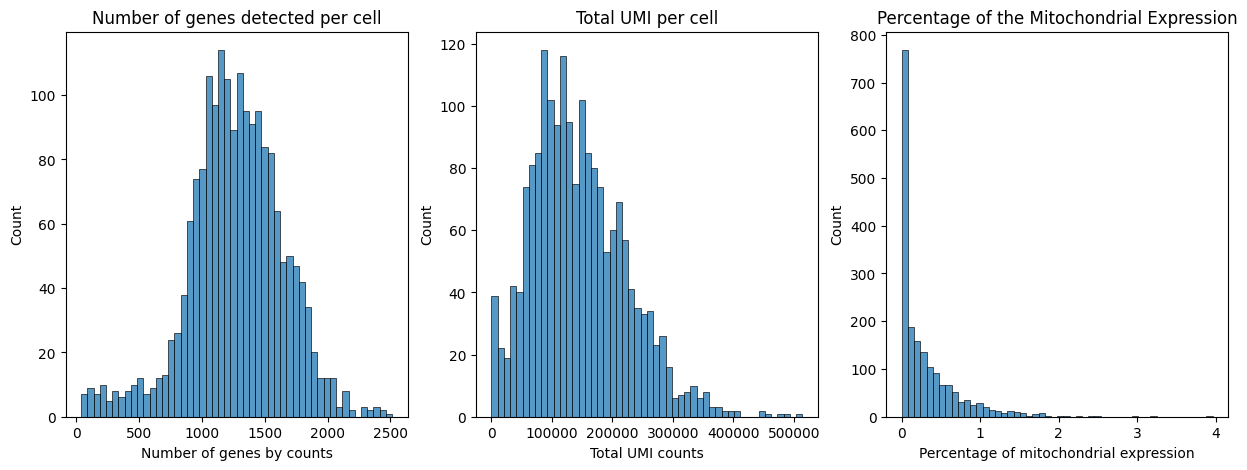

In [556]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.histplot(adata_glioblastoma_raw.obs["n_genes_by_counts"], bins=50, ax=axes[0])
axes[0].set_title("Number of genes detected per cell")
axes[0].set_xlabel("Number of genes by counts")
axes[0].set_ylabel("Count")

sns.histplot(adata_glioblastoma_raw.obs["total_counts"], bins=50, ax=axes[1])
axes[1].set_title("Total UMI per cell")
axes[1].set_xlabel("Total UMI counts")
axes[1].set_ylabel("Count")

sns.histplot(adata_glioblastoma_raw.obs["pct_mito"], bins=50, ax=axes[2])
axes[2].set_title("Percentage of the Mitochondrial Expression")
axes[2].set_xlabel("Percentage of mitochondrial expression")
axes[2].set_ylabel("Count")

plt.show()

In [557]:
# Display the first few rows of the .obs attribute as an HTML table
display(HTML(adata_glioblastoma_raw.obs.head().to_html()))

,disease_state,plate_id,tissue,patient_id,cell_type,neoplastic_state,diagnosis,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,mito_UMI_counts,pct_mito
index,,,,,,,,,,,,,,,,
GSM2243439,diagnosis: glioblastoma,plate id: 1001000173,tissue: Tumor,patient id: BT_S2,cell type: Neoplastic,neoplastic: Neoplastic,Neoplastic,1341,7.201916,159262,11.978314,65.554424,76.898016,89.034835,129.850235,0.081532
GSM2243444,diagnosis: glioblastoma,plate id: 1001000173,tissue: Tumor,patient id: BT_S2,cell type: Neoplastic,neoplastic: Neoplastic,Neoplastic,1456,7.284135,326321,12.695642,77.530281,83.443820,90.526005,2255.449219,0.691175
GSM2243445,diagnosis: glioblastoma,plate id: 1001000173,tissue: Tumor,patient id: BT_S2,cell type: Neoplastic,neoplastic: Neoplastic,Neoplastic,1849,7.522941,196996,12.190948,50.919931,59.767944,70.261123,1588.646240,0.806436
GSM2243447,diagnosis: glioblastoma,plate id: 1001000173,tissue: Tumor,patient id: BT_S2,cell type: Neoplastic,neoplastic: Neoplastic,Neoplastic,100,4.615121,90933,11.417895,99.950874,100.000009,100.000009,0.000000,0.000000
GSM2243452,diagnosis: glioblastoma,plate id: 1001000173,tissue: Tumor,patient id: BT_S2,cell type: Neoplastic,neoplastic: Neoplastic,Neoplastic,1788,7.489412,208278,12.246636,45.863893,56.620505,68.793036,615.426880,0.295483


#### Correlation

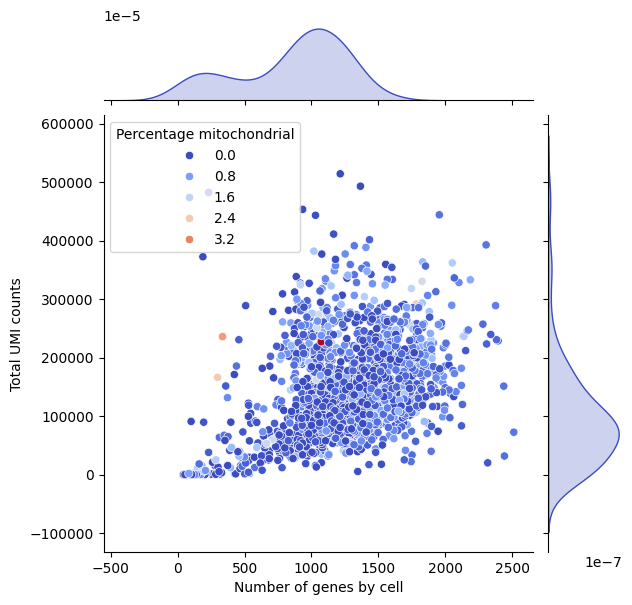

In [558]:
df = adata_glioblastoma_raw.obs[["n_genes_by_counts", "total_counts", "pct_mito"]].copy()
df.rename(columns={"n_genes_by_counts": "Number of genes by cell", 
                   "total_counts": "Total UMI counts", 
                   "pct_mito": "Percentage mitochondrial"}, inplace=True)

sns.jointplot(
    data=df,
    x="Number of genes by cell",
    y="Total UMI counts",
    hue="Percentage mitochondrial",
    palette="coolwarm",
    kind="scatter"
)

## Cell Filtering

`````{admonition} Why Do We Filter Cells?
:class: tip
We remove cells that are:  
1️⃣ **Low-quality or dead** → Few detected genes or low UMI counts.  
2️⃣ **Potential doublets** → Abnormally high UMI counts (two cells captured together).  
3️⃣ **Stressed or apoptotic** → High percentage of mitochondrial RNA.  
`````

Why These Thresholds?
min_genes = 200

Balances removing empty droplets (which typically have <100 genes) while retaining viable cells.

Conservative given your median genes/cell likely falls between 1,000–3,000.

max_genes = 5000

For glioblastoma, tumor cells often show high transcriptional complexity.

Prevents excluding genuine high-gene-count tumor cells while filtering obvious doublets (which would have extreme gene counts, e.g., >6,000).

min_counts = 1000

Ensures cells have enough UMIs for reliable gene expression quantification.

Typical 10x Genomics datasets average 10,000–50,000 UMIs/cell, so this is lenient.

max_mito = 20%

Cancer cells (especially glioblastoma) often have elevated mitochondrial activity.

Standard thresholds (5–10%) are too strict for tumor microenvironments.

In [559]:
# Filtering thresholds (adjusted for your dataset size)
min_genes = 200       # Minimum genes per cell (removes low-quality cells)
max_genes = 5000      # Upper limit (captures tumor cell complexity while excluding doublets)
min_counts = 1000     # Minimum UMIs/cell (ensures sufficient sequencing depth)
max_mito = 20         # Max mitochondrial % (higher tolerance for cancer cells)

# Apply filters
filtered_cells = (
    (adata_glioblastoma_raw.obs["n_genes_by_counts"] > min_genes) &
    (adata_glioblastoma_raw.obs["n_genes_by_counts"] < max_genes) &
    (adata_glioblastoma_raw.obs["total_counts"] > min_counts) &
    (adata_glioblastoma_raw.obs["pct_mito"] < max_mito)
)

adata_filtered = adata_glioblastoma_raw[filtered_cells].copy()

In [560]:
# Check retained cells/genes
print(f"Cells pre-filter: {adata_glioblastoma_raw.n_obs}, post-filter: {adata_filtered.n_obs}")
print(f"Genes pre-filter: {adata_glioblastoma_raw.n_vars}, post-filter: {adata_filtered.n_vars}")

Cells pre-filter: 1853, post-filter: 1823
Genes pre-filter: 7683, post-filter: 7683


C:\Users\henry\AppData\Local\Temp\ipykernel_9688\2847459098.py:24: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\henry\AppData\Local\Temp\ipykernel_9688\2847459098.py:24: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\henry\AppData\Local\Temp\ipykernel_9688\2847459098.py:24: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



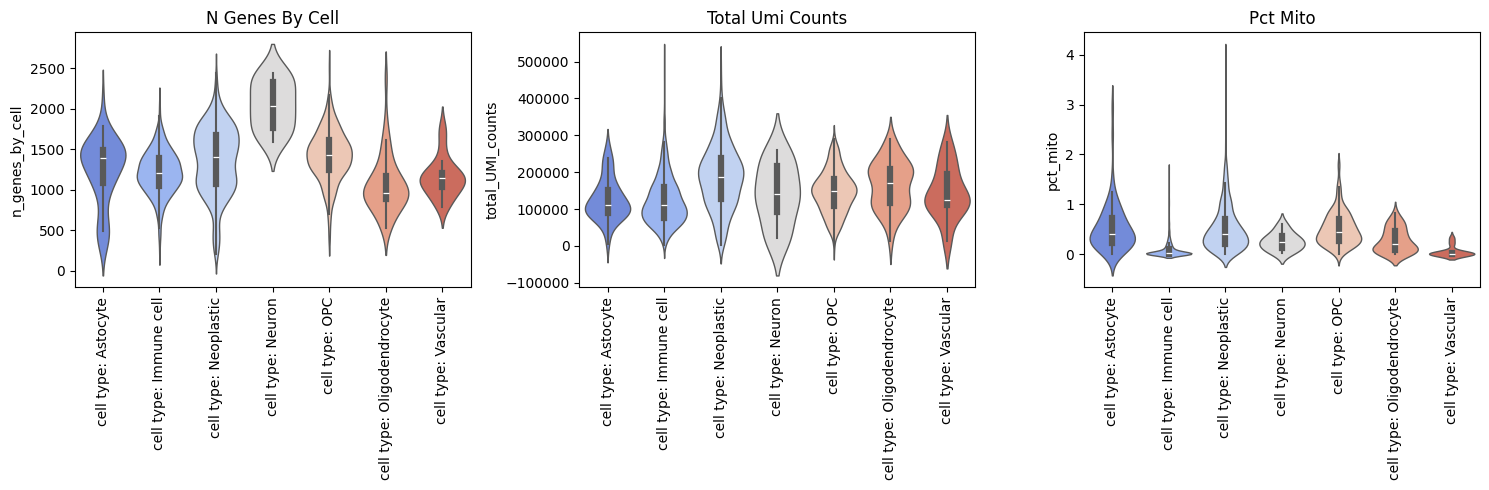

In [561]:
# Convert relevant data from adata_filtered to DataFrame
df = pd.DataFrame({
    'n_genes_by_cell': adata_filtered.obs['n_genes_by_counts'],  # Corrected column name
    'total_UMI_counts': adata_filtered.obs['total_counts'],      # Corrected column name
    'pct_mito': adata_filtered.obs['pct_mito'],
    'cell_type': adata_filtered.obs['cell_type']
})
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot each metric 
for ax, metric in zip(axes, ['n_genes_by_cell', 'total_UMI_counts', 'pct_mito']):
    sns.violinplot(
        data=df,
        x='cell_type',
        y=metric,
        hue='cell_type',  # Needed for palette
        palette='coolwarm',
        legend=False,     # Disables legend
        ax=ax,
        density_norm='width',  # Replaces deprecated 'scale'
        linewidth=1       # Makes violin borders more visible
    )
    ax.set_title(metric.replace('_', ' ').title())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_xlabel('')

plt.tight_layout()
plt.show()

## Doublets and Singlets in Single-Cell RNA-Seq (scRNA-Seq)

```{} What are the singlet and doublets?

In single-cell RNA sequencing (scRNA-Seq), the terms **"doublet"** and **"singlet"** refer to the nature of the captured cells in the experiment:

- **Singlet** → A single individual cell encapsulated in a droplet or captured in a well.
- **Doublet** → Two cells encapsulated together in the same droplet, which can lead to contaminated or mixed data in the analysis.
```

### 🔬 Why is it important to detect doublets?
Doublets can lead to **false interpretations** in the analysis, as they may appear to be a new cell type with a combined expression profile of two real cells. This affects:

- **Cell type identification** (they may seem like new cell types that do not actually exist).
- **Analysis of cellular subpopulations**.
- **Inference of cell relationships and trajectories**.

In [562]:
# Extract counts matrix (assuming adata_filtered.X contains raw counts)
counts_matrix = adata_filtered.X

In [563]:
scrub = scr.Scrublet(counts_matrix, expected_doublet_rate=0.015) # Question for achim abut this range

Expected Doublet Rate Calculation

For droplet-based single-cell RNA sequencing (e.g., 10x Genomics), the expected doublet rate follows a linear relationship with cell loading density:**Recommended Doublet Detection Threshold for Your Data**, Where:
- **0.0008** is the empirical coefficient representing ~0.8% doublets per 1,000 cells
- This value comes from controlled experimental measurements

**1. Expected Doublet Rate Calculation**  

For **1,853 cells**, the estimated doublet rate is:  

$$\text{Expected Doublet Rate} = 1,853 \times 0.008 = 1.5\% $$

In [564]:
doublet_scores, predicted_doublets = scrub.scrub_doublets()

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.16
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 15.4%
Overall doublet rate:
	Expected   = 1.5%
	Estimated  = 0.0%
Elapsed time: 1.7 seconds


In [565]:
adata_filtered.obs['doublet_score'] = doublet_scores
adata_filtered.obs['predicted_doublet'] = predicted_doublets

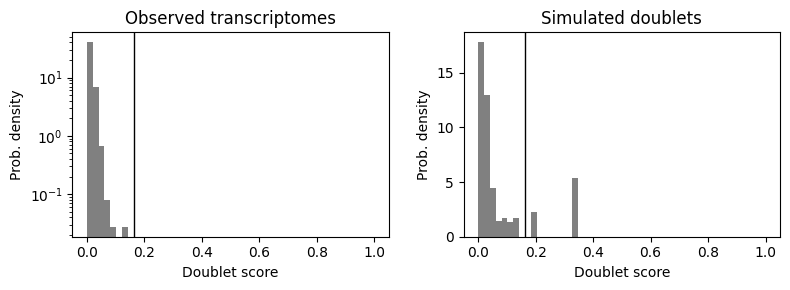

In [566]:
scrub.plot_histogram()
plt.show()


In [567]:
print(f"Detected doublet rate: {100*predicted_doublets.mean():.1f}%")
print(f"Number of predicted doublets: {predicted_doublets.sum()}")

Detected doublet rate: 0.0%
Number of predicted doublets: 0


Visual inspection of scores vs. QC metrics

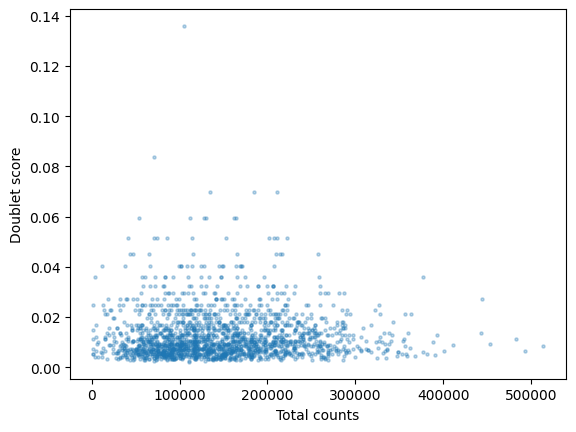

In [568]:
plt.scatter(adata_filtered.obs['total_counts'], adata_filtered.obs['doublet_score'], s=5, alpha=0.3)
plt.xlabel('Total counts')
plt.ylabel('Doublet score')
plt.show()


In [569]:
# Filtering and visualization
print(f"Before filtering doublets: {adata_filtered.n_obs} cells")
adata_filtered = adata_filtered[~adata_filtered.obs['predicted_doublet'], :].copy()
print(f"After filtering doublets: {adata_filtered.n_obs} cells")

Before filtering doublets: 1823 cells
After filtering doublets: 1823 cells


         Falling back to preprocessing with `sc.pp.pca` and default params.


c:\Users\henry\miniconda3\envs\ml_venv\lib\site-packages\anndata\_core\anndata.py:430: FutureWarning:

The dtype argument is deprecated and will be removed in late 2024.



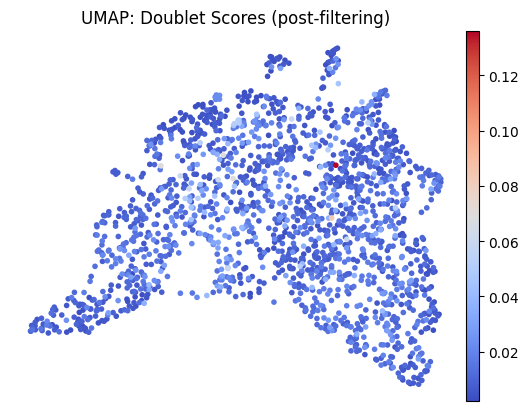

In [570]:
# Visualize remaining cells in UMAP
sc.pp.neighbors(adata_filtered)
sc.tl.umap(adata_filtered)

sc.pl.umap(adata_filtered, 
           color='doublet_score', 
           color_map='coolwarm', 
           title='UMAP: Doublet Scores (post-filtering)',
           frameon=False)

In [571]:
# adata_filtered.write('your_cleaned_data.h5ad')

## Data Normalization, Transformation and Standarization

  In this step we have to normalize the **total UMI counts per cell**. This means each cell's total count is rescaled to **10,000**, ensuring comparability across cells.  To get that we apply a **log transformation** to all gene expression values in `adata_glioblastoma_filtered.X`.  

***Variables normalized*** 
- The **gene expression values** (UMI counts) were normalized.  
- Other metadata variables (such as `n_counts_by_cell`, `total_counts`, or `pct_mito`) were **not modified**—these remain in `adata_filtered.obs`.  



In [572]:
# Normalize to median total counts (CPM-like normalization)
sc.pp.normalize_total(adata_filtered, target_sum=1e4)

### **Transformation**

***Log Transformation Formula*** 

The log transformation used is:  

$$ \text{log1p}(x) = \log(1 + x) $$  

This helps stabilize variance and make the data more normally distributed.

In [573]:
# Log-transform the normalized data (log1p = log(1+x))
sc.pp.log1p(adata_filtered)

### **Select the most highly variable genes**

Uses the Seurat v3 method to find highly variable genes. It selects the top 2,000 most variable genes for further analysis.

In [574]:
# Identify highly variable genes (HVGs)
sc.pp.highly_variable_genes(
    adata_filtered,
    n_top_genes=2000,          # Keep top 2.500 variable genes
    flavor='seurat',           # Method used by Seurat (mean-variance relationship)
    subset=True                # Keep only HVGs for downstream analysis
)


c:\Users\henry\miniconda3\envs\ml_venv\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:216: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



### **Standarization**

```{admonition} Why Standardize?
Standardization transforms gene expression values to:

- Center and scale features: Each gene has mean = 0 and variance = 1

- Prevents highly expressed genes from dominating analysis:

- Improve PCA performance: Ensures all genes contribute equally to principal components

- Enable distance-based methods: Clustering (e.g., Leiden) and visualization (UMAP/t-SNE) require comparable feature scales
```

For each gene g:

$$\text{Scaled Expression} = \frac{X_{g} - \mu_{g}}{\sigma_{g}}$$

Where:
$$X_{g}: \text{Log-normalized expression}$$ 
$$\mu_{g}: \text{Mean expression across cells}$$  
$$\sigma_{g}: \text{Standard deviation}$$

In [575]:
# Scale to unit variance and zero mean (z-score)
sc.pp.scale(adata_filtered, max_value=10)

In [576]:
# Verify results
print(adata_filtered)
print(f"Number of HVGs selected: {adata_filtered.n_vars}")

AnnData object with n_obs × n_vars = 1823 × 2000
    obs: 'disease_state', 'plate_id', 'tissue', 'patient_id', 'cell_type', 'neoplastic_state', 'diagnosis', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'mito_UMI_counts', 'pct_mito', 'doublet_score', 'predicted_doublet'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'Mapped_Gene', 'Is_Mitochondrial', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'neighbors', 'umap', 'log1p', 'hvg'
    obsm: 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'
Number of HVGs selected: 2000


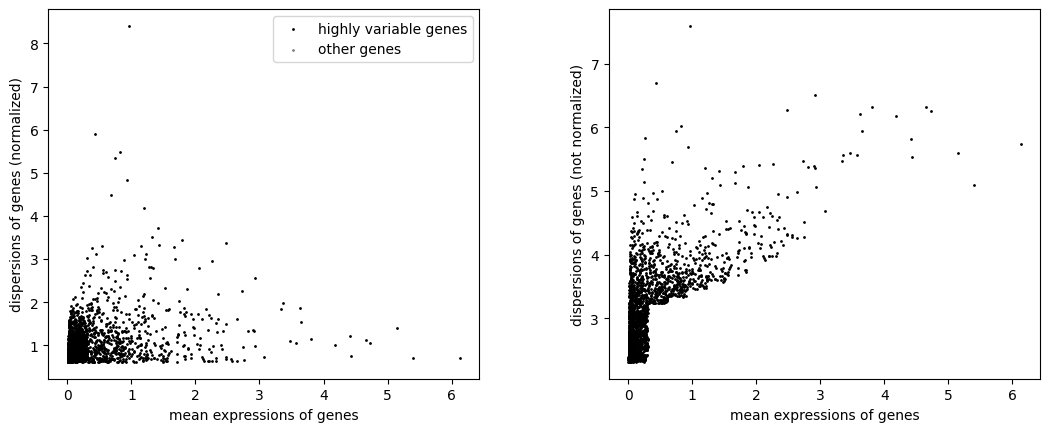

In [577]:
sc.pl.highly_variable_genes(adata_filtered)


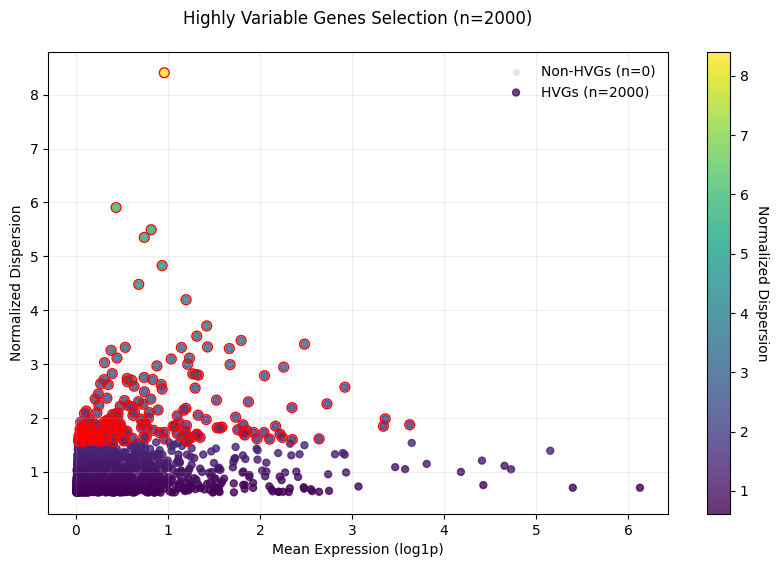

In [578]:
# Create a publication-quality HVG plot
plt.figure(figsize=(10, 6))

# Plot non-HVGs in light gray
plt.scatter(
    x=adata_filtered.var[~adata_filtered.var['highly_variable']]['means'],
    y=adata_filtered.var[~adata_filtered.var['highly_variable']]['dispersions_norm'],
    c='lightgray',
    s=15,
    alpha=0.5,
    label='Non-HVGs (n={})'.format(adata_filtered.n_vars - 2000)
)

# Plot HVGs with dispersion-based coloring
hvg_subset = adata_filtered.var[adata_filtered.var['highly_variable']]
scatter = plt.scatter(
    x=hvg_subset['means'],
    y=hvg_subset['dispersions_norm'],
    c=hvg_subset['dispersions_norm'],  # Color by dispersion value
    cmap='viridis',
    s=25,
    alpha=0.8,
    label='HVGs (n=2000)'
)

# Add colorbar for dispersion values
cbar = plt.colorbar(scatter)
cbar.set_label('Normalized Dispersion', rotation=270, labelpad=15)

# Formatting
plt.title('Highly Variable Genes Selection (n=2000)', pad=20)
plt.xlabel('Mean Expression (log1p)')
plt.ylabel('Normalized Dispersion')
plt.legend(frameon=False)
plt.grid(True, alpha=0.2)

# Highlight the top 10% most dispersed genes
top_10_pct = hvg_subset.nlargest(200, 'dispersions_norm')
plt.scatter(
    x=top_10_pct['means'],
    y=top_10_pct['dispersions_norm'],
    edgecolors='red',
    facecolors='none',
    s=50,
    linewidths=1,
    label='Top 10% HVGs'
)

plt.show()

## Dimensionality reduction

### Using VAE + GAT

```{admonition} What is a variational Autoencoder (VAE)
A Variational Autoencoder (VAE) is a type of deep generative model that learns a probabilistic representation of data. It is widely used for dimensionality reduction, data generation, and representation learning. The VAE is particularly useful for scRNA-seq data because it can handle sparsity and noise while learning meaningful low-dimensional embeddings of cells.
```

*The VAE consists of two main components:*

1. **Encoder**: Maps the input data to a latent space (a lower-dimensional representation).
Outputs a mean (μ) and variance (σ2) for each latent variable, defining a probability distribution.
2. **Decoder**: Reconstructs the input data from the latent space by sampling from the learned distribution.
3. **Loss Function:** Combines 2 terms:
    - Reconstruction Loss: Measures how well the decoder reconstructs the input data.
    - KL Divergence: Ensures the latent space follows a standard normal distribution, enabling smooth sampling.


```{admonition} What is a Graph Attention Network?
A Graph Attention Network (GAT) is a type of neural network designed to operate on graph-structured data. It extends traditional graph neural networks (GNNs) by incorporating attention mechanisms, allowing the model to focus on the most relevant nodes and edges in the graph.
```

1. **Graph Representation:** A graph consists of nodes (e.g., genes or cells) and edges (e.g., interactions or similarities between nodes).
2. **Attention Mechanism:** For each node, the GAT computes attention scores for its neighbors, determining how much influence each neighbor should have.
These scores are learned during training and are used to weight the contributions of neighboring nodes.

#### Why Combine VAE and GAT?

By combining a VAE with a GAT, we can:

- Use the VAE to learn a low-dimensional, probabilistic representation of cells.
- Use the GAT to incorporate prior knowledge (e.g., gene interaction networks) and highlight important regulatory relationships.
- Generate interpretable embeddings where attention weights identify key driver genes or interactions.

In [579]:
# Install torch_geometric if not already installed
%pip install torch-geometric

import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GATConv
from torch_geometric.data import Data

In [580]:
X = torch.tensor(adata_filtered.X, dtype = torch.float32)
n_cells, n_genes = X.shape

In [581]:
print(X[:5, :5])

tensor([[-0.3085, -0.0856, -0.5903, -0.0564, -0.1009],
        [-0.3085, -0.0856, -0.5903, -0.0564, -0.1009],
        [-0.3085, -0.0856, -0.5903, -0.0564, -0.1009],
        [ 1.8309, -0.0856, -0.5903, -0.0564, -0.1009],
        [ 1.4749, -0.0856, -0.5903, -0.0564, -0.1009]])


In [582]:
# Store scaling parameters for inverse transform
data_mean = torch.mean(X, dim=0)
data_std = torch.std(X, dim=0)

```{admonition} What is an Adjacency Matrix?
An adjacency matrix is a square matrix that represents a graph. In the context of a gene interaction network:

- Nodes: Represent genes.
- Edges: Represent interactions or relationships between genes (e.g., regulatory interactions, co-expression, or physical interactions).
```

The adjacency matrix is:

- Binary: If there is an edge between two genes, the value is 1; otherwise, it is 0.
- Weighted: If the strength of the interaction is known, the value can be a weight (e.g., confidence score).

In [583]:
print("Number of genes:", n_genes)

Number of genes: 2000


In [584]:
# Create correlation-based adjacency matrix
# Convert data to numpy for correlation calculation
gene_expression = X.numpy()

In [585]:
# Calculate correlation matrix
correlation_mmatrix = np.corrcoef(gene_expression.T)

using Threshold = 0.5 for the following reasons:

It balances the number of connections (233) and sparsity (0.01%).
It avoids including too many spurious correlations while retaining meaningful relationships.
It is computationally efficient for the GAT model.

In [586]:
def analyze_threshold(correlation_matrix, threshold):
    adjacency_matrix = (np.abs(correlation_matrix) > threshold).astype(int)
    np.fill_diagonal(adjacency_matrix, 0)

    total_possible_connections = len(correlation_matrix) * (len(correlation_matrix) - 1) / 2
    actual_connections = np.sum(adjacency_matrix) / 2

    return {
        'threshold': threshold,
        'connections': actual_connections,
        'sparsity': actual_connections / total_possible_connections * 100
    }

In [587]:

# Calculate correlation matrix if not already done
gene_expression = X.numpy()
correlation_matrix = np.corrcoef(gene_expression.T)

# Test different thresholds
thresholds = [0.3, 0.5, 0.7, 0.9]
results = []

for thresh in thresholds:
    results.append(analyze_threshold(correlation_matrix, thresh))

# Create DataFrame with results
df_results = pd.DataFrame(results)
print("\nThreshold Analysis:")
print(df_results)


Threshold Analysis:
   threshold  connections  sparsity
0        0.3       2222.0  0.111156
1        0.5        233.0  0.011656
2        0.7         32.0  0.001601
3        0.9          2.0  0.000100


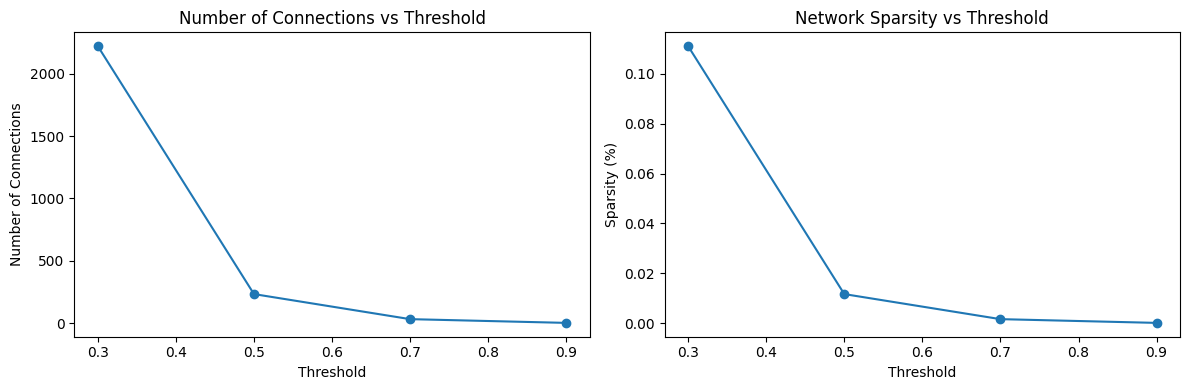

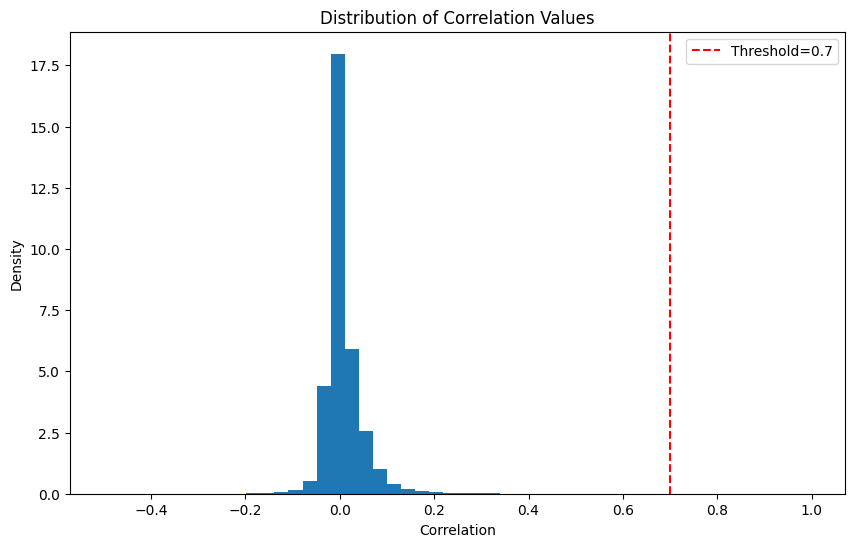

In [58]:
# Visualize the effect of different thresholds
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(df_results['threshold'], df_results['connections'], 'o-')
plt.title('Number of Connections vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Number of Connections')

plt.subplot(122)
plt.plot(df_results['threshold'], df_results['sparsity'], 'o-')
plt.title('Network Sparsity vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Sparsity (%)')
plt.tight_layout()
plt.show()

# Distribution of correlation values
plt.figure(figsize=(10, 6))
plt.hist(correlation_matrix[np.triu_indices(len(correlation_matrix), k=1)],
         bins=50, density=True)
plt.title('Distribution of Correlation Values')
plt.xlabel('Correlation')
plt.ylabel('Density')
plt.axvline(x=0.7, color='r', linestyle='--', label='Threshold=0.7')
plt.legend()
plt.show()

#### Create ajacency matrix

In [588]:
treshold = 0.5
adjacency_matrix = (np.abs(correlation_matrix) > treshold).astype(int)
np.fill_diagonal(adjacency_matrix,0)

# Convert to PyTorch Geometric edge_index format
edge_index = torch.nonzero(torch.tensor(adjacency_matrix)).t() 

In [589]:
# We verify the dimensions
print("Shape of X:", X.shape)
print("Edge index range:", edge_index.min().item(), "to", edge_index.max().item())
print("Number of edges:", edge_index.shape[1])

# And keep that edge_index not to be out of range
mask = (edge_index[0] < X.shape[0]) & (edge_index[1] < X.shape[0])
edge_index = edge_index[:, mask]

print("\nAfter filtering:")
print("Edge index range:", edge_index.min().item(), "to", edge_index.max().item())
print("Number of edges:", edge_index.shape[1])

Shape of X: torch.Size([1823, 2000])
Edge index range: 5 to 1979
Number of edges: 466

After filtering:
Edge index range: 5 to 1813
Number of edges: 336


#### GPU

In [134]:
# pip install tensorflow==2.10

In [135]:
import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from tqdm import tqdm  # Para mostrar el progreso
import numpy as np
import matplotlib.pyplot as plt


# Check TensorFlow version
print("TensorFlow version:", tf.__version__)

# Check if TensorFlow detects the GPU
if tf.config.list_physical_devices('GPU'):
    print("TensorFlow is using the GPU.")
    print("GPU details:", tf.config.list_physical_devices('GPU'))
else:
    print("TensorFlow is not using the GPU. Check your installation.")

TensorFlow version: 2.10.0
TensorFlow is using the GPU.
GPU details: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


#### VAE + GAT

In [ ]:
class VAE_GAT(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_heads, dropout_rate=0.1):
        super(VAE_GAT, self).__init__()

        # Encoder
        self.gat1 = GATConv(input_dim, hidden_dim, heads=num_heads, dropout=dropout_rate)
        self.gat2 = GATConv(hidden_dim * num_heads, hidden_dim, heads=1, dropout=dropout_rate)

        # Latent space
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_var = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim * 2)
        self.fc3 = nn.Linear(hidden_dim * 2, input_dim)

        self.dropout = nn.Dropout(dropout_rate)

    def encode(self, x, edge_index):
        # Print shapes for debugging
        if self.training:
            print(f"Input x shape: {x.shape}")
            print(f"Edge index shape: {edge_index.shape}")

        x = F.elu(self.gat1(x, edge_index))
        x = self.dropout(x)
        x = F.elu(self.gat2(x, edge_index))

        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        if self.training:
            std = torch.exp(0.5 * log_var)
            eps = torch.randn_like(std)
            return mu + eps * std
        else:
            return mu

    def decode(self, z):
        h = F.elu(self.fc1(z))
        h = self.dropout(h)
        h = F.elu(self.fc2(h))
        h = self.dropout(h)
        return self.fc3(h)

    def forward(self, x, edge_index):
        mu, log_var = self.encode(x, edge_index)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

def loss_function(recon_x, x, mu, log_var, beta=0.5):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    total_loss = recon_loss + beta * kl_loss

    # Return individual losses for monitoring
    return total_loss, recon_loss, kl_loss

def train_model(model, X, edge_index, optimizer, num_epochs):
    model.train()
    losses = []
    recon_losses = []
    kl_losses = []

    pbar = tqdm(range(num_epochs), desc='Training')

    for epoch in pbar:
        optimizer.zero_grad()

        # Forward pass
        recon_batch, mu, log_var = model(X, edge_index)

        # Calculate losses
        loss, recon_loss, kl_loss = loss_function(recon_batch, X, mu, log_var)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Store losses
        losses.append(loss.item())
        recon_losses.append(recon_loss.item())
        kl_losses.append(kl_loss.item())

        # Update progress bar
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'recon_loss': f'{recon_loss.item():.4f}',
            'kl_loss': f'{kl_loss.item():.4f}'
        })

        # Print detailed info every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f'\nEpoch [{epoch+1}/{num_epochs}]')
            print(f'Total Loss: {loss.item():.4f}')
            print(f'Reconstruction Loss: {recon_loss.item():.4f}')
            print(f'KL Loss: {kl_loss.item():.4f}')

    return losses, recon_losses, kl_losses

In [88]:
# Configurar hiperparámetros
input_dim = n_genes
hidden_dim = 128
latent_dim = 32
num_heads = 4
learning_rate = 1e-3
num_epochs = 200
batch_size = 32

# Initialize model and optimizer
print("\nInitializing model...")
model = VAE_GAT(input_dim=input_dim,
                hidden_dim=hidden_dim,
                latent_dim=latent_dim,
                num_heads=num_heads)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
print("\nStarting training...")
losses, recon_losses, kl_losses = train_model(model, X, edge_index, optimizer, num_epochs)

# Get embeddings
print("\nGenerating embeddings...")
model.eval()
with torch.no_grad():
    _, mu, _ = model(X, edge_index)
    embeddings = mu.numpy()

print("Embeddings shape:", embeddings.shape)


Initializing model...

Starting training...


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:   0%|          | 1/200 [00:00<00:49,  4.06it/s, loss=2981520.0000, recon_loss=2973778.5000, kl_loss=15482.8916]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:   1%|          | 2/200 [00:00<00:54,  3.62it/s, loss=2930636.5000, recon_loss=2924622.5000, kl_loss=12027.8184]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:   2%|▏         | 4/200 [00:00<00:44,  4.45it/s, loss=2880033.5000, recon_loss=2874616.0000, kl_loss=10835.1553]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])
Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:   2%|▎         | 5/200 [00:01<00:43,  4.49it/s, loss=2863060.7500, recon_loss=2857477.2500, kl_loss=11166.8408]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:   3%|▎         | 6/200 [00:01<00:44,  4.31it/s, loss=2847303.0000, recon_loss=2840963.2500, kl_loss=12679.5605]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:   4%|▎         | 7/200 [00:01<00:48,  4.02it/s, loss=2834285.7500, recon_loss=2826876.5000, kl_loss=14818.6738]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:   4%|▍         | 9/200 [00:02<00:42,  4.54it/s, loss=2807108.7500, recon_loss=2796166.5000, kl_loss=21884.4922]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])
Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:   5%|▌         | 10/200 [00:02<00:43,  4.36it/s, loss=2793363.7500, recon_loss=2779575.5000, kl_loss=27576.6719]


Epoch [10/200]
Total Loss: 2793363.7500
Reconstruction Loss: 2779575.5000
KL Loss: 27576.6719
Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:   6%|▌         | 11/200 [00:02<00:42,  4.42it/s, loss=2784199.2500, recon_loss=2768149.2500, kl_loss=32100.2285]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:   6%|▋         | 13/200 [00:02<00:40,  4.64it/s, loss=2766114.7500, recon_loss=2748755.2500, kl_loss=34719.0430]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])
Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:   7%|▋         | 14/200 [00:03<00:39,  4.68it/s, loss=2756449.5000, recon_loss=2739315.5000, kl_loss=34268.0234]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:   8%|▊         | 15/200 [00:03<00:38,  4.75it/s, loss=2750901.0000, recon_loss=2734068.7500, kl_loss=33664.4141]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:   8%|▊         | 16/200 [00:03<00:40,  4.55it/s, loss=2738183.5000, recon_loss=2719279.5000, kl_loss=37807.8633]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:   8%|▊         | 17/200 [00:03<00:38,  4.70it/s, loss=2738183.5000, recon_loss=2719279.5000, kl_loss=37807.8633]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:   9%|▉         | 18/200 [00:04<00:38,  4.70it/s, loss=2735160.2500, recon_loss=2715533.7500, kl_loss=39253.0000]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  10%|▉         | 19/200 [00:04<00:39,  4.63it/s, loss=2731574.5000, recon_loss=2711363.5000, kl_loss=40421.8086]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  10%|█         | 20/200 [00:04<00:43,  4.11it/s, loss=2723235.7500, recon_loss=2702085.7500, kl_loss=42300.1797]


Epoch [20/200]
Total Loss: 2723235.7500
Reconstruction Loss: 2702085.7500
KL Loss: 42300.1797
Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  10%|█         | 21/200 [00:04<00:44,  4.06it/s, loss=2717261.2500, recon_loss=2695560.7500, kl_loss=43400.8906]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  11%|█         | 22/200 [00:05<00:42,  4.18it/s, loss=2712881.2500, recon_loss=2691420.7500, kl_loss=42921.0625]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  12%|█▏        | 23/200 [00:05<00:42,  4.21it/s, loss=2706333.7500, recon_loss=2685016.7500, kl_loss=42634.2266]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  12%|█▎        | 25/200 [00:05<00:36,  4.75it/s, loss=2697642.0000, recon_loss=2675126.0000, kl_loss=45032.0391]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])
Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  13%|█▎        | 26/200 [00:05<00:37,  4.62it/s, loss=2697249.2500, recon_loss=2674972.7500, kl_loss=44552.7578]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  14%|█▎        | 27/200 [00:06<00:39,  4.33it/s, loss=2693489.7500, recon_loss=2671064.5000, kl_loss=44850.5234]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  14%|█▍        | 28/200 [00:06<00:40,  4.21it/s, loss=2690123.2500, recon_loss=2667481.5000, kl_loss=45283.6719]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  14%|█▍        | 29/200 [00:06<00:40,  4.21it/s, loss=2682211.0000, recon_loss=2658256.0000, kl_loss=47910.2266]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  15%|█▌        | 30/200 [00:06<00:39,  4.28it/s, loss=2680297.2500, recon_loss=2656333.7500, kl_loss=47926.7773]


Epoch [30/200]
Total Loss: 2680297.2500
Reconstruction Loss: 2656333.7500
KL Loss: 47926.7773
Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  16%|█▌        | 31/200 [00:07<00:38,  4.38it/s, loss=2678072.2500, recon_loss=2653985.2500, kl_loss=48173.9922]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  16%|█▌        | 32/200 [00:07<00:39,  4.28it/s, loss=2669756.2500, recon_loss=2644731.0000, kl_loss=50050.6406]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  16%|█▋        | 33/200 [00:07<00:40,  4.16it/s, loss=2668236.5000, recon_loss=2643022.0000, kl_loss=50428.7930]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  17%|█▋        | 34/200 [00:08<00:38,  4.30it/s, loss=2658570.0000, recon_loss=2632076.0000, kl_loss=52988.1875]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  18%|█▊        | 35/200 [00:08<00:37,  4.40it/s, loss=2663697.0000, recon_loss=2637542.0000, kl_loss=52309.9766]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  18%|█▊        | 36/200 [00:08<00:36,  4.54it/s, loss=2663697.0000, recon_loss=2637542.0000, kl_loss=52309.9766]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  18%|█▊        | 37/200 [00:08<00:35,  4.55it/s, loss=2650423.7500, recon_loss=2622703.2500, kl_loss=55441.1875]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  19%|█▉        | 38/200 [00:08<00:36,  4.40it/s, loss=2649180.7500, recon_loss=2621328.0000, kl_loss=55705.2578]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  20%|█▉        | 39/200 [00:08<00:37,  4.34it/s, loss=2649877.5000, recon_loss=2622196.0000, kl_loss=55362.9922]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  20%|██        | 40/200 [00:09<00:37,  4.27it/s, loss=2643987.2500, recon_loss=2615704.7500, kl_loss=56565.0234]


Epoch [40/200]
Total Loss: 2643987.2500
Reconstruction Loss: 2615704.7500
KL Loss: 56565.0234
Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  20%|██        | 41/200 [00:09<00:37,  4.22it/s, loss=2636133.0000, recon_loss=2606961.2500, kl_loss=58343.5586]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  21%|██        | 42/200 [00:09<00:37,  4.17it/s, loss=2641586.7500, recon_loss=2612991.0000, kl_loss=57191.5234]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  22%|██▏       | 43/200 [00:09<00:36,  4.29it/s, loss=2641602.2500, recon_loss=2612824.5000, kl_loss=57555.3594]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  22%|██▏       | 44/200 [00:10<00:36,  4.28it/s, loss=2636646.0000, recon_loss=2607914.7500, kl_loss=57462.6367]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  22%|██▎       | 45/200 [00:10<00:36,  4.20it/s, loss=2627612.0000, recon_loss=2597829.2500, kl_loss=59565.4922]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  23%|██▎       | 46/200 [00:10<00:37,  4.13it/s, loss=2623806.0000, recon_loss=2593024.5000, kl_loss=61563.0078]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  24%|██▎       | 47/200 [00:11<00:38,  4.00it/s, loss=2619670.0000, recon_loss=2587891.2500, kl_loss=63557.4609]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  24%|██▍       | 49/200 [00:11<00:31,  4.82it/s, loss=2621413.0000, recon_loss=2589651.2500, kl_loss=63523.4062]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])
Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  25%|██▌       | 50/200 [00:11<00:29,  5.11it/s, loss=2619060.7500, recon_loss=2586498.5000, kl_loss=65124.7461]


Epoch [50/200]
Total Loss: 2619060.7500
Reconstruction Loss: 2586498.5000
KL Loss: 65124.7461
Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  26%|██▌       | 51/200 [00:11<00:29,  5.03it/s, loss=2621695.0000, recon_loss=2589493.2500, kl_loss=64403.7344]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  26%|██▌       | 52/200 [00:11<00:29,  4.94it/s, loss=2615198.2500, recon_loss=2582497.0000, kl_loss=65402.5234]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  26%|██▋       | 53/200 [00:12<00:31,  4.70it/s, loss=2615148.0000, recon_loss=2582140.2500, kl_loss=66015.5156]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  27%|██▋       | 54/200 [00:12<00:33,  4.41it/s, loss=2611792.0000, recon_loss=2578772.7500, kl_loss=66038.2969]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  28%|██▊       | 55/200 [00:12<00:33,  4.36it/s, loss=2614581.5000, recon_loss=2582435.7500, kl_loss=64291.6641]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  28%|██▊       | 56/200 [00:12<00:33,  4.33it/s, loss=2602567.0000, recon_loss=2568550.7500, kl_loss=68032.4375]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  28%|██▊       | 57/200 [00:13<00:31,  4.60it/s, loss=2604026.7500, recon_loss=2570257.5000, kl_loss=67538.6250]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  30%|██▉       | 59/200 [00:13<00:27,  5.10it/s, loss=2596736.7500, recon_loss=2561611.0000, kl_loss=70251.5469]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])
Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  30%|███       | 61/200 [00:13<00:26,  5.32it/s, loss=2601062.0000, recon_loss=2565615.0000, kl_loss=70894.0078]


Epoch [60/200]
Total Loss: 2600808.7500
Reconstruction Loss: 2566763.5000
KL Loss: 68090.5625
Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])
Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  32%|███▏      | 63/200 [00:14<00:23,  5.77it/s, loss=2593708.7500, recon_loss=2557825.7500, kl_loss=71765.9219]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])
Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  32%|███▎      | 65/200 [00:14<00:23,  5.71it/s, loss=2587392.7500, recon_loss=2550560.2500, kl_loss=73664.8125]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])
Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  33%|███▎      | 66/200 [00:14<00:25,  5.29it/s, loss=2594843.7500, recon_loss=2559484.5000, kl_loss=70718.5625]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  34%|███▎      | 67/200 [00:14<00:26,  5.07it/s, loss=2581519.0000, recon_loss=2543888.2500, kl_loss=75261.5156]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  34%|███▍      | 69/200 [00:15<00:24,  5.28it/s, loss=2593997.5000, recon_loss=2557027.0000, kl_loss=73940.9688]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  35%|███▌      | 70/200 [00:15<00:24,  5.37it/s, loss=2586452.5000, recon_loss=2548865.5000, kl_loss=75174.2500]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])

Epoch [70/200]
Total Loss: 2586452.5000
Reconstruction Loss: 2548865.5000
KL Loss: 75174.2500
Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  36%|███▌      | 72/200 [00:15<00:22,  5.61it/s, loss=2581148.5000, recon_loss=2543401.5000, kl_loss=75494.2500]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])
Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  37%|███▋      | 74/200 [00:16<00:21,  5.79it/s, loss=2578732.2500, recon_loss=2540871.5000, kl_loss=75721.6484]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])
Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  38%|███▊      | 75/200 [00:16<00:22,  5.62it/s, loss=2585171.5000, recon_loss=2547774.7500, kl_loss=74793.2500]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  38%|███▊      | 76/200 [00:16<00:23,  5.27it/s, loss=2579944.2500, recon_loss=2541945.0000, kl_loss=75998.4844]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  38%|███▊      | 77/200 [00:16<00:23,  5.15it/s, loss=2570858.2500, recon_loss=2531707.7500, kl_loss=78300.9688]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  39%|███▉      | 78/200 [00:16<00:24,  4.99it/s, loss=2572888.7500, recon_loss=2534244.0000, kl_loss=77289.4062]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  40%|████      | 80/200 [00:17<00:23,  5.07it/s, loss=2572911.7500, recon_loss=2533939.0000, kl_loss=77945.3594]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])

Epoch [80/200]
Total Loss: 2572911.7500
Reconstruction Loss: 2533939.0000
KL Loss: 77945.3594
Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  40%|████      | 81/200 [00:17<00:25,  4.70it/s, loss=2568204.5000, recon_loss=2528499.5000, kl_loss=79409.9219]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  41%|████      | 82/200 [00:17<00:25,  4.54it/s, loss=2565435.7500, recon_loss=2525837.0000, kl_loss=79197.7109]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  42%|████▏     | 84/200 [00:18<00:23,  4.93it/s, loss=2557076.2500, recon_loss=2515564.7500, kl_loss=83023.0781]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])
Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  42%|████▎     | 85/200 [00:18<00:26,  4.29it/s, loss=2561754.5000, recon_loss=2521502.7500, kl_loss=80503.2812]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  43%|████▎     | 86/200 [00:18<00:28,  3.99it/s, loss=2563010.0000, recon_loss=2522533.5000, kl_loss=80953.0312]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  44%|████▎     | 87/200 [00:19<00:30,  3.73it/s, loss=2560428.5000, recon_loss=2519751.7500, kl_loss=81353.5781]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  44%|████▍     | 88/200 [00:19<00:30,  3.64it/s, loss=2557673.0000, recon_loss=2516220.5000, kl_loss=82904.9844]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  44%|████▍     | 89/200 [00:19<00:31,  3.53it/s, loss=2560594.5000, recon_loss=2519716.7500, kl_loss=81755.4766]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  45%|████▌     | 90/200 [00:20<00:35,  3.14it/s, loss=2551011.5000, recon_loss=2508214.5000, kl_loss=85593.9219]


Epoch [90/200]
Total Loss: 2551011.5000
Reconstruction Loss: 2508214.5000
KL Loss: 85593.9219
Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  46%|████▌     | 91/200 [00:20<00:35,  3.07it/s, loss=2553181.5000, recon_loss=2511455.5000, kl_loss=83452.0547]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  46%|████▌     | 92/200 [00:20<00:37,  2.90it/s, loss=2559799.2500, recon_loss=2518750.5000, kl_loss=82097.5859]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  46%|████▋     | 93/200 [00:21<00:38,  2.79it/s, loss=2558644.5000, recon_loss=2516656.7500, kl_loss=83975.6875]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  47%|████▋     | 94/200 [00:21<00:34,  3.09it/s, loss=2548627.7500, recon_loss=2505845.5000, kl_loss=85564.6406]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  48%|████▊     | 95/200 [00:21<00:30,  3.43it/s, loss=2548627.7500, recon_loss=2505845.5000, kl_loss=85564.6406]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  48%|████▊     | 96/200 [00:21<00:29,  3.56it/s, loss=2546104.5000, recon_loss=2503596.2500, kl_loss=85016.3203]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  48%|████▊     | 97/200 [00:22<00:27,  3.71it/s, loss=2553405.2500, recon_loss=2511502.0000, kl_loss=83806.6094]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  49%|████▉     | 98/200 [00:22<00:26,  3.85it/s, loss=2541690.5000, recon_loss=2498318.7500, kl_loss=86743.4531]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  50%|████▉     | 99/200 [00:22<00:26,  3.85it/s, loss=2560297.5000, recon_loss=2519183.7500, kl_loss=82227.4375]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  50%|█████     | 100/200 [00:22<00:25,  3.99it/s, loss=2543136.7500, recon_loss=2499657.7500, kl_loss=86957.9297]


Epoch [100/200]
Total Loss: 2543136.7500
Reconstruction Loss: 2499657.7500
KL Loss: 86957.9297
Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  50%|█████     | 101/200 [00:23<00:25,  3.92it/s, loss=2541835.0000, recon_loss=2498304.7500, kl_loss=87060.6094]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  51%|█████     | 102/200 [00:23<00:25,  3.86it/s, loss=2539576.7500, recon_loss=2495818.5000, kl_loss=87516.4531]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  52%|█████▏    | 103/200 [00:23<00:26,  3.60it/s, loss=2550935.5000, recon_loss=2508238.5000, kl_loss=85394.1641]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  52%|█████▏    | 104/200 [00:23<00:25,  3.77it/s, loss=2540247.5000, recon_loss=2496645.5000, kl_loss=87203.9297]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  52%|█████▎    | 105/200 [00:24<00:25,  3.74it/s, loss=2537569.5000, recon_loss=2494277.0000, kl_loss=86585.1641]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  53%|█████▎    | 106/200 [00:24<00:23,  3.95it/s, loss=2537569.5000, recon_loss=2494277.0000, kl_loss=86585.1641]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  54%|█████▎    | 107/200 [00:24<00:22,  4.05it/s, loss=2544684.7500, recon_loss=2501390.7500, kl_loss=86588.1953]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  54%|█████▍    | 108/200 [00:25<00:21,  4.19it/s, loss=2531470.2500, recon_loss=2487547.0000, kl_loss=87846.3906]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  55%|█████▍    | 109/200 [00:25<00:20,  4.34it/s, loss=2531470.2500, recon_loss=2487547.0000, kl_loss=87846.3906]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  55%|█████▌    | 110/200 [00:25<00:20,  4.40it/s, loss=2536446.0000, recon_loss=2492814.0000, kl_loss=87264.1172]


Epoch [110/200]
Total Loss: 2536446.0000
Reconstruction Loss: 2492814.0000
KL Loss: 87264.1172
Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  56%|█████▌    | 111/200 [00:25<00:19,  4.47it/s, loss=2538543.7500, recon_loss=2494402.2500, kl_loss=88282.9062]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  56%|█████▋    | 113/200 [00:25<00:17,  4.86it/s, loss=2530247.2500, recon_loss=2485188.5000, kl_loss=90117.7188]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])
Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  57%|█████▊    | 115/200 [00:26<00:16,  5.21it/s, loss=2528944.0000, recon_loss=2483952.2500, kl_loss=89983.6562]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])
Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  58%|█████▊    | 117/200 [00:26<00:14,  5.67it/s, loss=2529644.5000, recon_loss=2484750.2500, kl_loss=89788.6875]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])
Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  60%|█████▉    | 119/200 [00:26<00:13,  5.83it/s, loss=2523459.5000, recon_loss=2478064.0000, kl_loss=90790.7812]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])
Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  60%|██████    | 121/200 [00:27<00:13,  5.76it/s, loss=2517449.7500, recon_loss=2470351.7500, kl_loss=94196.0781]


Epoch [120/200]
Total Loss: 2521387.2500
Reconstruction Loss: 2475691.0000
KL Loss: 91392.4844
Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])
Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  61%|██████    | 122/200 [00:27<00:13,  5.80it/s, loss=2520701.0000, recon_loss=2475234.2500, kl_loss=90933.4297]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  62%|██████▏   | 123/200 [00:27<00:13,  5.69it/s, loss=2523155.7500, recon_loss=2477552.2500, kl_loss=91207.2266]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  62%|██████▏   | 124/200 [00:28<00:13,  5.44it/s, loss=2515739.7500, recon_loss=2469518.2500, kl_loss=92443.1406]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  62%|██████▎   | 125/200 [00:28<00:14,  5.28it/s, loss=2515421.2500, recon_loss=2469314.0000, kl_loss=92214.3906]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  64%|██████▎   | 127/200 [00:28<00:13,  5.31it/s, loss=2527678.0000, recon_loss=2483363.7500, kl_loss=88628.3750]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])
Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  64%|██████▍   | 128/200 [00:28<00:15,  4.68it/s, loss=2521672.0000, recon_loss=2476309.5000, kl_loss=90725.1406]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  64%|██████▍   | 129/200 [00:28<00:15,  4.50it/s, loss=2514746.2500, recon_loss=2467141.2500, kl_loss=95210.2188]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  65%|██████▌   | 130/200 [00:29<00:15,  4.38it/s, loss=2513736.2500, recon_loss=2467291.2500, kl_loss=92889.7891]


Epoch [130/200]
Total Loss: 2513736.2500
Reconstruction Loss: 2467291.2500
KL Loss: 92889.7891
Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  66%|██████▌   | 132/200 [00:29<00:13,  4.99it/s, loss=2514673.5000, recon_loss=2468229.5000, kl_loss=92888.1406]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])
Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  67%|██████▋   | 134/200 [00:29<00:10,  6.10it/s, loss=2516659.0000, recon_loss=2471220.7500, kl_loss=90876.4688]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])
Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  68%|██████▊   | 136/200 [00:30<00:09,  6.71it/s, loss=2514822.7500, recon_loss=2467971.2500, kl_loss=93702.9219]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])
Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  69%|██████▉   | 138/200 [00:30<00:08,  7.17it/s, loss=2505230.2500, recon_loss=2457844.7500, kl_loss=94771.1875]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])
Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  70%|███████   | 140/200 [00:30<00:08,  7.20it/s, loss=2512636.7500, recon_loss=2464967.2500, kl_loss=95338.8281]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])

Epoch [140/200]
Total Loss: 2512636.7500
Reconstruction Loss: 2464967.2500
KL Loss: 95338.8281
Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  71%|███████   | 142/200 [00:30<00:08,  7.02it/s, loss=2500474.7500, recon_loss=2452611.0000, kl_loss=95727.4688]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])
Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  72%|███████▏  | 143/200 [00:31<00:08,  6.66it/s, loss=2511237.5000, recon_loss=2463450.5000, kl_loss=95574.2344]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  72%|███████▏  | 144/200 [00:31<00:08,  6.29it/s, loss=2511237.5000, recon_loss=2463450.5000, kl_loss=95574.2344]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  72%|███████▎  | 145/200 [00:31<00:10,  5.49it/s, loss=2498945.7500, recon_loss=2450617.2500, kl_loss=96657.1406]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  73%|███████▎  | 146/200 [00:31<00:11,  4.82it/s, loss=2498994.0000, recon_loss=2450308.0000, kl_loss=97372.2344]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  74%|███████▎  | 147/200 [00:32<00:12,  4.27it/s, loss=2511306.0000, recon_loss=2464316.0000, kl_loss=93980.0859]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  74%|███████▍  | 148/200 [00:32<00:12,  4.01it/s, loss=2501404.7500, recon_loss=2452889.0000, kl_loss=97031.2969]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  74%|███████▍  | 149/200 [00:32<00:13,  3.75it/s, loss=2505913.7500, recon_loss=2458338.2500, kl_loss=95151.0781]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  75%|███████▌  | 150/200 [00:32<00:14,  3.46it/s, loss=2498243.7500, recon_loss=2450249.5000, kl_loss=95988.5938]


Epoch [150/200]
Total Loss: 2498243.7500
Reconstruction Loss: 2450249.5000
KL Loss: 95988.5938
Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  76%|███████▌  | 151/200 [00:33<00:14,  3.41it/s, loss=2503638.5000, recon_loss=2456114.5000, kl_loss=95047.7578]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  76%|███████▌  | 152/200 [00:33<00:13,  3.58it/s, loss=2490800.5000, recon_loss=2441984.0000, kl_loss=97632.9453]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  76%|███████▋  | 153/200 [00:33<00:12,  3.68it/s, loss=2508164.7500, recon_loss=2460617.0000, kl_loss=95095.6953]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  77%|███████▋  | 154/200 [00:34<00:12,  3.75it/s, loss=2501307.5000, recon_loss=2452757.5000, kl_loss=97099.8359]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  78%|███████▊  | 155/200 [00:34<00:11,  3.75it/s, loss=2500687.0000, recon_loss=2451884.0000, kl_loss=97606.0938]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  78%|███████▊  | 156/200 [00:34<00:12,  3.66it/s, loss=2506476.7500, recon_loss=2457667.2500, kl_loss=97619.2031]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  78%|███████▊  | 157/200 [00:35<00:12,  3.55it/s, loss=2494529.7500, recon_loss=2444622.5000, kl_loss=99814.5625] 

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  80%|███████▉  | 159/200 [00:35<00:09,  4.38it/s, loss=2499506.2500, recon_loss=2449942.5000, kl_loss=99127.4219]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])
Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  80%|████████  | 160/200 [00:35<00:08,  4.63it/s, loss=2495694.0000, recon_loss=2445971.0000, kl_loss=99446.1406] 


Epoch [160/200]
Total Loss: 2487323.7500
Reconstruction Loss: 2436442.2500
KL Loss: 101762.9219
Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  80%|████████  | 161/200 [00:35<00:08,  4.65it/s, loss=2495694.0000, recon_loss=2445971.0000, kl_loss=99446.1406]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  81%|████████  | 162/200 [00:36<00:08,  4.71it/s, loss=2478623.5000, recon_loss=2427439.0000, kl_loss=102368.7969]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  82%|████████▏ | 163/200 [00:36<00:07,  4.74it/s, loss=2478623.5000, recon_loss=2427439.0000, kl_loss=102368.7969]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  82%|████████▏ | 164/200 [00:36<00:08,  4.46it/s, loss=2482889.5000, recon_loss=2432393.7500, kl_loss=100991.5000]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  82%|████████▎ | 165/200 [00:36<00:07,  4.58it/s, loss=2479957.5000, recon_loss=2429147.7500, kl_loss=101619.5000]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  83%|████████▎ | 166/200 [00:36<00:07,  4.45it/s, loss=2485863.0000, recon_loss=2435478.7500, kl_loss=100768.5156]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  84%|████████▎ | 167/200 [00:36<00:07,  4.30it/s, loss=2490689.2500, recon_loss=2441771.5000, kl_loss=97835.2656] 

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  84%|████████▍ | 168/200 [00:37<00:07,  4.28it/s, loss=2484282.7500, recon_loss=2433708.5000, kl_loss=101148.2969]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  84%|████████▍ | 169/200 [00:37<00:07,  4.20it/s, loss=2488958.2500, recon_loss=2439149.7500, kl_loss=99617.0000] 

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  85%|████████▌ | 170/200 [00:37<00:07,  4.08it/s, loss=2487507.2500, recon_loss=2437322.0000, kl_loss=100370.3906]


Epoch [170/200]
Total Loss: 2487507.2500
Reconstruction Loss: 2437322.0000
KL Loss: 100370.3906
Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  86%|████████▌ | 171/200 [00:38<00:07,  3.93it/s, loss=2482033.0000, recon_loss=2431268.2500, kl_loss=101529.3828]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  86%|████████▌ | 172/200 [00:38<00:06,  4.10it/s, loss=2477260.7500, recon_loss=2426516.7500, kl_loss=101488.2266]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  86%|████████▋ | 173/200 [00:38<00:07,  3.84it/s, loss=2488238.5000, recon_loss=2438360.5000, kl_loss=99756.1406] 

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  88%|████████▊ | 175/200 [00:38<00:05,  4.66it/s, loss=2480631.2500, recon_loss=2428869.7500, kl_loss=103522.8047]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])
Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  88%|████████▊ | 176/200 [00:39<00:05,  4.51it/s, loss=2478836.2500, recon_loss=2427772.7500, kl_loss=102126.7969]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  88%|████████▊ | 177/200 [00:39<00:06,  3.73it/s, loss=2481434.7500, recon_loss=2430665.5000, kl_loss=101538.7188]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  89%|████████▉ | 178/200 [00:39<00:06,  3.53it/s, loss=2484604.2500, recon_loss=2433653.2500, kl_loss=101902.1562]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  90%|████████▉ | 179/200 [00:40<00:06,  3.07it/s, loss=2474868.7500, recon_loss=2422641.0000, kl_loss=104455.6250]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  90%|█████████ | 180/200 [00:40<00:06,  3.17it/s, loss=2473223.2500, recon_loss=2420759.5000, kl_loss=104927.3672]


Epoch [180/200]
Total Loss: 2473223.2500
Reconstruction Loss: 2420759.5000
KL Loss: 104927.3672
Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  91%|█████████ | 182/200 [00:40<00:04,  4.01it/s, loss=2479356.5000, recon_loss=2428606.7500, kl_loss=101499.4062]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])
Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  92%|█████████▏| 184/200 [00:41<00:03,  4.99it/s, loss=2470693.0000, recon_loss=2417909.0000, kl_loss=105567.8203]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])
Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  92%|█████████▎| 185/200 [00:41<00:02,  5.67it/s, loss=2457937.5000, recon_loss=2404323.0000, kl_loss=107229.0625]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  94%|█████████▎| 187/200 [00:41<00:02,  6.05it/s, loss=2465843.2500, recon_loss=2413123.5000, kl_loss=105439.7188]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])
Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  94%|█████████▍| 188/200 [00:41<00:02,  5.09it/s, loss=2472486.0000, recon_loss=2420262.0000, kl_loss=104448.1719]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  94%|█████████▍| 189/200 [00:42<00:02,  4.86it/s, loss=2463486.2500, recon_loss=2410293.5000, kl_loss=106385.6016]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  95%|█████████▌| 190/200 [00:42<00:01,  5.07it/s, loss=2463486.2500, recon_loss=2410293.5000, kl_loss=106385.6016]


Epoch [190/200]
Total Loss: 2463486.2500
Reconstruction Loss: 2410293.5000
KL Loss: 106385.6016
Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  96%|█████████▌| 191/200 [00:42<00:02,  4.45it/s, loss=2463571.7500, recon_loss=2412049.2500, kl_loss=103045.0781]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  96%|█████████▋| 193/200 [00:42<00:01,  4.97it/s, loss=2461460.0000, recon_loss=2408968.2500, kl_loss=104983.4141]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])
Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  97%|█████████▋| 194/200 [00:43<00:01,  5.21it/s, loss=2460297.5000, recon_loss=2407240.0000, kl_loss=106114.9375]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  98%|█████████▊| 195/200 [00:43<00:01,  4.94it/s, loss=2460152.7500, recon_loss=2407174.2500, kl_loss=105956.8125]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  98%|█████████▊| 197/200 [00:43<00:00,  4.96it/s, loss=2470286.5000, recon_loss=2417030.7500, kl_loss=106511.4219]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])
Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training:  99%|█████████▉| 198/200 [00:44<00:00,  4.80it/s, loss=2460443.0000, recon_loss=2407230.2500, kl_loss=106425.3750]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training: 100%|█████████▉| 199/200 [00:44<00:00,  4.35it/s, loss=2458004.7500, recon_loss=2405419.2500, kl_loss=105170.9062]

Input x shape: torch.Size([1823, 2000])
Edge index shape: torch.Size([2, 336])


Training: 100%|██████████| 200/200 [00:44<00:00,  4.49it/s, loss=2448390.2500, recon_loss=2393666.2500, kl_loss=109448.1875]


Epoch [200/200]
Total Loss: 2448390.2500
Reconstruction Loss: 2393666.2500
KL Loss: 109448.1875

Generating embeddings...
Embeddings shape: (1823, 32)


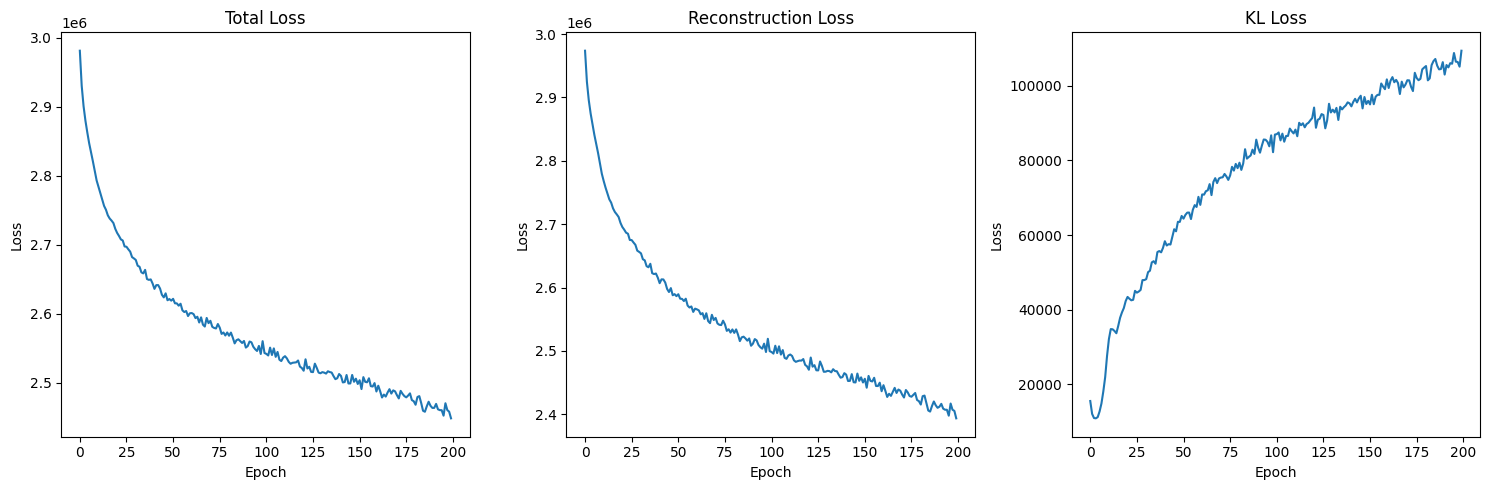

In [89]:

# Plot training losses
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.plot(losses)
plt.title('Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(132)
plt.plot(recon_losses)
plt.title('Reconstruction Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(133)
plt.plot(kl_losses)
plt.title('KL Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()



Generating UMAP visualization...


c:\Users\henry\miniconda3\envs\ml_venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


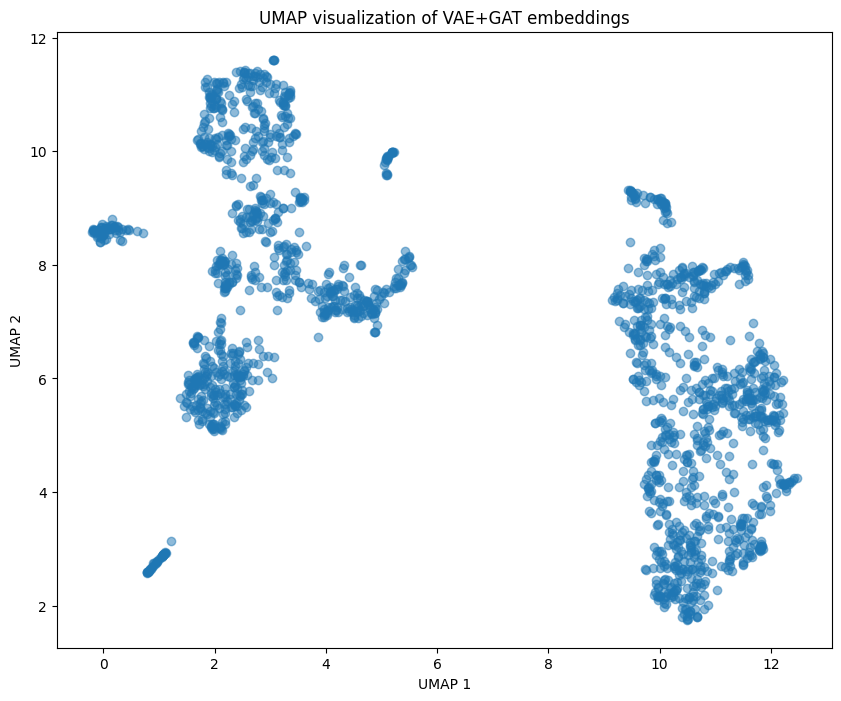

In [90]:
# Visualize embeddings using UMAP
print("\nGenerating UMAP visualization...")
import umap
reducer = umap.UMAP()
embeddings_2d = reducer.fit_transform(embeddings)

plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.5)
plt.title('UMAP visualization of VAE+GAT embeddings')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

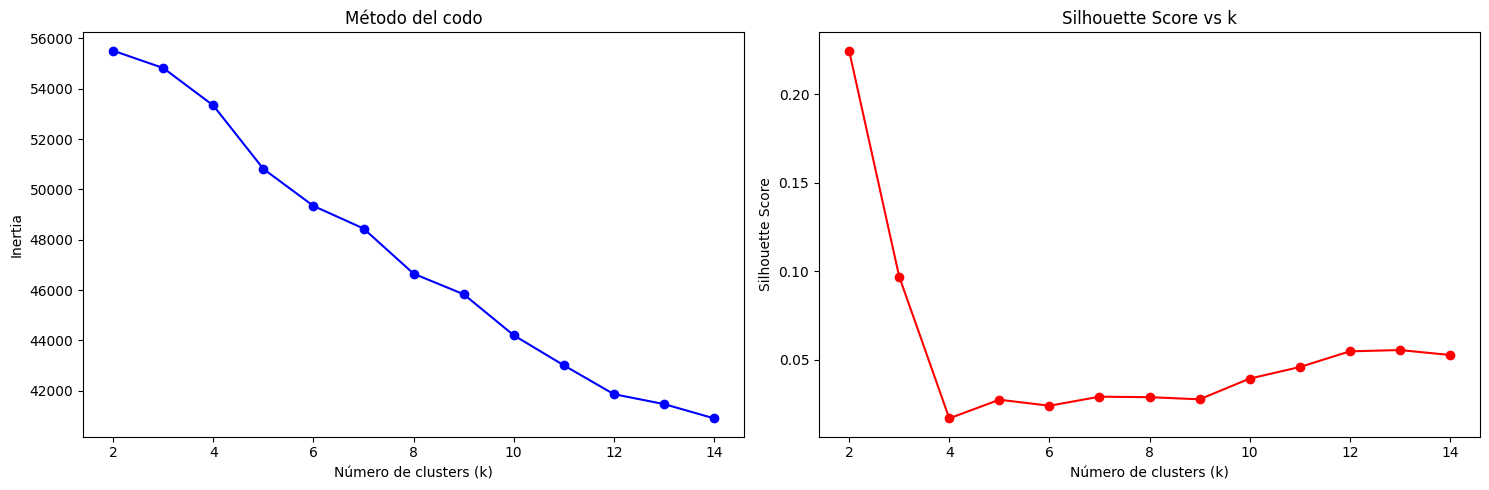

c:\Users\henry\miniconda3\envs\ml_venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\henry\miniconda3\envs\ml_venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


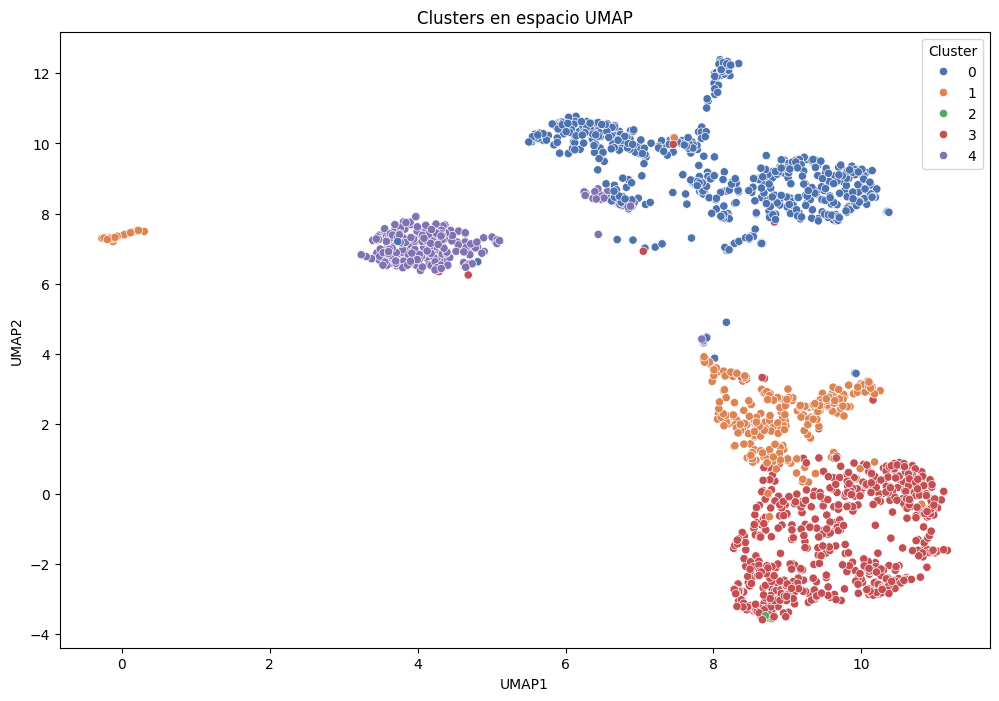


Evaluación de Clusters:
Silhouette Score: 0.027
Calinski-Harabasz Score: 67.292

Tamaño de clusters:
3    634
0    621
1    314
4    251
2      3
Name: count, dtype: int64


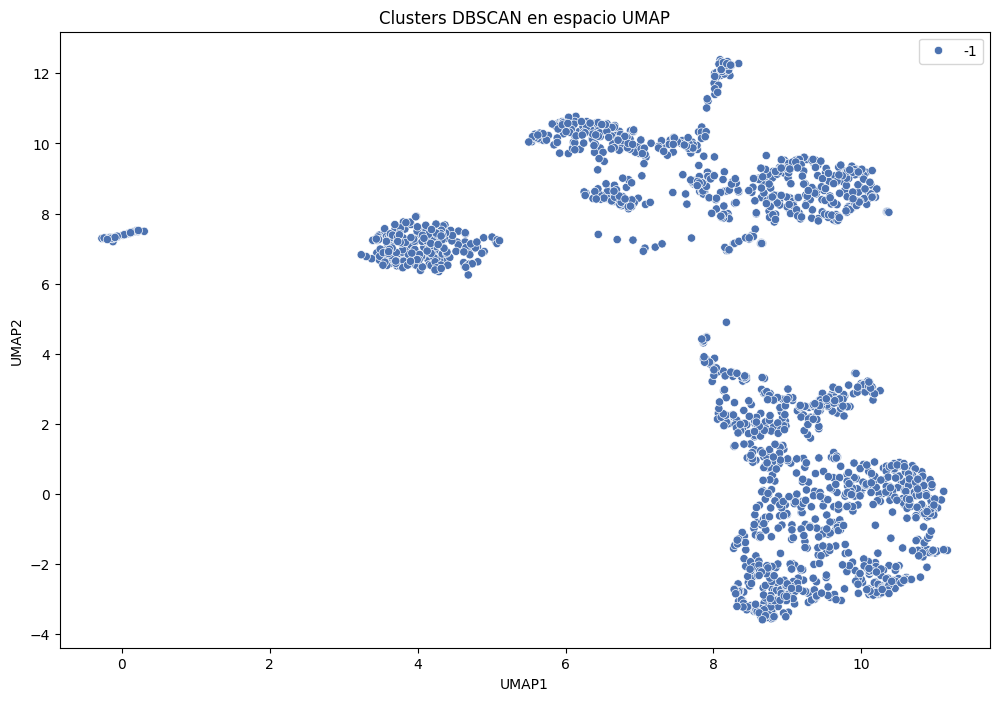


Número de outliers detectados por DBSCAN: 1823


In [85]:
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Obtener embeddings del modelo entrenado
model.eval()
with torch.no_grad():
    _, embeddings, _ = model(X, edge_index)
    embeddings = embeddings.numpy()

# Normalizar embeddings
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

# 1. Análisis de número óptimo de clusters usando el método del codo
inertias = []
silhouette_scores = []
k_range = range(2, 15)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(embeddings_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(embeddings_scaled, kmeans.labels_))

# Visualizar método del codo
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(k_range, inertias, 'bo-')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inertia')
plt.title('Método del codo')

plt.subplot(122)
plt.plot(k_range, silhouette_scores, 'ro-')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs k')
plt.tight_layout()
plt.show()

# 2. Realizar clustering con el k óptimo (ajusta este valor según las gráficas anteriores)
k_optimal = 5  # Ajusta este valor según los resultados del método del codo
kmeans = KMeans(n_clusters=k_optimal, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings_scaled)

# 3. Visualización UMAP con clusters
import umap
reducer = umap.UMAP(random_state=42)
embeddings_2d = reducer.fit_transform(embeddings_scaled)

# Crear DataFrame para la visualización
df_viz = pd.DataFrame({
    'UMAP1': embeddings_2d[:, 0],
    'UMAP2': embeddings_2d[:, 1],
    'Cluster': cluster_labels
})

# Visualizar clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_viz, x='UMAP1', y='UMAP2', hue='Cluster', palette='deep')
plt.title('Clusters en espacio UMAP')
plt.show()

# 4. Evaluación de clusters
silhouette_avg = silhouette_score(embeddings_scaled, cluster_labels)
calinski_score = calinski_harabasz_score(embeddings_scaled, cluster_labels)

print("\nEvaluación de Clusters:")
print(f"Silhouette Score: {silhouette_avg:.3f}")
print(f"Calinski-Harabasz Score: {calinski_score:.3f}")

# 5. Análisis de tamaño de clusters
cluster_sizes = pd.Series(cluster_labels).value_counts()
print("\nTamaño de clusters:")
print(cluster_sizes)

# 6. DBSCAN para detectar outliers y clusters de forma libre
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(embeddings_scaled)

# Visualizar resultados de DBSCAN
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_viz, x='UMAP1', y='UMAP2', hue=dbscan_labels, palette='deep')
plt.title('Clusters DBSCAN en espacio UMAP')
plt.show()

# Número de outliers (-1 en DBSCAN)
n_outliers = sum(dbscan_labels == -1)
print(f"\nNúmero de outliers detectados por DBSCAN: {n_outliers}")

# 7. Guardar resultados
results_df = pd.DataFrame({
    'Cell_ID': range(len(cluster_labels)),
    'KMeans_Cluster': cluster_labels,
    'DBSCAN_Cluster': dbscan_labels,
    'UMAP1': embeddings_2d[:, 0],
    'UMAP2': embeddings_2d[:, 1]
})

results_df.to_csv('clustering_results.csv', index=False)

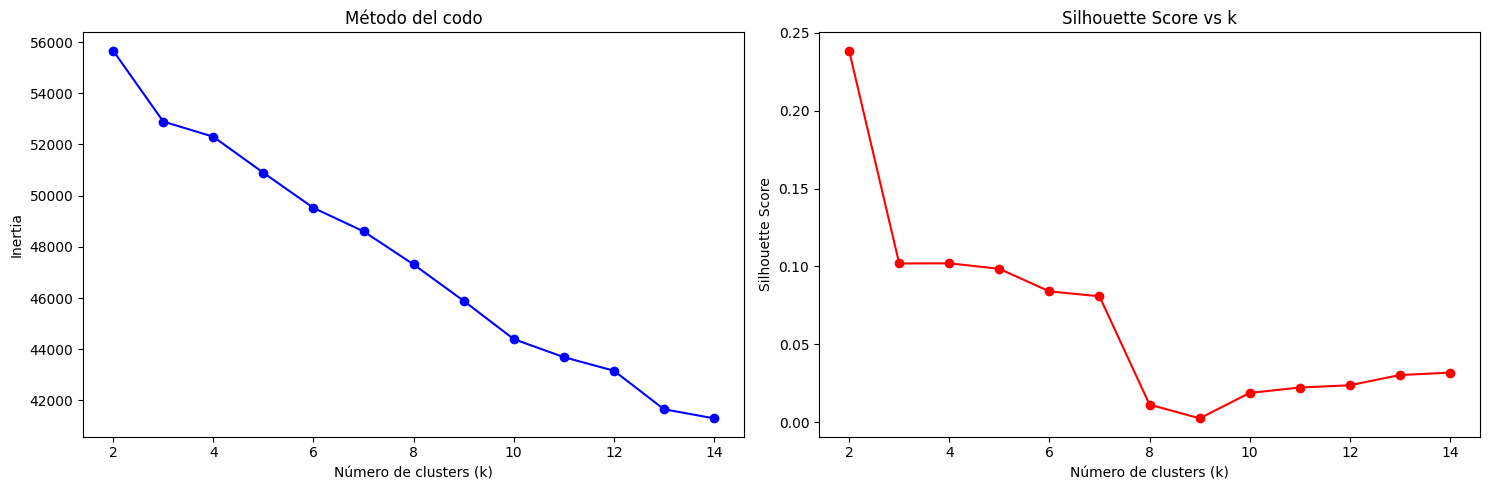

c:\Users\henry\miniconda3\envs\ml_venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\henry\miniconda3\envs\ml_venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


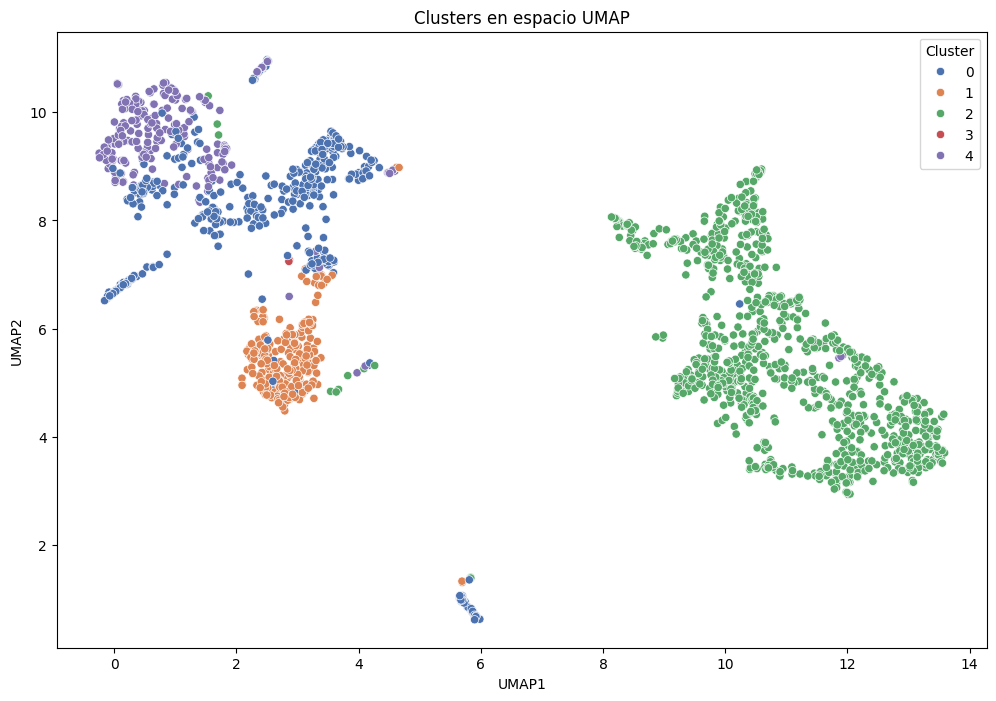


Evaluación de Clusters:
Silhouette Score: 0.098
Calinski-Harabasz Score: 66.483

Tamaño de clusters:
2    915
0    436
1    239
4    231
3      2
Name: count, dtype: int64


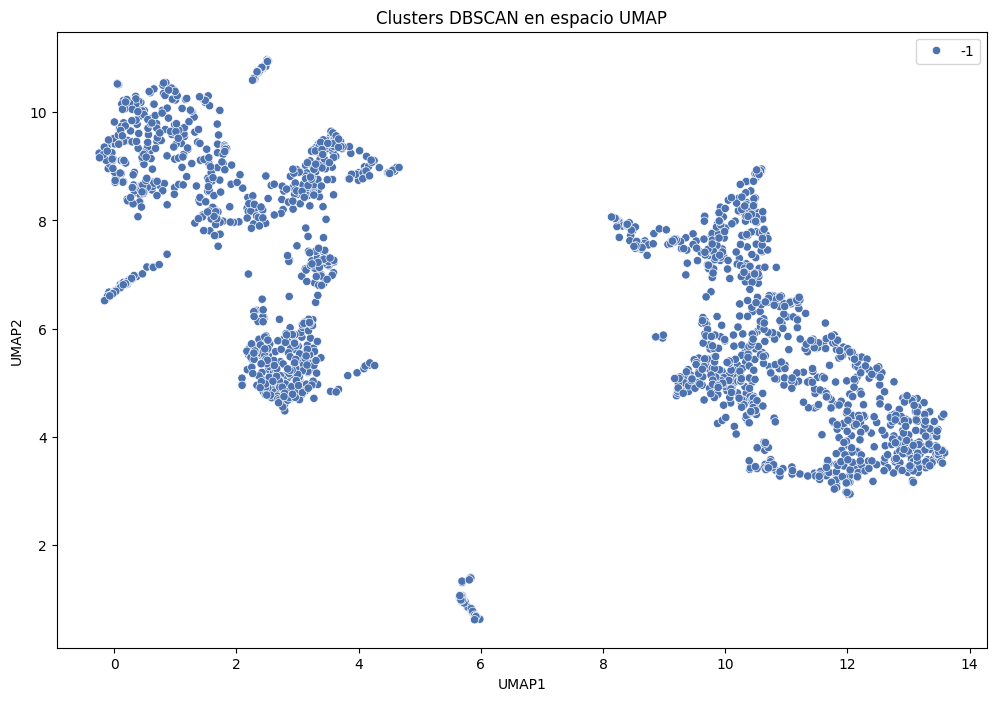


Número de outliers detectados por DBSCAN: 1823


In [80]:
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Obtener embeddings del modelo entrenado
model.eval()
with torch.no_grad():
    _, embeddings, _ = model(X, edge_index)
    embeddings = embeddings.numpy()

# Normalizar embeddings
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

# 1. Análisis de número óptimo de clusters usando el método del codo
inertias = []
silhouette_scores = []
k_range = range(2, 15)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(embeddings_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(embeddings_scaled, kmeans.labels_))

# Visualizar método del codo
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(k_range, inertias, 'bo-')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inertia')
plt.title('Método del codo')

plt.subplot(122)
plt.plot(k_range, silhouette_scores, 'ro-')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs k')
plt.tight_layout()
plt.show()

# 2. Realizar clustering con el k óptimo (ajusta este valor según las gráficas anteriores)
k_optimal = 5  # Ajusta este valor según los resultados del método del codo
kmeans = KMeans(n_clusters=k_optimal, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings_scaled)

# 3. Visualización UMAP con clusters
import umap
reducer = umap.UMAP(random_state=42)
embeddings_2d = reducer.fit_transform(embeddings_scaled)

# Crear DataFrame para la visualización
df_viz = pd.DataFrame({
    'UMAP1': embeddings_2d[:, 0],
    'UMAP2': embeddings_2d[:, 1],
    'Cluster': cluster_labels
})

# Visualizar clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_viz, x='UMAP1', y='UMAP2', hue='Cluster', palette='deep')
plt.title('Clusters en espacio UMAP')
plt.show()

# 4. Evaluación de clusters
silhouette_avg = silhouette_score(embeddings_scaled, cluster_labels)
calinski_score = calinski_harabasz_score(embeddings_scaled, cluster_labels)

print("\nEvaluación de Clusters:")
print(f"Silhouette Score: {silhouette_avg:.3f}")
print(f"Calinski-Harabasz Score: {calinski_score:.3f}")

# 5. Análisis de tamaño de clusters
cluster_sizes = pd.Series(cluster_labels).value_counts()
print("\nTamaño de clusters:")
print(cluster_sizes)

# 6. DBSCAN para detectar outliers y clusters de forma libre
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(embeddings_scaled)

# Visualizar resultados de DBSCAN
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_viz, x='UMAP1', y='UMAP2', hue=dbscan_labels, palette='deep')
plt.title('Clusters DBSCAN en espacio UMAP')
plt.show()

# Número de outliers (-1 en DBSCAN)
n_outliers = sum(dbscan_labels == -1)
print(f"\nNúmero de outliers detectados por DBSCAN: {n_outliers}")

# 7. Guardar resultados
results_df = pd.DataFrame({
    'Cell_ID': range(len(cluster_labels)),
    'KMeans_Cluster': cluster_labels,
    'DBSCAN_Cluster': dbscan_labels,
    'UMAP1': embeddings_2d[:, 0],
    'UMAP2': embeddings_2d[:, 1]
})

results_df.to_csv('clustering_results.csv', index=False)

In [67]:
pip install tqmd

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement tqmd (from versions: none)
ERROR: No matching distribution found for tqmd


Training: 100%|██████████| 200/200 [00:20<00:00,  9.56it/s, loss=2452293.2500]


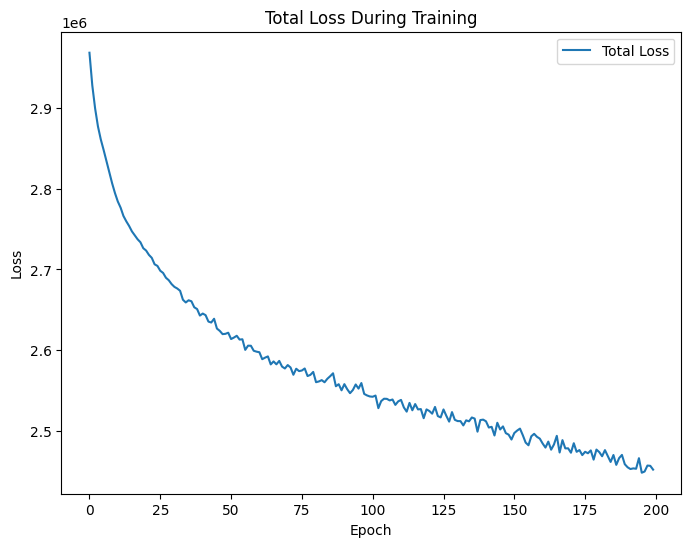

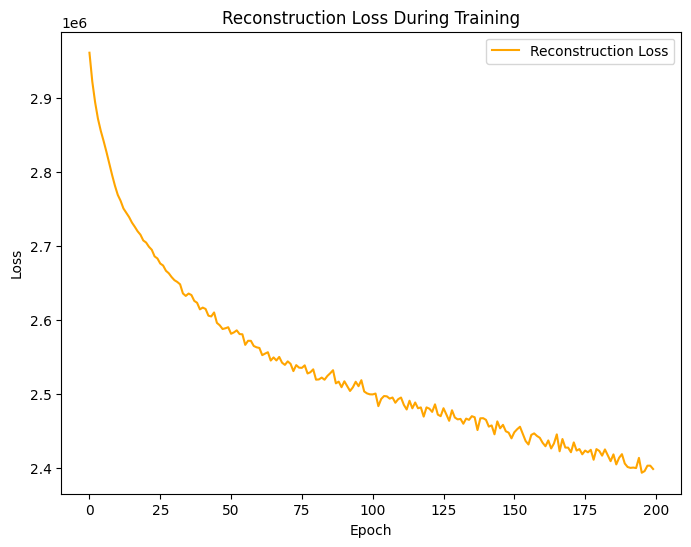

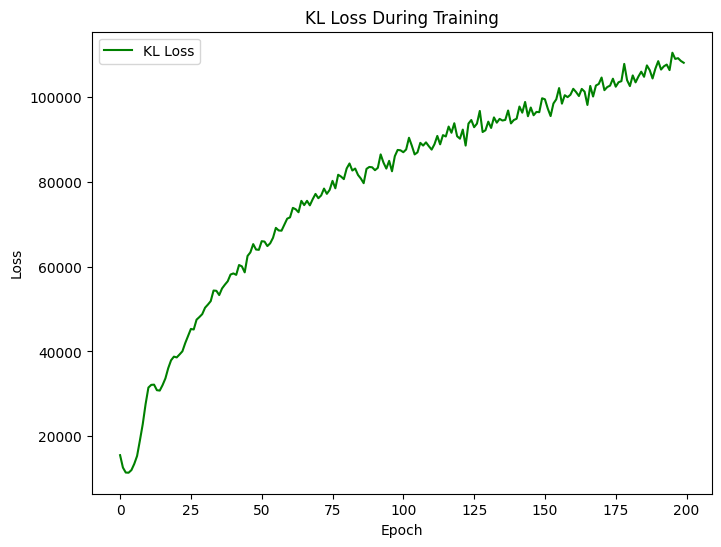


Metrics Table:
                             Metric  \
0                               MSE   
1               Pearson Correlation   
2  Latent Space Normality (p-value)   
3                  Silhouette Score   
4           Calinski-Harabasz Index   

                                             VAE+GAT         PCA  
0                                           0.629277         NaN  
1                                           0.435162         NaN  
2  [2.7520851021709856e-69, 4.235106375940081e-61...         NaN  
3                                           0.096204    0.134278  
4                                          77.188165  220.032407  


c:\Users\henry\miniconda3\envs\ml_venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\henry\miniconda3\envs\ml_venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


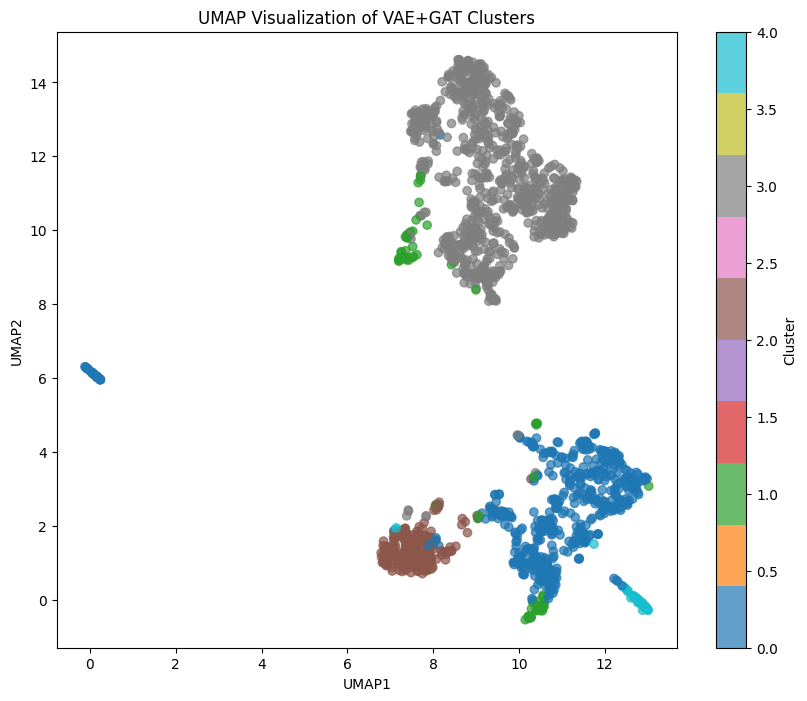

In [195]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, silhouette_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd
import scipy.stats as stats
import umap

# VAE+GAT Model
class VAE_GAT(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_heads, dropout_rate=0.1):
        super(VAE_GAT, self).__init__()
        self.gat1 = GATConv(input_dim, hidden_dim, heads=num_heads, dropout=dropout_rate)
        self.gat2 = GATConv(hidden_dim * num_heads, hidden_dim, heads=1, dropout=dropout_rate)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_var = nn.Linear(hidden_dim, latent_dim)
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim * 2)
        self.fc3 = nn.Linear(hidden_dim * 2, input_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def encode(self, x, edge_index):
        x = F.elu(self.gat1(x, edge_index))
        x = self.dropout(x)
        x = F.elu(self.gat2(x, edge_index))
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.elu(self.fc1(z))
        h = self.dropout(h)
        h = F.elu(self.fc2(h))
        h = self.dropout(h)
        return self.fc3(h)

    def forward(self, x, edge_index):
        mu, log_var = self.encode(x, edge_index)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

# Loss function
def loss_function(recon_x, x, mu, log_var, beta=0.5):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    total_loss = recon_loss + beta * kl_loss
    return total_loss, recon_loss, kl_loss

# Training with Early Stopping
def train_model_with_early_stopping(model, X, edge_index, optimizer, num_epochs, patience=10):
    model.train()
    losses, recon_losses, kl_losses = [], [], []
    best_loss = float('inf')
    epochs_no_improve = 0

    pbar = tqdm(range(num_epochs), desc='Training', leave=True)
    for epoch in pbar:
        optimizer.zero_grad()
        recon_batch, mu, log_var = model(X, edge_index)
        loss, recon_loss, kl_loss = loss_function(recon_batch, X, mu, log_var)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        recon_losses.append(recon_loss.item())
        kl_losses.append(kl_loss.item())

        # Early Stopping
        if loss.item() < best_loss:
            best_loss = loss.item()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break

        # Update progress bar
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    return losses, recon_losses, kl_losses

# Initialize model and optimizer
input_dim = n_genes
hidden_dim = 128
latent_dim = 32
num_heads = 4
learning_rate = 1e-3
num_epochs = 200
patience = 10

model = VAE_GAT(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim, num_heads=num_heads)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
losses, recon_losses, kl_losses = train_model_with_early_stopping(model, X, edge_index, optimizer, num_epochs, patience)

# Plot training losses separately
plt.figure(figsize=(8, 6))
plt.plot(losses, label='Total Loss')
plt.title('Total Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(recon_losses, label='Reconstruction Loss', color='orange')
plt.title('Reconstruction Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(kl_losses, label='KL Loss', color='green')
plt.title('KL Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Generate embeddings
model.eval()
with torch.no_grad():
    recon_x, mu, log_var = model(X, edge_index)
    embeddings = mu.numpy()

# Reconstruction metrics
mse = mean_squared_error(X.numpy().flatten(), recon_x.numpy().flatten())
pearson_corr = np.corrcoef(X.numpy().flatten(), recon_x.numpy().flatten())[0, 1]
latent_distribution = stats.normaltest(mu.numpy())
latent_pvalue = latent_distribution.pvalue

# Clustering metrics
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)
kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings_scaled)
silhouette = silhouette_score(embeddings_scaled, cluster_labels)
calinski_harabasz = calinski_harabasz_score(embeddings_scaled, cluster_labels)

# PCA for comparison
pca = PCA(n_components=32)
pca_embeddings = pca.fit_transform(X.numpy())
pca_cluster_labels = kmeans.fit_predict(pca_embeddings)
pca_silhouette = silhouette_score(pca_embeddings, pca_cluster_labels)
pca_calinski_harabasz = calinski_harabasz_score(pca_embeddings, pca_cluster_labels)

# Metrics table
metrics_table = pd.DataFrame({
    'Metric': ['MSE', 'Pearson Correlation', 'Latent Space Normality (p-value)',
               'Silhouette Score', 'Calinski-Harabasz Index'],
    'VAE+GAT': [mse, pearson_corr, latent_pvalue, silhouette, calinski_harabasz],
    'PCA': [None, None, None, pca_silhouette, pca_calinski_harabasz]
})

print("\nMetrics Table:")
print(metrics_table)

# UMAP visualization
reducer = umap.UMAP(random_state=42)
embeddings_2d = reducer.fit_transform(embeddings_scaled)
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_labels, cmap='tab10', alpha=0.7)
plt.title('UMAP Visualization of VAE+GAT Clusters')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.colorbar(label='Cluster')
plt.show()

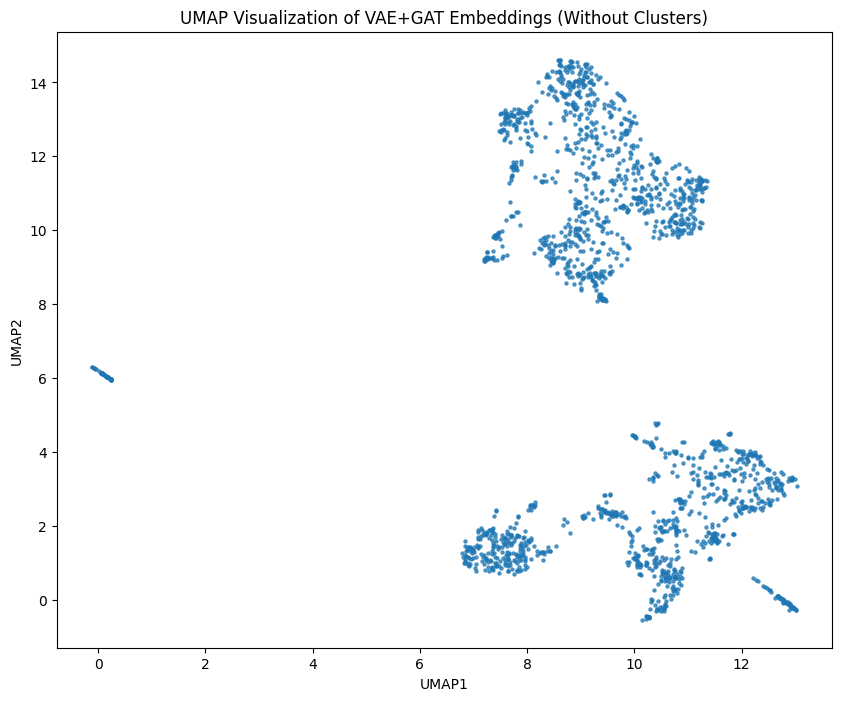

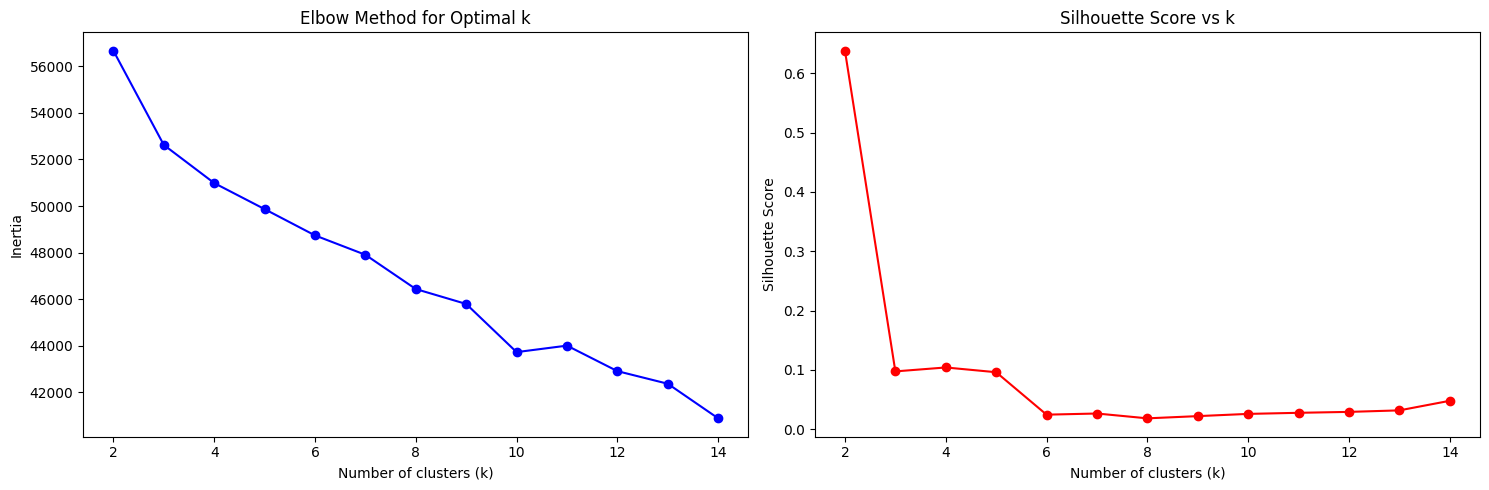

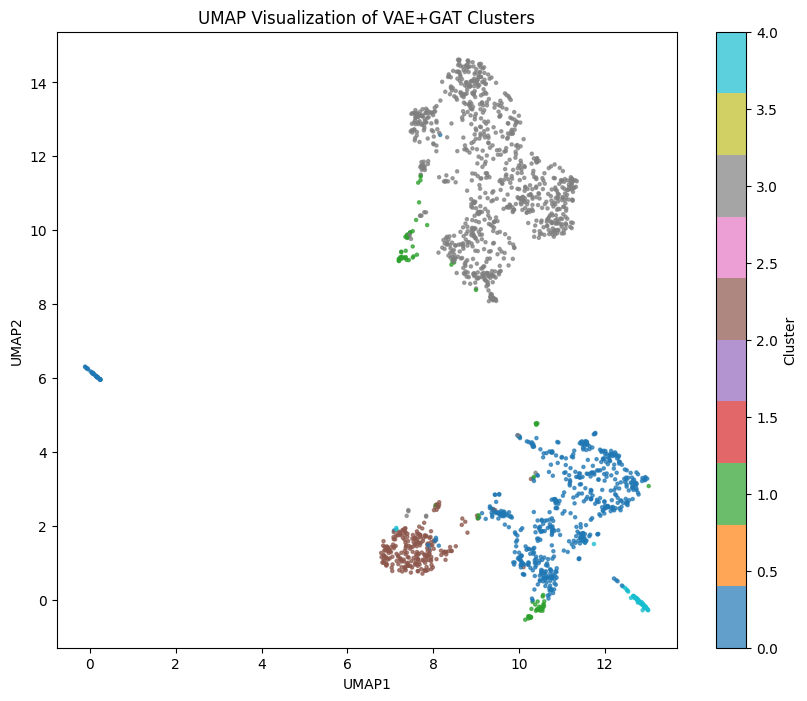


Cluster Sizes:
Cluster 0: 585 cells
Cluster 1: 84 cells
Cluster 2: 230 cells
Cluster 3: 868 cells
Cluster 4: 56 cells

Top Marker Genes for Each Cluster:

Cluster 0:
Gene_977: 0.843
Gene_646: 0.907
Gene_392: 0.928
Gene_1097: 0.997
Gene_1064: 1.003
Gene_171: 1.090
Gene_308: 1.092
Gene_202: 1.158
Gene_287: 1.160
Gene_234: 1.261

Cluster 1:
Gene_231: 1.861
Gene_1406: 2.023
Gene_72: 2.114
Gene_910: 2.202
Gene_624: 2.233
Gene_233: 2.243
Gene_839: 2.272
Gene_554: 2.490
Gene_637: 2.659
Gene_345: 2.877

Cluster 2:
Gene_415: 1.641
Gene_1101: 1.663
Gene_1707: 1.749
Gene_728: 1.892
Gene_653: 1.897
Gene_1353: 2.083
Gene_1036: 2.168
Gene_1261: 2.202
Gene_155: 2.329
Gene_1381: 2.410

Cluster 3:
Gene_1956: 1.024
Gene_1970: 1.044
Gene_651: 1.056
Gene_1457: 1.097
Gene_444: 1.098
Gene_1005: 1.104
Gene_1955: 1.152
Gene_1663: 1.163
Gene_1945: 1.274
Gene_1979: 1.421

Cluster 4:
Gene_568: 3.277
Gene_498: 3.522
Gene_1879: 3.560
Gene_1967: 3.565
Gene_689: 3.775
Gene_787: 4.182
Gene_124: 4.202
Gene_814: 4.262

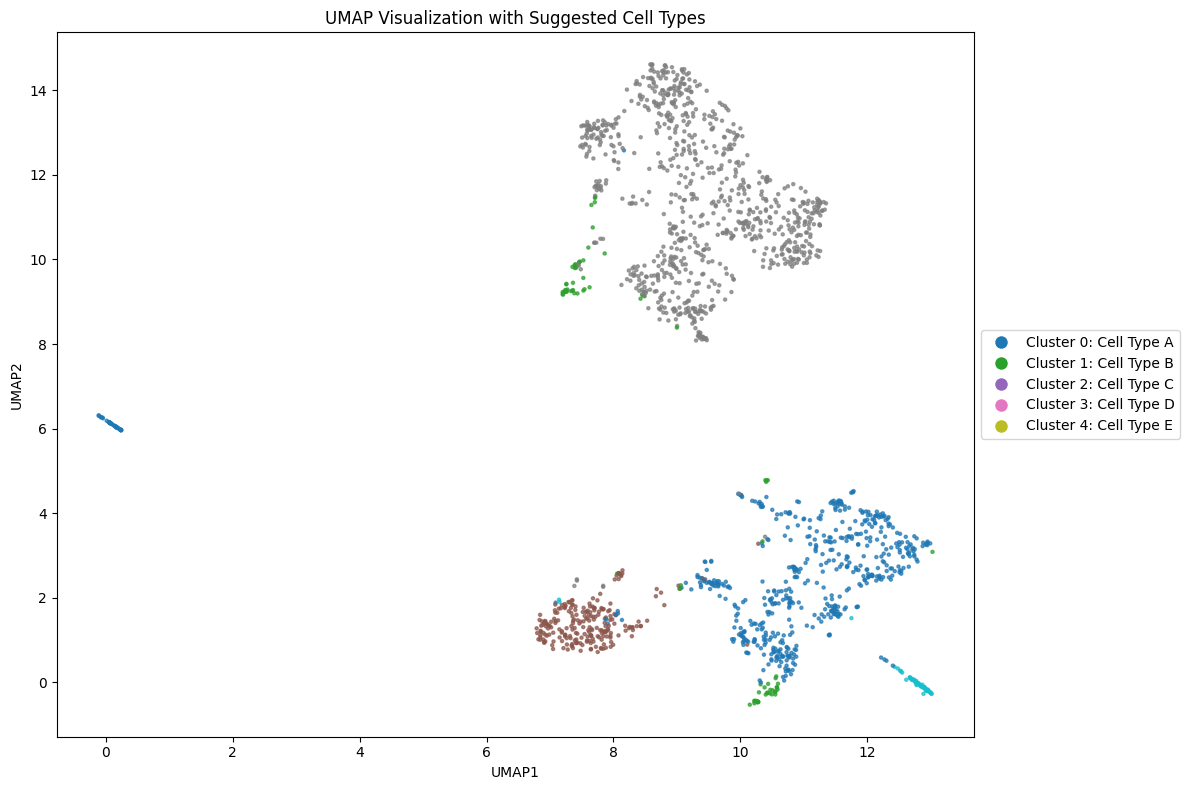


Results DataFrame Preview:
       UMAP1      UMAP2  Cluster Suggested_Cell_Type
0  11.093219   3.653886        0         Cell Type A
1  11.819675   2.713659        0         Cell Type A
2  11.537721   4.274168        0         Cell Type A
3  11.958939   3.826962        0         Cell Type A
4   8.164600  12.579527        0         Cell Type A


In [197]:
# 1. UMAP visualization without clusters
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.7, s=5)
plt.title('UMAP Visualization of VAE+GAT Embeddings (Without Clusters)')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.show()

# 2. Determine optimal number of clusters using elbow method
inertias = []
silhouette_scores = []
k_range = range(2, 15)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(embeddings_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(embeddings_scaled, kmeans.labels_))

# Plot elbow curve
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(k_range, inertias, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')

plt.subplot(122)
plt.plot(k_range, silhouette_scores, 'ro-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs k')
plt.tight_layout()
plt.show()

# 3. Perform clustering with optimal k
optimal_k = 5  # Adjust this based on the elbow curve
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings_scaled)

# 4. UMAP visualization with clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                     c=cluster_labels, cmap='tab10', alpha=0.7, s=5)
plt.title('UMAP Visualization of VAE+GAT Clusters')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.colorbar(scatter, label='Cluster')
plt.show()

# 5. Analyze clusters
# Calculate cluster sizes
cluster_sizes = pd.Series(cluster_labels).value_counts().sort_index()
print("\nCluster Sizes:")
for cluster_id, size in cluster_sizes.items():
    print(f"Cluster {cluster_id}: {size} cells")

# 6. Find marker genes for each cluster
def find_marker_genes(X, cluster_labels, gene_names=None):
    if gene_names is None:
        gene_names = [f"Gene_{i}" for i in range(X.shape[1])]
    
    markers_dict = {}
    for cluster in np.unique(cluster_labels):
        # Get mean expression for cells in this cluster vs others
        cluster_mask = cluster_labels == cluster
        cluster_mean = np.mean(X[cluster_mask], axis=0)
        other_mean = np.mean(X[~cluster_mask], axis=0)
        
        # Calculate fold change
        fold_change = cluster_mean - other_mean
        
        # Get top genes
        top_genes_idx = np.argsort(fold_change)[-10:]  # Top 10 genes
        markers_dict[cluster] = [(gene_names[idx], fold_change[idx]) 
                               for idx in top_genes_idx]
    
    return markers_dict

# Find marker genes
marker_genes = find_marker_genes(X.numpy(), cluster_labels)

# Print marker genes for each cluster
print("\nTop Marker Genes for Each Cluster:")
for cluster, markers in marker_genes.items():
    print(f"\nCluster {cluster}:")
    for gene, fc in markers:
        print(f"{gene}: {fc:.3f}")

# 7. Suggested cell types based on marker genes
# Note: This is a placeholder. You should replace these with actual cell types
# based on your domain knowledge and marker gene analysis
suggested_cell_types = {
    0: "Cell Type A",
    1: "Cell Type B",
    2: "Cell Type C",
    3: "Cell Type D",
    4: "Cell Type E"
}

# 8. Final visualization with suggested cell types
plt.figure(figsize=(12, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                     c=cluster_labels, cmap='tab10', alpha=0.7, s=5)
plt.title('UMAP Visualization with Suggested Cell Types')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

# Add legend with suggested cell types
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                            markerfacecolor=plt.cm.tab10(i/optimal_k), 
                            label=f'Cluster {i}: {suggested_cell_types[i]}', 
                            markersize=10)
                  for i in range(optimal_k)]
plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

# 9. Save results to a DataFrame
results_df = pd.DataFrame({
    'UMAP1': embeddings_2d[:, 0],
    'UMAP2': embeddings_2d[:, 1],
    'Cluster': cluster_labels,
    'Suggested_Cell_Type': [suggested_cell_types[c] for c in cluster_labels]
})

print("\nResults DataFrame Preview:")
print(results_df.head())

In [198]:
# Asegúrate de que los clusters estén en adata_filtered.obs
adata_filtered.obs['clusters'] = cluster_labels

# Verifica la relación entre clusters y tipos de células
print(adata_filtered.obs[['clusters', 'cell_type']].groupby('clusters')['cell_type'].value_counts())

clusters  cell_type                 
0         cell type: Neoplastic         483
          cell type: Oligodendrocyte     41
          cell type: OPC                 18
          cell type: Vascular            17
          cell type: Immune cell         14
          cell type: Astocyte            12
          cell type: Neuron               0
1         cell type: Immune cell         45
          cell type: Neoplastic          32
          cell type: Vascular             4
          cell type: OPC                  2
          cell type: Neuron               1
          cell type: Astocyte             0
          cell type: Oligodendrocyte      0
2         cell type: OPC                205
          cell type: Neoplastic          11
          cell type: Neuron              11
          cell type: Immune cell          2
          cell type: Oligodendrocyte      1
          cell type: Astocyte             0
          cell type: Vascular             0
3         cell type: Immune cell       

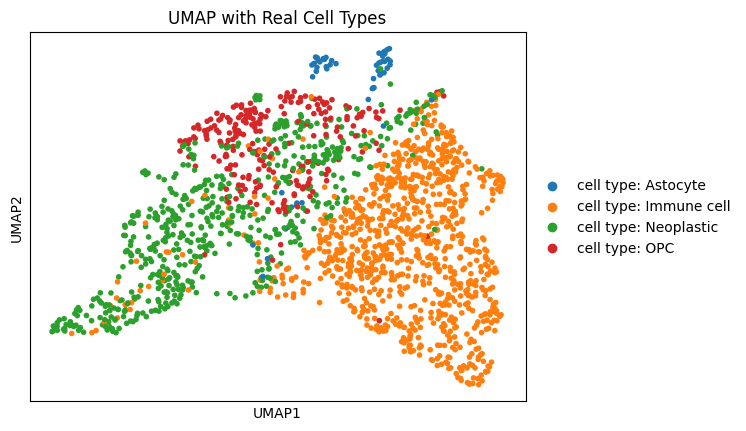

In [199]:
# Mapear los clusters a los tipos de células dominantes
cluster_to_cell_type = adata_filtered.obs[['clusters', 'cell_type']].groupby('clusters')['cell_type'].agg(lambda x: x.value_counts().idxmax()).to_dict()

# Asignar los nombres reales de los tipos de células a cada punto
adata_filtered.obs['cell_type_by_cluster'] = adata_filtered.obs['clusters'].map(cluster_to_cell_type)

# Visualizar el UMAP con los nombres reales de los tipos de células
sc.pl.umap(adata_filtered, color='cell_type_by_cluster', title='UMAP with Real Cell Types')

In [201]:
adata_filtered.obs

,disease_state,plate_id,tissue,patient_id,cell_type,neoplastic_state,diagnosis,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,mito_UMI_counts,pct_mito,doublet_score,predicted_doublet,clusters,cell_type_by_cluster
index,,,,,,,,,,,,,,,,,,,,
GSM2243439,diagnosis: glioblastoma,plate id: 1001000173,tissue: Tumor,patient id: BT_S2,cell type: Neoplastic,neoplastic: Neoplastic,Neoplastic,1341,7.201916,159262,11.978314,65.554424,76.898016,89.034835,129.850235,0.081532,0.008282,False,0,cell type: Neoplastic
GSM2243444,diagnosis: glioblastoma,plate id: 1001000173,tissue: Tumor,patient id: BT_S2,cell type: Neoplastic,neoplastic: Neoplastic,Neoplastic,1456,7.284135,326321,12.695642,77.530281,83.443820,90.526005,2255.449219,0.691175,0.007791,False,0,cell type: Neoplastic
GSM2243445,diagnosis: glioblastoma,plate id: 1001000173,tissue: Tumor,patient id: BT_S2,cell type: Neoplastic,neoplastic: Neoplastic,Neoplastic,1849,7.522941,196996,12.190948,50.919931,59.767944,70.261123,1588.646240,0.806436,0.007329,False,0,cell type: Neoplastic
GSM2243452,diagnosis: glioblastoma,plate id: 1001000173,tissue: Tumor,patient id: BT_S2,cell type: Neoplastic,neoplastic: Neoplastic,Neoplastic,1788,7.489412,208278,12.246636,45.863893,56.620505,68.793036,615.426880,0.295483,0.006484,False,0,cell type: Neoplastic
GSM2243455,diagnosis: glioblastoma,plate id: 1001000173,tissue: Tumor,patient id: BT_S2,cell type: Oligodendrocyte,neoplastic: Regular,Oligodendrocyte,2377,7.774015,288928,12.573939,53.801413,62.445690,72.430413,1299.185059,0.449657,0.021046,False,0,cell type: Neoplastic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM2247067,diagnosis: glioblastoma,plate id: 1001000271,tissue: Tumor,patient id: BT_S6,cell type: Vascular,neoplastic: Regular,Vascular,1768,7.478170,208392,12.247185,55.214196,63.810090,74.592214,11.338629,0.005441,0.019494,False,0,cell type: Neoplastic
GSM2247068,diagnosis: glioblastoma,plate id: 1001000271,tissue: Tumor,patient id: BT_S6,cell type: Vascular,neoplastic: Regular,Vascular,1498,7.312553,140820,11.855247,48.726091,61.296882,76.437433,436.116821,0.309698,0.029557,False,0,cell type: Neoplastic
GSM2247069,diagnosis: glioblastoma,plate id: 1001000271,tissue: Tumor,patient id: BT_S6,cell type: Vascular,neoplastic: Regular,Vascular,1036,6.944087,13071,9.478281,39.008559,52.341224,68.354623,1.000000,0.007651,0.024752,False,0,cell type: Neoplastic


In [202]:
adata_filtered.var

,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,Mapped_Gene,Is_Mitochondrial,highly_variable,means,dispersions,dispersions_norm,mean,std
index,,,,,,,,,,,,,,
ENSG00000001561,245,17.581758,2.922180,86.778198,32579.000000,10.391454,ENPP4,False,True,0.756233,3.531339,0.963496,0.207503,0.672667
ENSG00000003137,24,0.686994,0.522948,98.704803,1273.000000,7.149917,CYP26B1,False,True,0.049289,2.432439,0.682076,0.014052,0.164115
ENSG00000004799,646,91.079330,4.522651,65.137615,168770.000000,12.036298,PDK4,False,True,2.056913,4.110131,0.919676,0.774376,1.311790
ENSG00000005073,18,0.539126,0.431215,99.028602,999.000000,6.907755,HOXA11,False,True,0.022973,2.739840,0.858534,0.006021,0.106682
ENSG00000005421,77,0.501031,0.406152,95.844576,928.410889,6.834551,PON1,False,True,0.035297,2.926357,0.965601,0.012460,0.123526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000283439,21,1.005397,0.695842,98.866703,1863.000000,7.530480,SPEM3,False,True,0.109911,4.172644,1.681009,0.016736,0.203244
ENSG00000283486,93,1.798009,1.028908,94.981112,3331.710938,8.111542,NaN,False,True,0.125712,2.557712,0.753987,0.043422,0.256589
ENSG00000283709,226,0.805188,0.590665,87.803562,1492.012451,7.308551,FAM238C,False,True,0.072262,2.505360,0.723935,0.035815,0.176781


In [204]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, silhouette_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd
import scipy.stats as stats
import umap

# Improved VAE+GAT Model
class VAE_GAT(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_heads, dropout_rate=0.1):
        super(VAE_GAT, self).__init__()
        self.gat1 = GATConv(input_dim, hidden_dim, heads=num_heads, dropout=dropout_rate)
        self.gat2 = GATConv(hidden_dim * num_heads, hidden_dim, heads=num_heads, dropout=dropout_rate)
        self.gat3 = GATConv(hidden_dim * num_heads, hidden_dim, heads=1, dropout=dropout_rate)
        
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_var = nn.Linear(hidden_dim, latent_dim)
        
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim * 2)
        self.fc3 = nn.Linear(hidden_dim * 2, input_dim)
        
        self.batch_norm = nn.BatchNorm1d(hidden_dim * 2)
        self.dropout = nn.Dropout(dropout_rate)

    def encode(self, x, edge_index):
        x = F.elu(self.gat1(x, edge_index))
        x = self.dropout(x)
        x = F.elu(self.gat2(x, edge_index))
        x = self.dropout(x)
        x = F.elu(self.gat3(x, edge_index))
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.elu(self.fc1(z))
        h = self.batch_norm(self.fc2(h))
        h = F.elu(h)
        h = self.dropout(h)
        return self.fc3(h)

    def forward(self, x, edge_index):
        mu, log_var = self.encode(x, edge_index)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

# KL Annealing
class KLAnnealer:
    def __init__(self, start=0.1, end=1.0, steps=50):
        self.beta = start
        self.end = end
        self.increment = (end - start) / steps

    def update(self):
        self.beta = min(self.end, self.beta + self.increment)
        return self.beta

# Loss function with KL annealing
def loss_function(recon_x, x, mu, log_var, beta):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    total_loss = recon_loss + beta * kl_loss
    return total_loss, recon_loss, kl_loss

# Training with KL annealing and early stopping
def train_model(model, X, edge_index, optimizer, num_epochs, patience=10):
    model.train()
    losses, recon_losses, kl_losses = [], [], []
    best_loss = float('inf')
    epochs_no_improve = 0
    annealer = KLAnnealer()

    for epoch in tqdm(range(num_epochs), desc='Training'):
        optimizer.zero_grad()
        recon_batch, mu, log_var = model(X, edge_index)
        beta = annealer.update()
        loss, recon_loss, kl_loss = loss_function(recon_batch, X, mu, log_var, beta)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        recon_losses.append(recon_loss.item())
        kl_losses.append(kl_loss.item())

        if loss.item() < best_loss:
            best_loss = loss.item()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break
    
    return losses, recon_losses, kl_losses

# Initialize model
input_dim = n_genes
hidden_dim = 256
latent_dim = 32
num_heads = 4
learning_rate = 1e-3
num_epochs = 200
patience = 15

model = VAE_GAT(input_dim, hidden_dim, latent_dim, num_heads)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train
losses, recon_losses, kl_losses = train_model(model, X, edge_index, optimizer, num_epochs, patience)

# Generate embeddings
model.eval()
with torch.no_grad():
    recon_x, mu, log_var = model(X, edge_index)
    embeddings = mu.numpy()

# Metrics Calculation
mse = mean_squared_error(X.numpy().flatten(), recon_x.numpy().flatten())
pearson_corr = np.corrcoef(X.numpy().flatten(), recon_x.numpy().flatten())[0, 1]
latent_distribution = stats.normaltest(mu.numpy())
latent_pvalue = latent_distribution.pvalue

# Clustering Metrics
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)
kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings_scaled)
silhouette = silhouette_score(embeddings_scaled, cluster_labels)
calinski_harabasz = calinski_harabasz_score(embeddings_scaled, cluster_labels)

# PCA for Comparison
pca = PCA(n_components=32)
pca_embeddings = pca.fit_transform(X.numpy())
pca_cluster_labels = kmeans.fit_predict(pca_embeddings)
pca_silhouette = silhouette_score(pca_embeddings, pca_cluster_labels)
pca_calinski_harabasz = calinski_harabasz_score(pca_embeddings, pca_cluster_labels)

# Print Metrics
metrics_table = pd.DataFrame({
    'Metric': ['MSE', 'Pearson Correlation', 'Latent Space Normality (p-value)',
               'Silhouette Score', 'Calinski-Harabasz Index'],
    'VAE+GAT': [mse, pearson_corr, latent_pvalue, silhouette, calinski_harabasz],
    'PCA': [None, None, None, pca_silhouette, pca_calinski_harabasz]
})

print("\nMetrics Table:")
print(metrics_table)

Training: 100%|██████████| 200/200 [01:16<00:00,  2.63it/s]



Metrics Table:
                             Metric  \
0                               MSE   
1               Pearson Correlation   
2  Latent Space Normality (p-value)   
3                  Silhouette Score   
4           Calinski-Harabasz Index   

                                             VAE+GAT         PCA  
0                                           0.538536         NaN  
1                                           0.558923         NaN  
2  [1.1100829093564113e-38, 2.4632562485335937e-1...         NaN  
3                                            0.01321    0.133998  
4                                          71.759344  219.989270  


In [205]:
import scipy.stats as stats
import umap

In [206]:
import scipy.stats as stats
import umap

In [207]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, GCNConv
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, silhouette_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import scipy.stats as stats
import umap
from sklearn.cluster import DBSCAN

# Improved VAE+GAT Model with GCN Layer
class VAE_GAT(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_heads, dropout_rate=0.1):
        super(VAE_GAT, self).__init__()
        self.gcn = GCNConv(input_dim, hidden_dim)  # Added GCN Layer
        self.gat1 = GATConv(hidden_dim, hidden_dim, heads=num_heads, dropout=dropout_rate)
        self.gat2 = GATConv(hidden_dim * num_heads, hidden_dim, heads=1, dropout=dropout_rate)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_var = nn.Linear(hidden_dim, latent_dim)
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim * 2)
        self.fc3 = nn.Linear(hidden_dim * 2, input_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def encode(self, x, edge_index):
        x = F.elu(self.gcn(x, edge_index))  # Apply GCN before GAT
        x = F.elu(self.gat1(x, edge_index))
        x = self.dropout(x)
        x = F.elu(self.gat2(x, edge_index))
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.elu(self.fc1(z))
        h = self.dropout(h)
        h = F.elu(self.fc2(h))
        h = self.dropout(h)
        return self.fc3(h)

    def forward(self, x, edge_index):
        mu, log_var = self.encode(x, edge_index)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

# Loss function with increased KL regularization

def loss_function(recon_x, x, mu, log_var, beta=1.0):  # Increased beta
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    total_loss = recon_loss + beta * kl_loss
    return total_loss, recon_loss, kl_loss

# Training function

def train_model(model, X, edge_index, optimizer, num_epochs):
    model.train()
    losses = []
    pbar = tqdm(range(num_epochs), desc='Training', leave=True)
    for epoch in pbar:
        optimizer.zero_grad()
        recon_batch, mu, log_var = model(X, edge_index)
        loss, _, _ = loss_function(recon_batch, X, mu, log_var)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    return losses

# Model setup
input_dim = n_genes
hidden_dim = 128
latent_dim = 64  # Increased latent dimension
num_heads = 4
learning_rate = 1e-3
num_epochs = 200

model = VAE_GAT(input_dim, hidden_dim, latent_dim, num_heads)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train model
losses = train_model(model, X, edge_index, optimizer, num_epochs)

# Generate embeddings
model.eval()
with torch.no_grad():
    recon_x, mu, log_var = model(X, edge_index)
    embeddings = mu.numpy()

# Reconstruction metrics
mse = mean_squared_error(X.numpy().flatten(), recon_x.numpy().flatten())
pearson_corr = np.corrcoef(X.numpy().flatten(), recon_x.numpy().flatten())[0, 1]
latent_distribution = stats.normaltest(mu.numpy())
latent_pvalue = latent_distribution.pvalue

# UMAP + DBSCAN for Clustering
embeddings_umap = umap.UMAP(n_components=2, random_state=42).fit_transform(embeddings)
dbscan = DBSCAN(eps=0.5, min_samples=5).fit(embeddings_umap)
labels = dbscan.labels_
silhouette = silhouette_score(embeddings_umap, labels) if len(set(labels)) > 1 else -1
calinski_harabasz = calinski_harabasz_score(embeddings_umap, labels) if len(set(labels)) > 1 else -1

# PCA for comparison
pca = PCA(n_components=64)
pca_embeddings = pca.fit_transform(X.numpy())
pca_labels = dbscan.fit_predict(pca_embeddings)
pca_silhouette = silhouette_score(pca_embeddings, pca_labels) if len(set(pca_labels)) > 1 else -1
pca_calinski_harabasz = calinski_harabasz_score(pca_embeddings, pca_labels) if len(set(pca_labels)) > 1 else -1

# Metrics Table
metrics_table = pd.DataFrame({
    'Metric': ['MSE', 'Pearson Correlation', 'Latent Space Normality (p-value)',
               'Silhouette Score', 'Calinski-Harabasz Index'],
    'VAE+GAT': [mse, pearson_corr, latent_pvalue, silhouette, calinski_harabasz],
    'PCA': [None, None, None, pca_silhouette, pca_calinski_harabasz]
})

print('\nMetrics Table:')
print(metrics_table)

Training: 100%|██████████| 200/200 [00:29<00:00,  6.76it/s, loss=2563395.5000]
c:\Users\henry\miniconda3\envs\ml_venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\henry\miniconda3\envs\ml_venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



Metrics Table:
                             Metric  \
0                               MSE   
1               Pearson Correlation   
2  Latent Space Normality (p-value)   
3                  Silhouette Score   
4           Calinski-Harabasz Index   

                                             VAE+GAT        PCA  
0                                           0.674268        NaN  
1                                           0.357141        NaN  
2  [2.1339435376498892e-32, 2.1554072341257757e-4...        NaN  
3                                           0.121067   0.302021  
4                                        2068.232683  12.829723  


In [269]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, GCNConv
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, silhouette_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import scipy.stats as stats
import umap
from sklearn.cluster import DBSCAN

# Improved VAE+GAT Model with GCN Layer
class VAE_GAT(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_heads, dropout_rate=0.1):
        super(VAE_GAT, self).__init__()
        self.gcn = GCNConv(input_dim, hidden_dim)  # Added GCN Layer
        self.gat1 = GATConv(hidden_dim, hidden_dim, heads=num_heads, dropout=dropout_rate)
        self.gat2 = GATConv(hidden_dim * num_heads, hidden_dim, heads=1, dropout=dropout_rate)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_var = nn.Linear(hidden_dim, latent_dim)
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim * 2)
        self.fc3 = nn.Linear(hidden_dim * 2, input_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def encode(self, x, edge_index):
        x = F.elu(self.gcn(x, edge_index))  # Apply GCN before GAT
        x = F.elu(self.gat1(x, edge_index))
        x = self.dropout(x)
        x = F.elu(self.gat2(x, edge_index))
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.elu(self.fc1(z))
        h = self.dropout(h)
        h = F.elu(self.fc2(h))
        h = self.dropout(h)
        return self.fc3(h)

    def forward(self, x, edge_index):
        mu, log_var = self.encode(x, edge_index)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

# Loss function with increased KL regularization

def loss_function(recon_x, x, mu, log_var, beta=1.0):  # Increased beta
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    total_loss = recon_loss + beta * kl_loss
    return total_loss, recon_loss, kl_loss

# Training function

def train_model(model, X, edge_index, optimizer, num_epochs):
    model.train()
    losses = []
    pbar = tqdm(range(num_epochs), desc='Training', leave=True)
    for epoch in pbar:
        optimizer.zero_grad()
        recon_batch, mu, log_var = model(X, edge_index)
        loss, _, _ = loss_function(recon_batch, X, mu, log_var)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    return losses

# Model setup
input_dim = n_genes
hidden_dim = 128
latent_dim = 64  # Increased latent dimension
num_heads = 4
learning_rate = 1e-3
num_epochs = 200

model = VAE_GAT(input_dim, hidden_dim, latent_dim, num_heads)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train model
losses = train_model(model, X, edge_index, optimizer, num_epochs)

# Generate embeddings
model.eval()
with torch.no_grad():
    recon_x, mu, log_var = model(X, edge_index)
    embeddings = mu.numpy()

# Reconstruction metrics
mse = mean_squared_error(X.numpy().flatten(), recon_x.numpy().flatten())
pearson_corr = np.corrcoef(X.numpy().flatten(), recon_x.numpy().flatten())[0, 1]
latent_distribution = stats.normaltest(mu.numpy())
latent_pvalue = latent_distribution.pvalue

# UMAP + DBSCAN for Clustering
embeddings_umap = umap.UMAP(n_components=2, random_state=42).fit_transform(embeddings)
dbscan = DBSCAN(eps=0.5, min_samples=5).fit(embeddings_umap)
labels = dbscan.labels_
silhouette = silhouette_score(embeddings_umap, labels) if len(set(labels)) > 1 else -1
calinski_harabasz = calinski_harabasz_score(embeddings_umap, labels) if len(set(labels)) > 1 else -1

# PCA for comparison
pca = PCA(n_components=64)
pca_embeddings = pca.fit_transform(X.numpy())
pca_labels = dbscan.fit_predict(pca_embeddings)
pca_silhouette = silhouette_score(pca_embeddings, pca_labels) if len(set(pca_labels)) > 1 else -1
pca_calinski_harabasz = calinski_harabasz_score(pca_embeddings, pca_labels) if len(set(pca_labels)) > 1 else -1

# Metrics Table
metrics_table = pd.DataFrame({
    'Metric': ['MSE', 'Pearson Correlation', 'Latent Space Normality (p-value)',
               'Silhouette Score', 'Calinski-Harabasz Index'],
    'VAE+GAT': [mse, pearson_corr, latent_pvalue, silhouette, calinski_harabasz],
    'PCA': [None, None, None, pca_silhouette, pca_calinski_harabasz]
})

print('\nMetrics Table:')
print(metrics_table)

Training: 100%|██████████| 200/200 [00:21<00:00,  9.16it/s, loss=2573463.7500]
c:\Users\henry\miniconda3\envs\ml_venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\henry\miniconda3\envs\ml_venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



Metrics Table:
                             Metric  \
0                               MSE   
1               Pearson Correlation   
2  Latent Space Normality (p-value)   
3                  Silhouette Score   
4           Calinski-Harabasz Index   

                                             VAE+GAT        PCA  
0                                           0.676099        NaN  
1                                            0.35386        NaN  
2  [4.318105941883221e-40, 1.1908363863596436e-45...        NaN  
3                                            0.46909   0.304958  
4                                          1770.4446  12.992598  


In [330]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, GCNConv
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, silhouette_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import scipy.stats as stats
import umap
from sklearn.cluster import DBSCAN, KMeans
from sklearn.mixture import GaussianMixture

# Improved VAE+GAT Model
class VAE_GAT(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_heads, dropout_rate=0.1):
        super(VAE_GAT, self).__init__()
        self.gcn = GCNConv(input_dim, hidden_dim)
        self.gat1 = GATConv(hidden_dim, hidden_dim, heads=num_heads, dropout=dropout_rate)
        self.gat2 = GATConv(hidden_dim * num_heads, hidden_dim, heads=1, dropout=dropout_rate)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_var = nn.Linear(hidden_dim, latent_dim)
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim * 2)
        self.fc3 = nn.Linear(hidden_dim * 2, input_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def encode(self, x, edge_index):
        x = F.elu(self.gcn(x, edge_index))
        x = F.elu(self.gat1(x, edge_index))
        x = self.dropout(x)
        x = F.elu(self.gat2(x, edge_index))
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.elu(self.fc1(z))
        h = self.dropout(h)
        h = F.elu(self.fc2(h))
        h = self.dropout(h)
        return self.fc3(h)

    def forward(self, x, edge_index):
        mu, log_var = self.encode(x, edge_index)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

# Adjusted Loss Function

def loss_function(recon_x, x, mu, log_var, beta=2.0):  # Increased KL regularization
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    total_loss = recon_loss + beta * kl_loss
    return total_loss, recon_loss, kl_loss

# Training Function
def train_model(model, X, edge_index, optimizer, num_epochs):
    model.train()
    pbar = tqdm(range(num_epochs), desc='Training')
    for epoch in pbar:
        optimizer.zero_grad()
        recon_batch, mu, log_var = model(X, edge_index)
        loss, _, _ = loss_function(recon_batch, X, mu, log_var)
        loss.backward()
        optimizer.step()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})

# Model setup
input_dim = n_genes
hidden_dim = 128
latent_dim = 64
num_heads = 4
learning_rate = 1e-3
num_epochs = 200

# Standardize Input
data_scaler = StandardScaler()
X = torch.tensor(data_scaler.fit_transform(X.numpy()), dtype=torch.float32)

model = VAE_GAT(input_dim, hidden_dim, latent_dim, num_heads)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train Model
train_model(model, X, edge_index, optimizer, num_epochs)

# Generate Embeddings
model.eval()
with torch.no_grad():
    recon_x, mu, log_var = model(X, edge_index)
    embeddings = mu.numpy()

# Compute Metrics
mse = mean_squared_error(X.numpy().flatten(), recon_x.numpy().flatten())
pearson_corr = np.corrcoef(X.numpy().flatten(), recon_x.numpy().flatten())[0, 1]
latent_distribution = stats.normaltest(mu.numpy())
latent_pvalue = latent_distribution.pvalue

# Optimized UMAP for Clustering
umap_reducer = umap.UMAP(n_components=2, n_neighbors=20, min_dist=0.1, random_state=42)
embeddings_umap = umap_reducer.fit_transform(embeddings)

# DBSCAN Clustering
dbscan = DBSCAN(eps=0.4, min_samples=5).fit(embeddings_umap)
labels_dbscan = dbscan.labels_
silhouette_dbscan = silhouette_score(embeddings_umap, labels_dbscan) if len(set(labels_dbscan)) > 1 else -1
calinski_dbscan = calinski_harabasz_score(embeddings_umap, labels_dbscan) if len(set(labels_dbscan)) > 1 else -1

# K-Means Clustering
kmeans = KMeans(n_clusters=5, random_state=42).fit(embeddings_umap)
kmeans_labels = kmeans.labels_
silhouette_kmeans = silhouette_score(embeddings_umap, kmeans_labels)
calinski_kmeans = calinski_harabasz_score(embeddings_umap, kmeans_labels)

# GMM Clustering
gmm = GaussianMixture(n_components=5, random_state=42).fit(embeddings_umap)
gmm_labels = gmm.predict(embeddings_umap)
silhouette_gmm = silhouette_score(embeddings_umap, gmm_labels)
calinski_gmm = calinski_harabasz_score(embeddings_umap, gmm_labels)

# PCA Comparison
pca = PCA(n_components=64)
pca_embeddings = pca.fit_transform(X.numpy())
pca_labels = kmeans.fit_predict(pca_embeddings)
pca_silhouette = silhouette_score(pca_embeddings, pca_labels)
pca_calinski = calinski_harabasz_score(pca_embeddings, pca_labels)

# Metrics Table
metrics_table = pd.DataFrame({
    'Metric': ['MSE', 'Pearson Correlation', 'Latent Space Normality (p-value)',
               'Silhouette Score (DBSCAN)', 'Calinski-Harabasz Index (DBSCAN)',
               'Silhouette Score (K-Means)', 'Calinski-Harabasz Index (K-Means)',
               'Silhouette Score (GMM)', 'Calinski-Harabasz Index (GMM)'],
    'VAE+GAT': [mse, pearson_corr, latent_pvalue, silhouette_dbscan, calinski_dbscan,
                silhouette_kmeans, calinski_kmeans, silhouette_gmm, calinski_gmm],
    'PCA': [None, None, None, pca_silhouette, pca_calinski, None, None, None, None]
})

print('\nMetrics Table:')
print(metrics_table)

Training: 100%|██████████| 200/200 [00:27<00:00,  7.37it/s, loss=3402479.0000]
c:\Users\henry\miniconda3\envs\ml_venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\henry\miniconda3\envs\ml_venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



Metrics Table:
                              Metric  \
0                                MSE   
1                Pearson Correlation   
2   Latent Space Normality (p-value)   
3          Silhouette Score (DBSCAN)   
4   Calinski-Harabasz Index (DBSCAN)   
5         Silhouette Score (K-Means)   
6  Calinski-Harabasz Index (K-Means)   
7             Silhouette Score (GMM)   
8      Calinski-Harabasz Index (GMM)   

                                             VAE+GAT        PCA  
0                                           0.903721        NaN  
1                                           0.313257        NaN  
2  [6.190398925549732e-222, 9.666227187064275e-13...        NaN  
3                                           0.174942   0.150439  
4                                        2437.351165  98.649184  
5                                           0.677534        NaN  
6                                        5890.049424        NaN  
7                                           0.675852   

In [ ]:
!pip install optuna

In [393]:
import optuna
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, GCNConv
from sklearn.metrics import mean_squared_error, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import umap
from sklearn.cluster import KMeans

# Define the VAE+GAT Model with tunable parameters
class VAE_GAT(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_heads, dropout_rate):
        super(VAE_GAT, self).__init__()
        self.gcn = GCNConv(input_dim, hidden_dim)
        self.gat1 = GATConv(hidden_dim, hidden_dim, heads=num_heads, dropout=dropout_rate)
        self.gat2 = GATConv(hidden_dim * num_heads, hidden_dim, heads=1, dropout=dropout_rate)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_var = nn.Linear(hidden_dim, latent_dim)
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim * 2)
        self.fc3 = nn.Linear(hidden_dim * 2, input_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def encode(self, x, edge_index):
        x = F.elu(self.gcn(x, edge_index))
        x = F.elu(self.gat1(x, edge_index))
        x = self.dropout(x)
        x = F.elu(self.gat2(x, edge_index))
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.elu(self.fc1(z))
        h = self.dropout(h)
        h = F.elu(self.fc2(h))
        h = self.dropout(h)
        return self.fc3(h)

    def forward(self, x, edge_index):
        mu, log_var = self.encode(x, edge_index)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

# Loss function
def loss_function(recon_x, x, mu, log_var, beta):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    total_loss = recon_loss + beta * kl_loss
    return total_loss, recon_loss, kl_loss

# Objective function for Optuna
def objective(trial):
    latent_dim = trial.suggest_categorical("latent_dim", [32, 64, 128])
    num_heads = trial.suggest_categorical("num_heads", [2, 4, 8])
    dropout_rate = trial.suggest_float("dropout_rate", 0.05, 0.3)
    beta = trial.suggest_float("beta", 0.1, 5.0)

    model = VAE_GAT(n_genes, 128, latent_dim, num_heads, dropout_rate)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    # Train model
    model.train()
    for epoch in range(100):
        optimizer.zero_grad()
        recon_x, mu, log_var = model(X, edge_index)
        loss, _, _ = loss_function(recon_x, X, mu, log_var, beta)
        loss.backward()
        optimizer.step()
    
    # Generate embeddings
    model.eval()
    with torch.no_grad():
        recon_x, mu, log_var = model(X, edge_index)
        embeddings = mu.numpy()
    
    # Compute MSE
    mse = mean_squared_error(X.numpy().flatten(), recon_x.numpy().flatten())
    
    # Clustering and Calinski-Harabasz Index
    embeddings_umap = umap.UMAP(n_components=2, random_state=42).fit_transform(embeddings)
    kmeans = KMeans(n_clusters=5, random_state=42).fit(embeddings_umap)
    ch_score = calinski_harabasz_score(embeddings_umap, kmeans.labels_)
    
    # Optimize for high CH score and low MSE
    return ch_score - mse

# Run Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

# Best parameters
print("Best Parameters:", study.best_params)

[I 2025-04-02 16:13:11,796] A new study created in memory with name: no-name-45b47475-2c4a-42b6-a738-4d08fe6ff206
c:\Users\henry\miniconda3\envs\ml_venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\henry\miniconda3\envs\ml_venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
[I 2025-04-02 16:13:50,444] Trial 0 finished with value: 4368.065734472389 and parameters: {'latent_dim': 64, 'num_heads': 8, 'dropout_rate': 0.24347162953685975, 'beta': 1.1701605417533547}. Best is trial 0 with value: 4368.065734472389.
c:\Users\henry\miniconda3\envs\ml_venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\henry\miniconda3\envs\ml_venv\l

Best Parameters: {'latent_dim': 128, 'num_heads': 2, 'dropout_rate': 0.05426046493215125, 'beta': 2.883788947599447}


In [394]:
best_params = study.best_trial.params
print("Best parameters found:", best_params)


Best parameters found: {'latent_dim': 128, 'num_heads': 2, 'dropout_rate': 0.05426046493215125, 'beta': 2.883788947599447}


In [ ]:
optuna.visualization.plot_param_importances(study)

In [396]:
optuna.visualization.plot_optimization_history(study)


In [590]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, GCNConv
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, silhouette_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import scipy.stats as stats
import umap
from sklearn.cluster import DBSCAN

# Improved VAE+GAT Model with GCN Layer
class VAE_GAT(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_heads, dropout_rate=0.1):
        super(VAE_GAT, self).__init__()
        self.gcn = GCNConv(input_dim, hidden_dim)  # Added GCN Layer
        self.gat1 = GATConv(hidden_dim, hidden_dim, heads=num_heads, dropout=dropout_rate)
        self.gat2 = GATConv(hidden_dim * num_heads, hidden_dim, heads=1, dropout=dropout_rate)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_var = nn.Linear(hidden_dim, latent_dim)
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim * 2)
        self.fc3 = nn.Linear(hidden_dim * 2, input_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def encode(self, x, edge_index):
        x = F.elu(self.gcn(x, edge_index))  # Apply GCN before GAT
        x = F.elu(self.gat1(x, edge_index))
        x = self.dropout(x)
        x = F.elu(self.gat2(x, edge_index))
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.elu(self.fc1(z))
        h = self.dropout(h)
        h = F.elu(self.fc2(h))
        h = self.dropout(h)
        return self.fc3(h)

    def forward(self, x, edge_index):
        mu, log_var = self.encode(x, edge_index)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

# Loss function with increased KL regularization

def loss_function(recon_x, x, mu, log_var, beta=1.0):  # Increased beta
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    total_loss = recon_loss + beta * kl_loss
    return total_loss, recon_loss, kl_loss

# Training function

def train_model(model, X, edge_index, optimizer, num_epochs):
    model.train()
    losses = []
    pbar = tqdm(range(num_epochs), desc='Training', leave=True)
    for epoch in pbar:
        optimizer.zero_grad()
        recon_batch, mu, log_var = model(X, edge_index)
        loss, _, _ = loss_function(recon_batch, X, mu, log_var)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    return losses

# Model setup
input_dim = n_genes
hidden_dim = 128
latent_dim = 64  # Increased latent dimension
num_heads = 4
learning_rate = 1e-3
num_epochs = 200

model = VAE_GAT(input_dim, hidden_dim, latent_dim, num_heads)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train model
losses = train_model(model, X, edge_index, optimizer, num_epochs)

# Generate embeddings
model.eval()
with torch.no_grad():
    recon_x, mu, log_var = model(X, edge_index)
    embeddings = mu.numpy()

# Reconstruction metrics
mse = mean_squared_error(X.numpy().flatten(), recon_x.numpy().flatten())
pearson_corr = np.corrcoef(X.numpy().flatten(), recon_x.numpy().flatten())[0, 1]
latent_distribution = stats.normaltest(mu.numpy())
latent_pvalue = latent_distribution.pvalue

# UMAP + DBSCAN for Clustering
embeddings_umap = umap.UMAP(n_components=2, random_state=42).fit_transform(embeddings)
dbscan = DBSCAN(eps=0.5, min_samples=5).fit(embeddings_umap)
labels = dbscan.labels_
silhouette = silhouette_score(embeddings_umap, labels) if len(set(labels)) > 1 else -1
calinski_harabasz = calinski_harabasz_score(embeddings_umap, labels) if len(set(labels)) > 1 else -1

# PCA for comparison
pca = PCA(n_components=64)
pca_embeddings = pca.fit_transform(X.numpy())
pca_labels = dbscan.fit_predict(pca_embeddings)
pca_silhouette = silhouette_score(pca_embeddings, pca_labels) if len(set(pca_labels)) > 1 else -1
pca_calinski_harabasz = calinski_harabasz_score(pca_embeddings, pca_labels) if len(set(pca_labels)) > 1 else -1

# Metrics Table
metrics_table = pd.DataFrame({
    'Metric': ['MSE', 'Pearson Correlation', 'Latent Space Normality (p-value)',
               'Silhouette Score', 'Calinski-Harabasz Index'],
    'VAE+GAT': [mse, pearson_corr, latent_pvalue, silhouette, calinski_harabasz],
    'PCA': [None, None, None, pca_silhouette, pca_calinski_harabasz]
})

print('\nMetrics Table:')
print(metrics_table)

Training: 100%|██████████| 200/200 [00:28<00:00,  7.02it/s, loss=2579293.5000]
c:\Users\henry\miniconda3\envs\ml_venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

c:\Users\henry\miniconda3\envs\ml_venv\lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.




Metrics Table:
                             Metric  \
0                               MSE   
1               Pearson Correlation   
2  Latent Space Normality (p-value)   
3                  Silhouette Score   
4           Calinski-Harabasz Index   

                                             VAE+GAT        PCA  
0                                           0.675157        NaN  
1                                           0.355628        NaN  
2  [1.765745054078542e-83, 9.817721466969141e-169...        NaN  
3                                           0.436958   0.304958  
4                                        2668.550599  12.992598  
